## Env Setup

In [ ]:
!pip3 install gurobipy
!pip install gdown

# Download all ambulance dataset. It will take some time. Depends on your network but about 3 min.
!gdown --folder https://drive.google.com/drive/folders/11Tx0kHH_8YVdTqHarfuBpTxGyN0JlLan

In [173]:
#### Dependencies

import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx
import time
import itertools
from collections import defaultdict
import math
import os
import pickle
import glob
import seaborn as sns

In [174]:
# License
license_path = "data/gurobi.lic"

params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)  # Convert LICENSEID to int
            else:
                params[key] = value

# Check that it worked
print(params)

{'WLSACCESSID': '5cec81c9-a70e-4689-9487-28f5a1553f93', 'WLSSECRET': 'b583cde1-579c-4eb4-807e-d13bbe6446d7', 'LICENSEID': 2659300}


In [153]:
# After running Gurobi modle, YOU SHOULD ALWAYS PUT THIS TO END THE SESSION. THERE IS SESSION LIMITATION THAT CAN RUN SIMULTANEOUSLY

model.dispose()
env.dispose()

# Step0.A: Data Preparation

In [175]:
# Path to the dataset
DATA_DIR = "./data/50"
T_periods = 6  # you can set this manually or detect later if embedded

# Collect all .gpickle files in the folder
gpickle_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".gpickle")]
print(f"Found {len(gpickle_files)} instances in {DATA_DIR}")

Found 5 instances in ./data/50


In [176]:
# Loop through each file and load the graph
for g_file in gpickle_files:
    file_path = os.path.join(DATA_DIR, g_file)

    with open(file_path, 'rb') as f:
        G = pickle.load(f)

    if not isinstance(G, nx.Graph):
        print(f"{g_file}: ❌ Not a valid NetworkX graph.")
        continue

    n_areas = G.number_of_nodes()
    adjacency_matrix = nx.to_numpy_array(G)

    print(f"{g_file} → Nodes: {n_areas}, Adjacency matrix shape: {adjacency_matrix.shape}")

50-3557-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-4606-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-9085-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-3389-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-3004-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)


# Step0.B: Explore the neighbor relationships from each graph instance


🔍 Processing 50-3557-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(39.43104005216219), np.float64(-8.687110489642244)), (np.float64(59.38426359069778), np.float64(57.807086377787925)), (np.float64(-15.452713837273784), np.float64(73.50424573511431)), (np.float64(24.13035331104471), np.float64(115.0931163968403)), (np.float64(-11.662470782724931), np.float64(-35.087365644397124))]


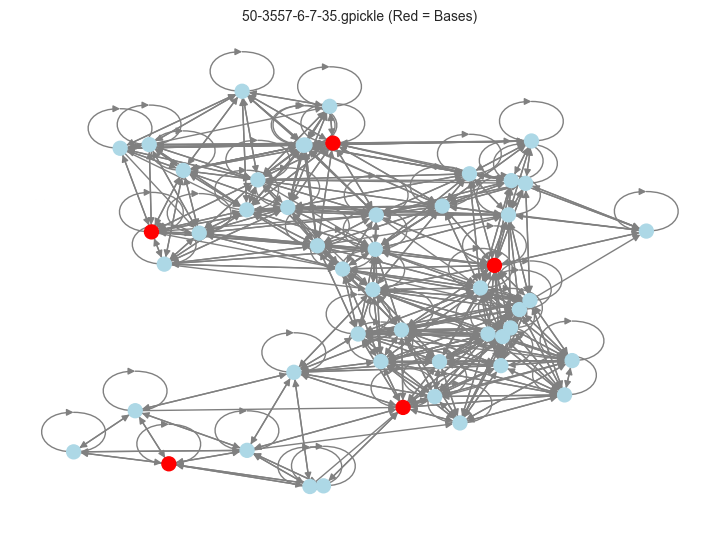


🔍 Processing 50-4606-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(82.83845044759052), np.float64(47.85496223887579)), (np.float64(10.988149826657938), np.float64(129.44835026452486)), (np.float64(85.12513261399491), np.float64(-33.64369858208566)), (np.float64(83.833842486748), np.float64(-6.453085862121561)), (np.float64(-14.220566362543144), np.float64(2.513939650472304))]


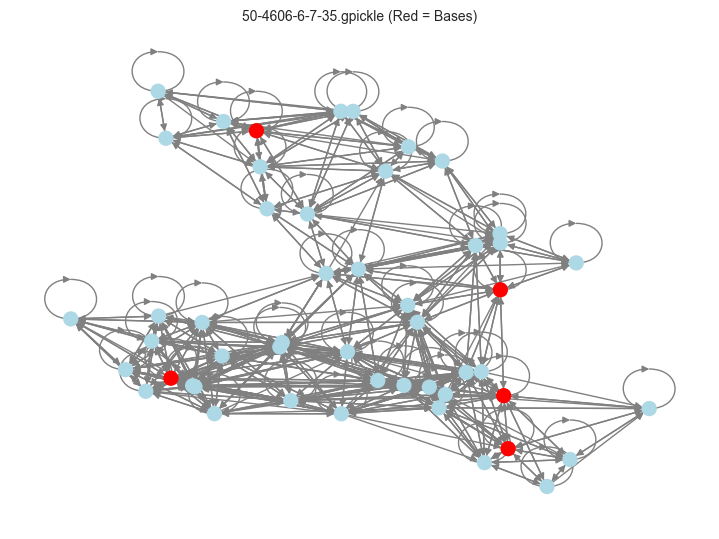


🔍 Processing 50-9085-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(61.554984900124545), np.float64(73.42342072749967)), (np.float64(61.90971107761959), np.float64(138.88151989167687)), (np.float64(86.08702733209572), np.float64(14.68491595588005)), (np.float64(103.21640975714642), np.float64(63.96713503209232)), (np.float64(33.03625809508789), np.float64(-6.935249336240362))]


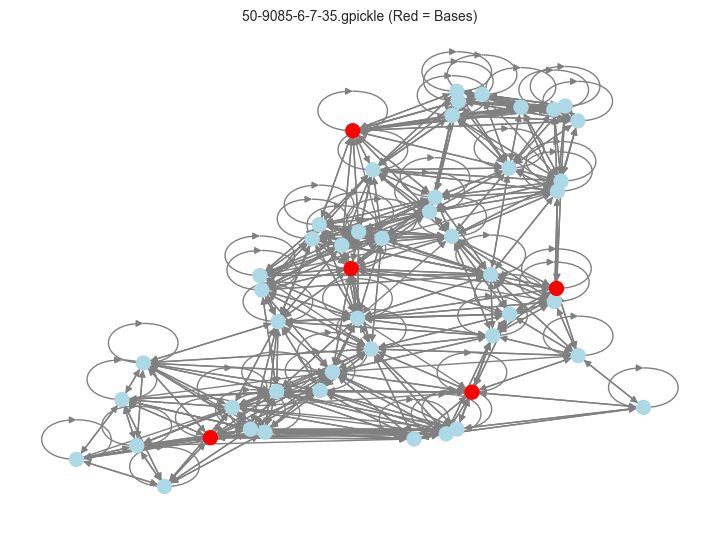


🔍 Processing 50-3389-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(116.4626296038246), np.float64(-33.9236888921012)), (np.float64(113.32965387275233), np.float64(19.299613644064806)), (np.float64(-43.19912667151699), np.float64(66.58289752405311)), (np.float64(28.28743505757513), np.float64(36.13181546187465)), (np.float64(76.80194058063708), np.float64(-19.16303956052547))]


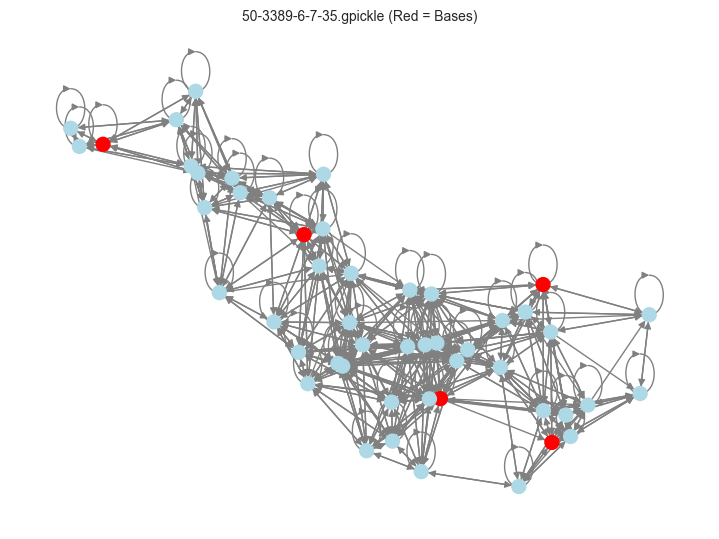


🔍 Processing 50-3004-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(31.787321838977057), np.float64(139.71582090950744)), (np.float64(-21.82513254086989), np.float64(14.334540113756065)), (np.float64(97.38961699220764), np.float64(14.638328691984295)), (np.float64(48.50591933747418), np.float64(-30.58059436441369)), (np.float64(-43.97216047743984), np.float64(107.46106685867151))]


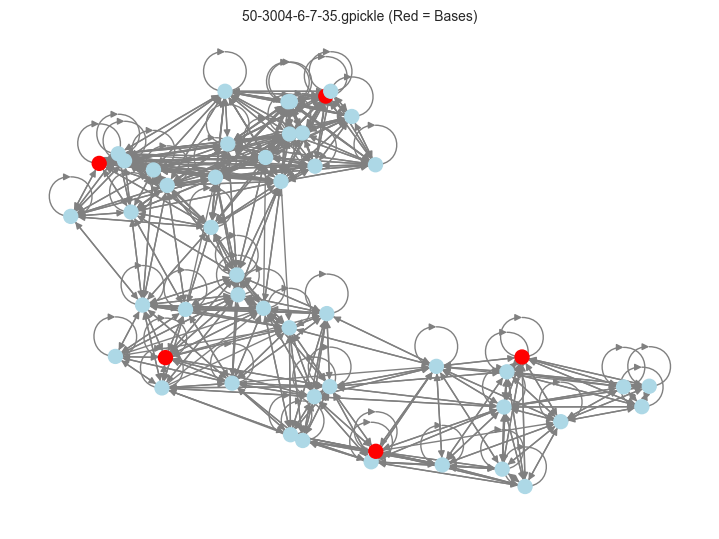

In [177]:
for g_file in gpickle_files:
    base_file = g_file.replace(".gpickle", ".bases")
    gpickle_path = os.path.join(DATA_DIR, g_file)
    base_path = os.path.join(DATA_DIR, base_file)

    print(f"\n🔍 Processing {g_file}")

    # Load the graph
    with open(gpickle_path, 'rb') as f:
        G = pickle.load(f)

    if not isinstance(G, nx.Graph):
        print(f"{g_file}: ❌ Not a valid graph.")
        continue

    # Extract all node labels (which are coordinate tuples)
    node_coords = list(G.nodes)

    # Load base coordinates from .bases file (as tuples)
    base_coords = []
    with open(base_path, 'r') as f:
        for line in f:
            if line.strip():
                coord = eval(line.strip())  # assumes format: (x, y)
                base_coords.append(coord)

    # Check which graph nodes match the base coordinates exactly
    base_nodes = [node for node in G.nodes if node in base_coords]
    print(f"🚑 Base nodes matched: {base_nodes}")

    # Color base nodes red, others light blue
    color_map = ['red' if node in base_nodes else 'lightblue' for node in G.nodes]

    # Build layout: use node coordinates as positions
    pos = {node: node for node in G.nodes}  # position = node coordinate

    # Draw the graph
    plt.figure(figsize=(7, 5))
    nx.draw(
        G, pos,
        with_labels=False,
        node_color=color_map,
        node_size=100,
        edge_color='gray',
    )
    plt.title(f"{g_file} (Red = Bases)", fontsize=10)
    plt.axis('off')
    plt.show()

# Step0.C: Column Generation / Generate All Valid Ambulance Paths (“Configurations”)

In [ ]:
# Step 0.C: Generate All Valid Ambulance Allocations ("Configurations")
# REVISED: Generate all possible ways to allocate ambulances across bases

import itertools
import os
import pickle
import pandas as pd

# --- SETTINGS ---
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
T = 6
NUM_AMBULANCES = 35
OUTPUT_DIR = f"configurations/50/{FILENAME}_allocations"

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

# Generate all combinations using stars and bars approach
# We need to distribute NUM_AMBULANCES across len(base_coords) bases
def generate_allocations(total_ambulances, num_bases):
    """Generate all possible ways to allocate total_ambulances across num_bases"""
    if num_bases == 1:
        return [(total_ambulances,)]
    
    allocations = []
    for first_base_count in range(total_ambulances + 1):
        remaining_ambulances = total_ambulances - first_base_count
        remaining_bases = num_bases - 1
        
        sub_allocations = generate_allocations(remaining_ambulances, remaining_bases)
        for sub_allocation in sub_allocations:
            allocation = (first_base_count,) + sub_allocation
            allocations.append(allocation)
    
    return allocations

# Generate all possible allocations
configurations = generate_allocations(NUM_AMBULANCES, len(base_coords))

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save configurations
with open(os.path.join(OUTPUT_DIR, "configurations.pkl"), "wb") as f:
    pickle.dump(configurations, f)

# Create DataFrame with proper column names
df_data = []
for cfg_idx, config in enumerate(configurations):
    row = [cfg_idx] + list(config)
    df_data.append(row)

columns = ["config_id"] + [f"base{i}_ambulances" for i in range(len(base_coords))]
df = pd.DataFrame(df_data, columns=columns)
df.to_csv(os.path.join(OUTPUT_DIR, "configurations.csv"), index=False)

print(f"\n✅ Generated {len(configurations)} configurations")
print(f"✅ Saved to {OUTPUT_DIR}")

# Show first 5 configurations as examples
print("\n=== First 5 configurations ===")
print(df.head(5).to_string(index=False))

# Verify the sum constraint
print("\n=== Verification ===")
for idx, row in df.head(5).iterrows():
    total = sum(row[f"base{i}_ambulances"] for i in range(len(base_coords)))
    print(f"Config {row['config_id']}: total ambulances = {total} (should be {NUM_AMBULANCES})")

# Calculate and display statistics
total_configs = len(configurations)
print(f"\n=== Statistics ===")
print(f"Total number of configurations: {total_configs:,}")
print(f"Maximum ambulances per base: {max(max(config) for config in configurations)}")
print(f"Average ambulances per base: {NUM_AMBULANCES / len(base_coords):.2f}")

# Calculate using stars and bars formula for verification
import math
expected_configs = math.comb(NUM_AMBULANCES + len(base_coords) - 1, len(base_coords) - 1)
print(f"Expected configurations (stars and bars): {expected_configs:,}")
print(f"Generated == Expected: {total_configs == expected_configs}")

# Create a visualization of allocation patterns
import matplotlib.pyplot as plt

# Plot first few configurations
fig, ax = plt.subplots(figsize=(12, 8))
for i, config in enumerate(configurations[:10]):  # First 10 configs
    ax.bar(range(len(base_coords)), config, alpha=0.7, label=f'Config {i}')

ax.set_xlabel('Base Index')
ax.set_ylabel('Number of Ambulances')
ax.set_title('Ambulance Allocation Patterns (First 10 Configurations)')
ax.set_xticks(range(len(base_coords)))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "allocation_patterns.png"), dpi=300, bbox_inches='tight')
plt.close()

# Create histogram of ambulance distribution
allocation_counts = []
for config in configurations:
    allocation_counts.extend(config)

plt.figure(figsize=(10, 6))
plt.hist(allocation_counts, bins=range(max(allocation_counts)+2), align='left', rwidth=0.8)
plt.xlabel('Number of Ambulances')
plt.ylabel('Frequency')
plt.title('Distribution of Ambulance Counts Across All Configurations')
plt.xticks(range(max(allocation_counts)+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ambulance_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ Visualizations saved to {OUTPUT_DIR}")


✅ Generated 82251 configurations
✅ Saved to configurations/50/50-3004-6-7-35_allocations

=== First 5 configurations ===
 config_id  base0_ambulances  base1_ambulances  base2_ambulances  base3_ambulances  base4_ambulances
         0                 0                 0                 0                 0                35
         1                 0                 0                 0                 1                34
         2                 0                 0                 0                 2                33
         3                 0                 0                 0                 3                32
         4                 0                 0                 0                 4                31

=== Verification ===
Config 0: total ambulances = 35 (should be 35)
Config 1: total ambulances = 35 (should be 35)
Config 2: total ambulances = 35 (should be 35)
Config 3: total ambulances = 35 (should be 35)
Config 4: total ambulances = 35 (should be 35)

=== Statistics

In [201]:
# Step 0.C: Generate All Valid Ambulance Allocations ("Configurations")
# REVISED: Generate all possible ways to allocate ambulances across bases

import itertools
import os
import pickle
import pandas as pd

# --- SETTINGS ---
DATA_DIR = "./data/50"
FILENAME = "50-9085-6-7-35"
T = 6
NUM_AMBULANCES = 35
OUTPUT_DIR = f"configurations/50/{FILENAME}_allocations"

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

# Generate all combinations using stars and bars approach
# We need to distribute NUM_AMBULANCES across len(base_coords) bases
def generate_allocations(total_ambulances, num_bases):
    """Generate all possible ways to allocate total_ambulances across num_bases"""
    if num_bases == 1:
        return [(total_ambulances,)]
    
    allocations = []
    for first_base_count in range(total_ambulances + 1):
        remaining_ambulances = total_ambulances - first_base_count
        remaining_bases = num_bases - 1
        
        sub_allocations = generate_allocations(remaining_ambulances, remaining_bases)
        for sub_allocation in sub_allocations:
            allocation = (first_base_count,) + sub_allocation
            allocations.append(allocation)
    
    return allocations

# Generate all possible allocations
configurations = generate_allocations(NUM_AMBULANCES, len(base_coords))

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save configurations
with open(os.path.join(OUTPUT_DIR, "configurations.pkl"), "wb") as f:
    pickle.dump(configurations, f)

# Create DataFrame with proper column names
df_data = []
for cfg_idx, config in enumerate(configurations):
    row = [cfg_idx] + list(config)
    df_data.append(row)

columns = ["config_id"] + [f"base{i}_ambulances" for i in range(len(base_coords))]
df = pd.DataFrame(df_data, columns=columns)
df.to_csv(os.path.join(OUTPUT_DIR, "configurations.csv"), index=False)

print(f"\n✅ Generated {len(configurations)} configurations")
print(f"✅ Saved to {OUTPUT_DIR}")

# Show first 5 configurations as examples
print("\n=== First 5 configurations ===")
print(df.head(5).to_string(index=False))

# Verify the sum constraint
print("\n=== Verification ===")
for idx, row in df.head(5).iterrows():
    total = sum(row[f"base{i}_ambulances"] for i in range(len(base_coords)))
    print(f"Config {row['config_id']}: total ambulances = {total} (should be {NUM_AMBULANCES})")

# Calculate and display statistics
total_configs = len(configurations)
print(f"\n=== Statistics ===")
print(f"Total number of configurations: {total_configs:,}")
print(f"Maximum ambulances per base: {max(max(config) for config in configurations)}")
print(f"Average ambulances per base: {NUM_AMBULANCES / len(base_coords):.2f}")

# Calculate using stars and bars formula for verification
import math
expected_configs = math.comb(NUM_AMBULANCES + len(base_coords) - 1, len(base_coords) - 1)
print(f"Expected configurations (stars and bars): {expected_configs:,}")
print(f"Generated == Expected: {total_configs == expected_configs}")

# Create a visualization of allocation patterns
import matplotlib.pyplot as plt

# Plot first few configurations
fig, ax = plt.subplots(figsize=(12, 8))
for i, config in enumerate(configurations[:10]):  # First 10 configs
    ax.bar(range(len(base_coords)), config, alpha=0.7, label=f'Config {i}')

ax.set_xlabel('Base Index')
ax.set_ylabel('Number of Ambulances')
ax.set_title('Ambulance Allocation Patterns (First 10 Configurations)')
ax.set_xticks(range(len(base_coords)))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "allocation_patterns.png"), dpi=300, bbox_inches='tight')
plt.close()

# Create histogram of ambulance distribution
allocation_counts = []
for config in configurations:
    allocation_counts.extend(config)

plt.figure(figsize=(10, 6))
plt.hist(allocation_counts, bins=range(max(allocation_counts)+2), align='left', rwidth=0.8)
plt.xlabel('Number of Ambulances')
plt.ylabel('Frequency')
plt.title('Distribution of Ambulance Counts Across All Configurations')
plt.xticks(range(max(allocation_counts)+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ambulance_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ Visualizations saved to {OUTPUT_DIR}")


✅ Generated 82251 configurations
✅ Saved to configurations/50/50-9085-6-7-35_allocations

=== First 5 configurations ===
 config_id  base0_ambulances  base1_ambulances  base2_ambulances  base3_ambulances  base4_ambulances
         0                 0                 0                 0                 0                35
         1                 0                 0                 0                 1                34
         2                 0                 0                 0                 2                33
         3                 0                 0                 0                 3                32
         4                 0                 0                 0                 4                31

=== Verification ===
Config 0: total ambulances = 35 (should be 35)
Config 1: total ambulances = 35 (should be 35)
Config 2: total ambulances = 35 (should be 35)
Config 3: total ambulances = 35 (should be 35)
Config 4: total ambulances = 35 (should be 35)

=== Statistics

# STEP 1.A >>> Run experiments on a small dataset - Compare different batches of configurations and show how the fairness changes 

#### Master Problem ILP construction (Configuration-based / TESTING before batch processing : only 100 configs)

### STEP 1.A - 1 >>> Optimization and Data Collection

In [185]:
# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Create the results directory structure
results_dir = "results/Step1A"
os.makedirs(results_dir, exist_ok=True)

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

# Create zone/base numbering for simplified labels
zone_to_num = {zone: i+1 for i, zone in enumerate(zones)}
num_to_zone = {i+1: zone for i, zone in enumerate(zones)}
base_to_num = {base: i+1 for i, base in enumerate(base_coords)}

# --- TEST WITH DIFFERENT BATCH SIZES ---
batch_sizes = [10, 100, 1000, 10000]
results = []
zone_coverage_details = []

# Main optimization loop for different batch sizes
for batch_size in batch_sizes:
    
    # Reload environment for each batch
    env = gp.Env(params=params)
    model = gp.Model(env=env)
    
    # --- LOAD CONFIGURATIONS ---
    df = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv")).head(batch_size)
    configurations = []
    for _, row in df.iterrows():
        config = []
        for i in range(len(base_coords)):
            config.append(int(row[f"base{i}_ambulances"]))
        configurations.append(tuple(config))
        
    for i, cfg in enumerate(configurations[:5]):
        print(f"  Config {i}: {cfg}")
    
    # --- BUILD COVERAGE MATRIX b[i,t,c] ---
    b = {}
    for c_idx, config in enumerate(configurations):
        for base_idx, num_ambulances in enumerate(config):
            if num_ambulances > 0:
                base_zone = base_coords[base_idx]
                coverage = {base_zone} | adjacency.get(base_zone, set())
                for t in range(T):
                    for z in coverage:
                        b[(z, t, c_idx)] = 1
    
    # --- MODEL VARIABLES ---
    λ = model.addVars(len(configurations), vtype=GRB.BINARY, name="lambda")
    y = model.addVars(zones, vtype=GRB.INTEGER, name="y")
    z = model.addVar(vtype=GRB.INTEGER, name="z")
    
    # --- CONSTRAINTS ---
    # 1. Select exactly 1 configuration
    model.addConstr(gp.quicksum(λ[c] for c in range(len(configurations))) == 1, "select_one_config")
    
    # 2. Define y_i = total coverage for each zone
    for i in zones:
        model.addConstr(
            y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(len(configurations)) for t in range(T)),
            f"coverage_{i}"
        )
    
    # 3. Fairness constraint: z ≥ y_i - y_j for all zones
    for i in zones:
        for j in zones:
            model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")
    
    # --- OBJECTIVE ---
    model.setObjective(z, GRB.MINIMIZE)
    
    # --- SOLVE (THIS IS THE OPTIMIZATION STEP) ---
    model.optimize()
    
    # --- COLLECT RESULTS ---
    selected_idx = [c for c in range(len(configurations)) if λ[c].X > 0.5][0]
    selected_config = configurations[selected_idx]
    
    # Collect zone-wise coverage
    zone_coverage = {}
    for i in zones:
        zone_coverage[str(i)] = int(y[i].X)
    
    coverage_values = list(zone_coverage.values())
    
    result = {
        'batch_size': batch_size,
        'config_id': selected_idx,
        'selected_config': selected_config,
        'fairness_gap': int(z.X),
        'min_coverage': min(coverage_values),
        'max_coverage': max(coverage_values),
        'avg_coverage': np.mean(coverage_values),
        'coverage_std': np.std(coverage_values)
    }
    results.append(result)
    
    # Store zone coverage details
    zone_coverage_details.append({
        'batch_size': batch_size,
        'zone_coverage': zone_coverage,
        'fairness_gap': int(z.X)
    })
    
    print(f"Fairness gap: {result['fairness_gap']}")
    print(f"Coverage range: {result['min_coverage']} to {result['max_coverage']}")
    
    # Clean up model and environment
    model.dispose()
    env.dispose()

# --- ANALYSIS SUMMARY ---
print("\n=== DETAILED ANALYSIS ===")
print(f"Total configurations possible: {10295472:,}")
print("\nBatch Size Analysis:")
for i in range(len(batch_sizes)):
    print(f"\n{batch_sizes[i]:,} configurations:")
    print(f"  Fairness Gap: {results[i]['fairness_gap']}")
    print(f"  Min Coverage: {results[i]['min_coverage']}")
    print(f"  Max Coverage: {results[i]['max_coverage']}")
    
    if i > 0:
        improvement = results[i-1]['fairness_gap'] - results[i]['fairness_gap']
        print(f"  Improvement from previous: {improvement}")
        
        # Analyze configuration differences
        prev_config = results[i-1]['selected_config']
        curr_config = results[i]['selected_config']
        
        # Count how many bases changed
        changes = sum(1 for a, b in zip(prev_config, curr_config) if a != b)
        print(f"  Bases with changed allocation: {changes} out of {len(prev_config)}")

# Save results to CSV in the results directory
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_dir, 'results.csv'), index=False)
print(f"\n✅ Saved results to '{results_dir}/results.csv'")

# Save detailed zone coverage to a separate CSV
zone_details_df = pd.DataFrame()
for idx, detail in enumerate(zone_coverage_details):
    batch_size = detail['batch_size']
    for zone_num in range(1, len(zones) + 1):
        zone_coord = num_to_zone[zone_num]
        coverage = detail['zone_coverage'][str(zone_coord)]
        zone_details_df = pd.concat([zone_details_df, pd.DataFrame({
            'batch_size': [batch_size],
            'zone': [zone_num],
            'zone_coord': [zone_coord],
            'coverage': [coverage]
        })])

zone_details_df.to_csv(os.path.join(results_dir, 'zone_coverage_details.csv'), index=False)
print(f"✅ Saved zone coverage details to '{results_dir}/zone_coverage_details.csv'")

# Create variables for visualization (accessible to the second file)
batch_sizes_plot = [r['batch_size'] for r in results]
fairness_gaps = [r['fairness_gap'] for r in results]
min_coverages = [r['min_coverage'] for r in results]
max_coverages = [r['max_coverage'] for r in results]
avg_coverages = [r['avg_coverage'] for r in results]
zone_numbers = list(range(1, len(zones) + 1))

# Save variables for visualization
visualization_data = {
    'batch_sizes': batch_sizes,
    'results': results,
    'zone_coverage_details': zone_coverage_details,
    'zones': zones,
    'zone_to_num': zone_to_num,
    'num_to_zone': num_to_zone
}

with open(os.path.join(results_dir, 'visualization_data.pkl'), 'wb') as f:
    pickle.dump(visualization_data, f)
print(f"✅ Saved visualization data to '{results_dir}/visualization_data.pkl'")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
  Config 0: (0, 0, 0, 0, 35)
  Config 1: (0, 0, 0, 1, 34)
  Config 2: (0, 0, 0, 2, 33)
  Config 3: (0, 0, 0, 3, 32)
  Config 4: (0, 0, 0, 4, 31)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 61 columns and 7677 nonzeros
Model fingerprint: 0x783db0c8
Variable types: 0 continuous, 61 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2551 rows and 61 columns
Presolve time: 0.00s
Presolve: All rows and colum

### STEP 1.A - 2 >>> Visualization and Plotting

/var/folders/_2/nvq16qmj48g5ggtmz5d52m000000gn/T/ipykernel_85807/401161358.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


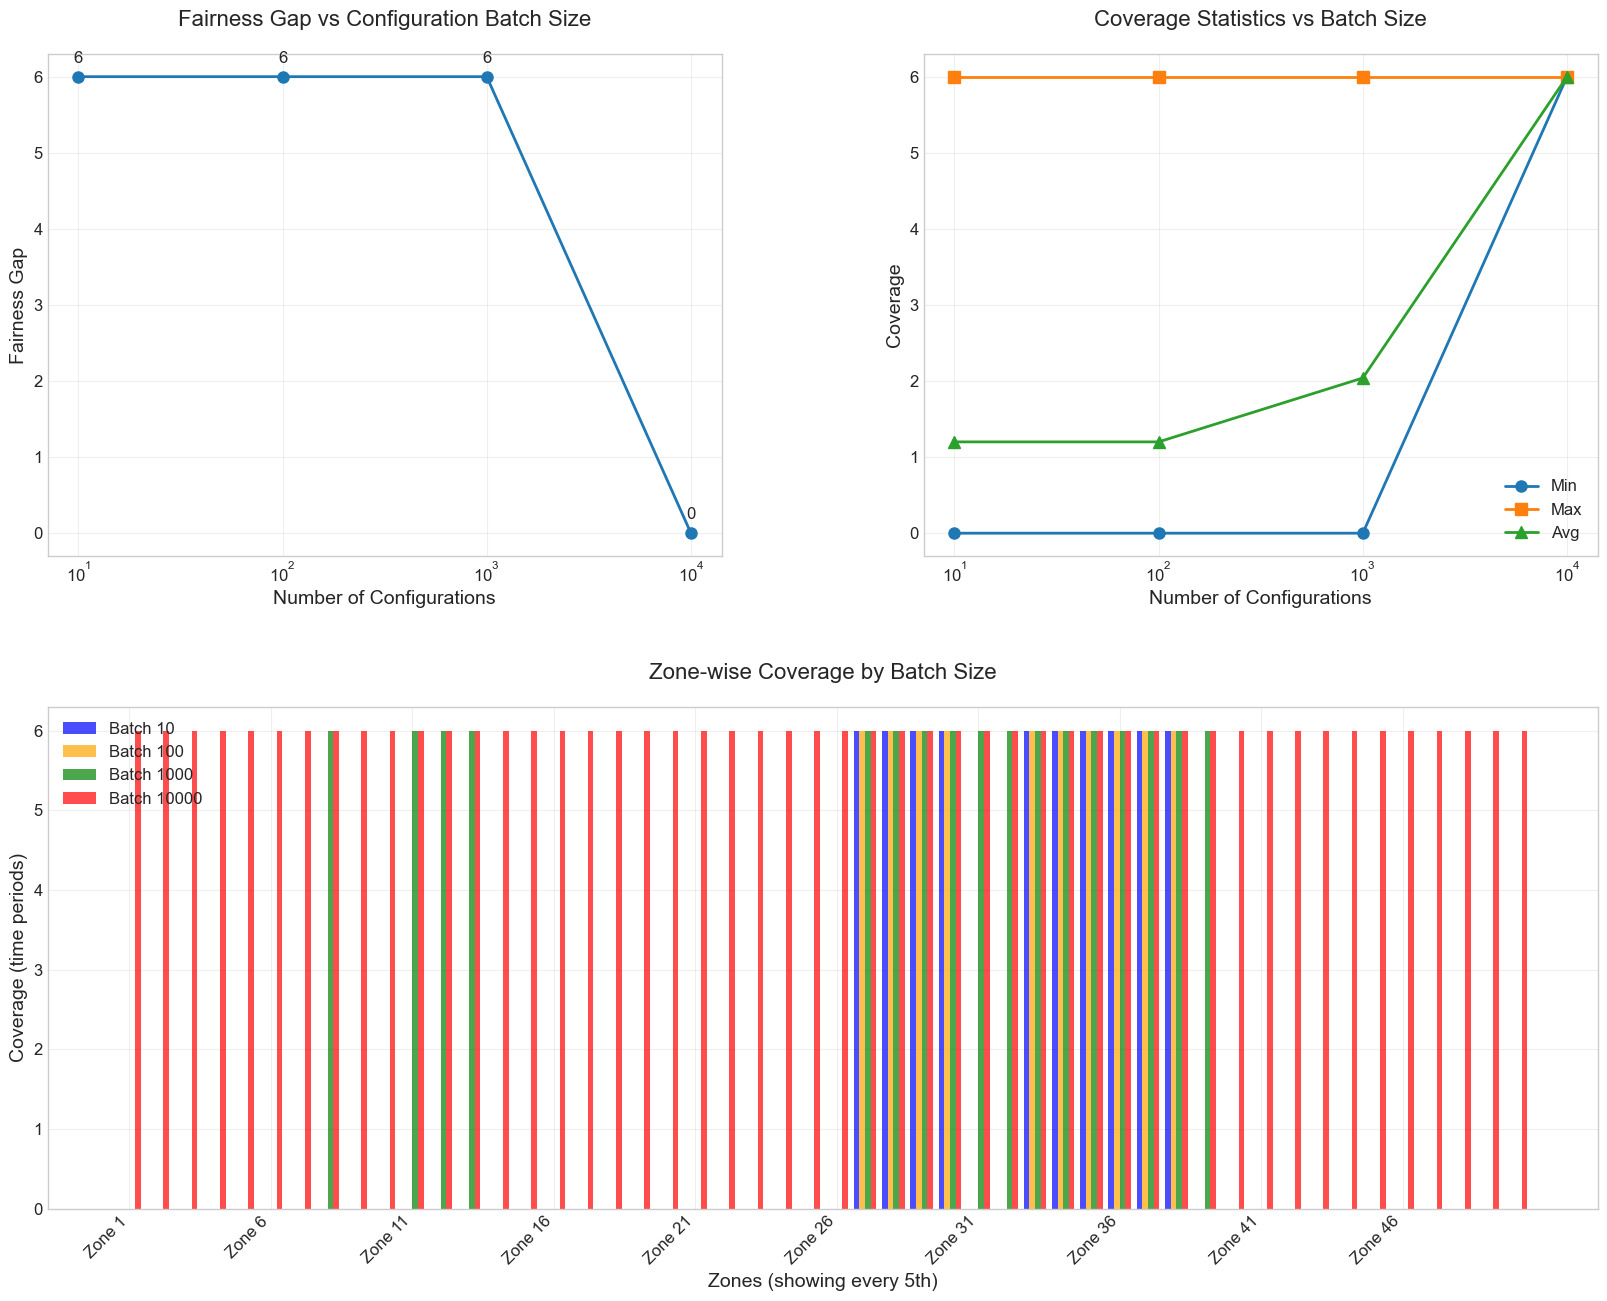

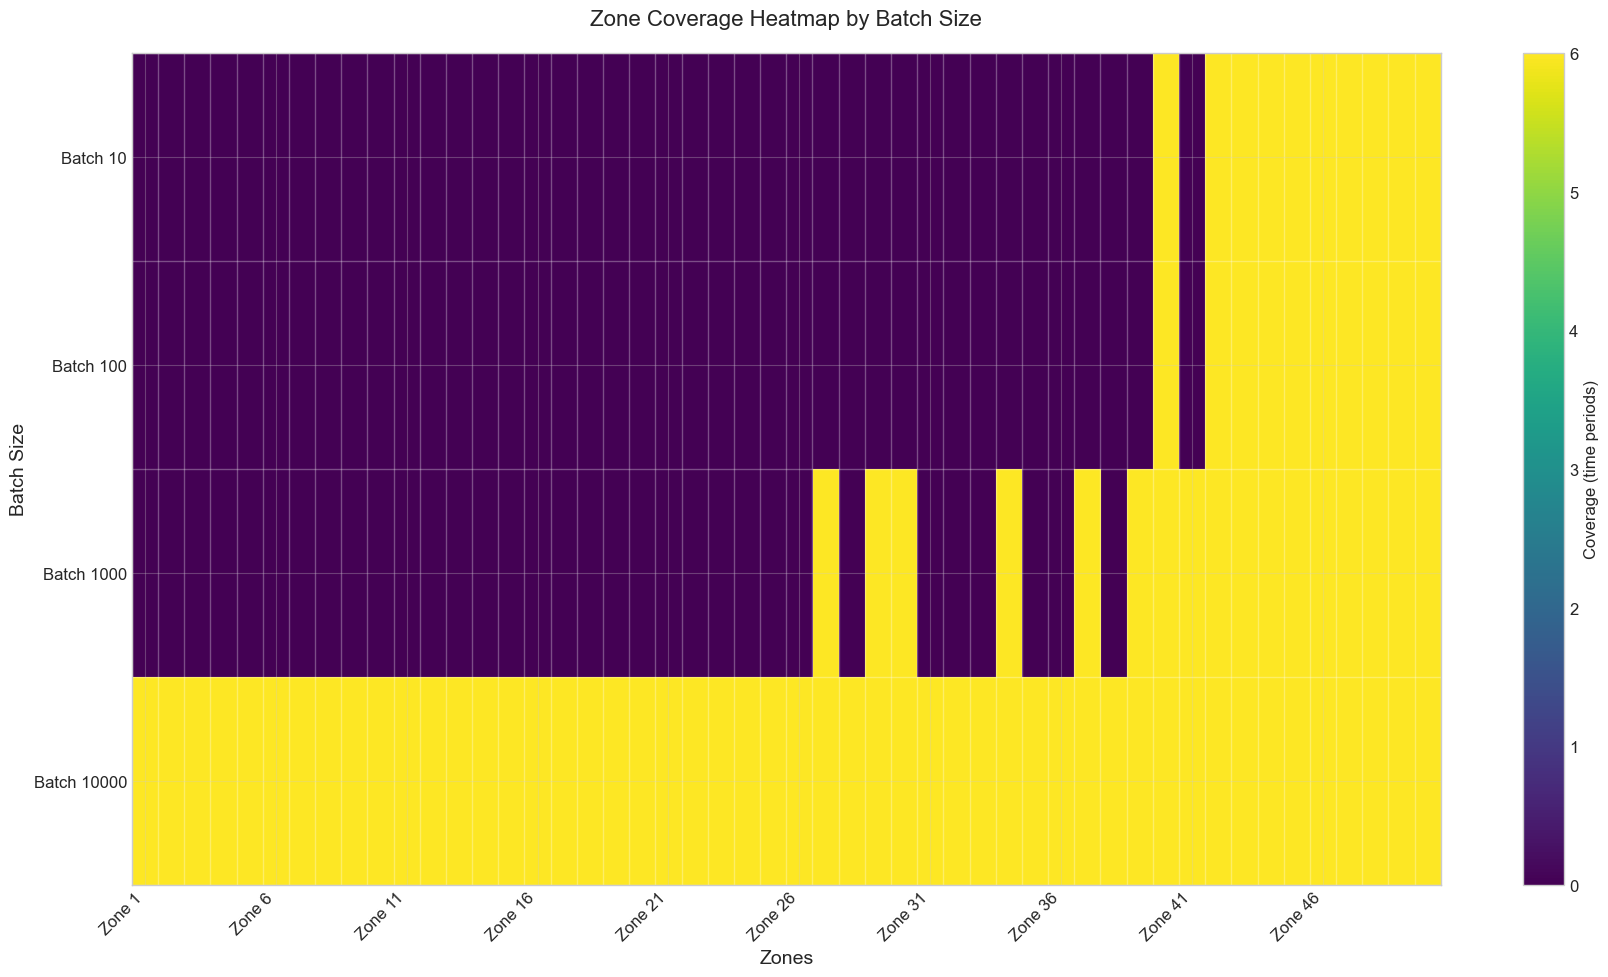

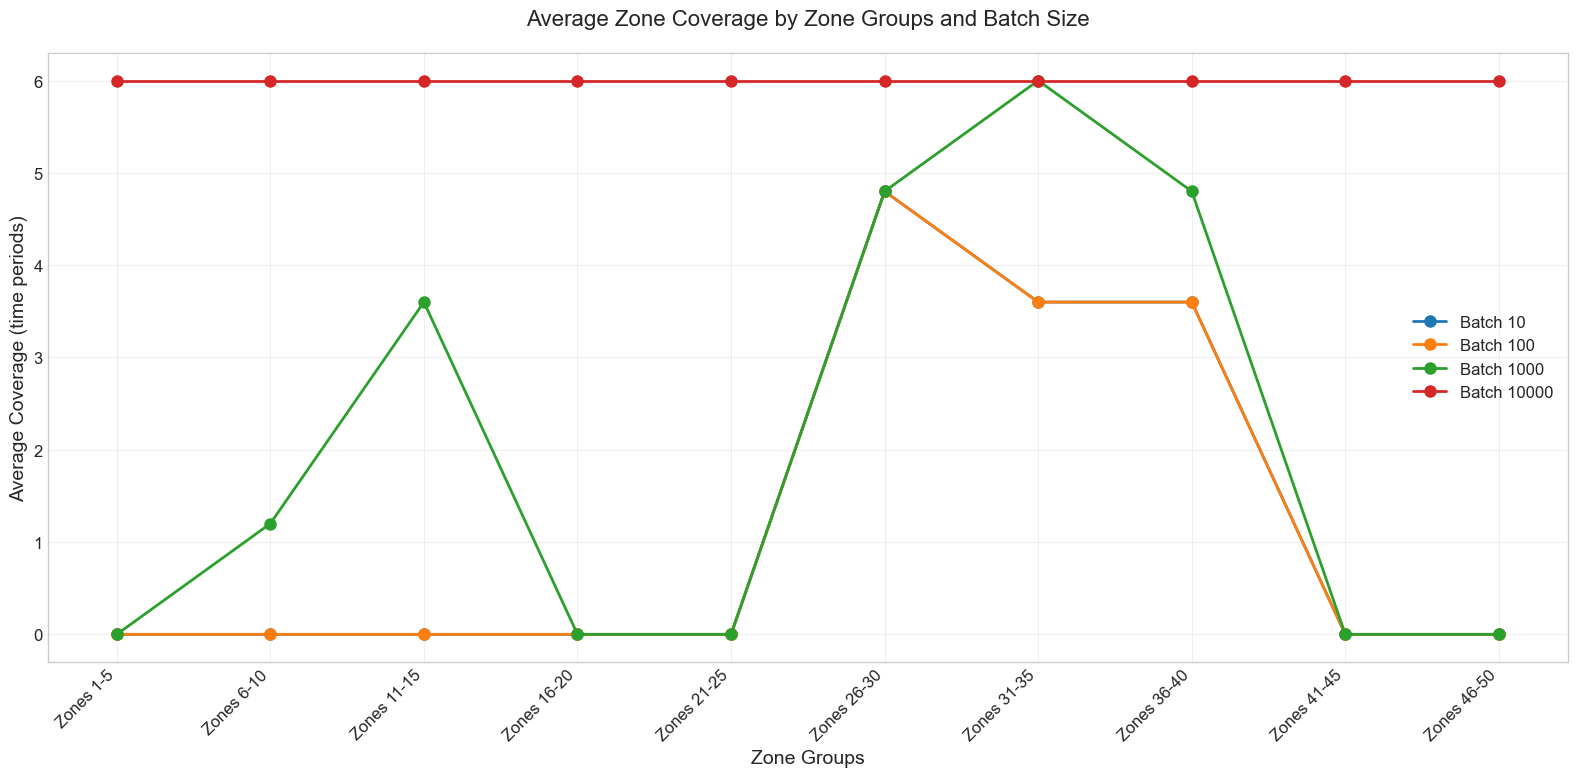

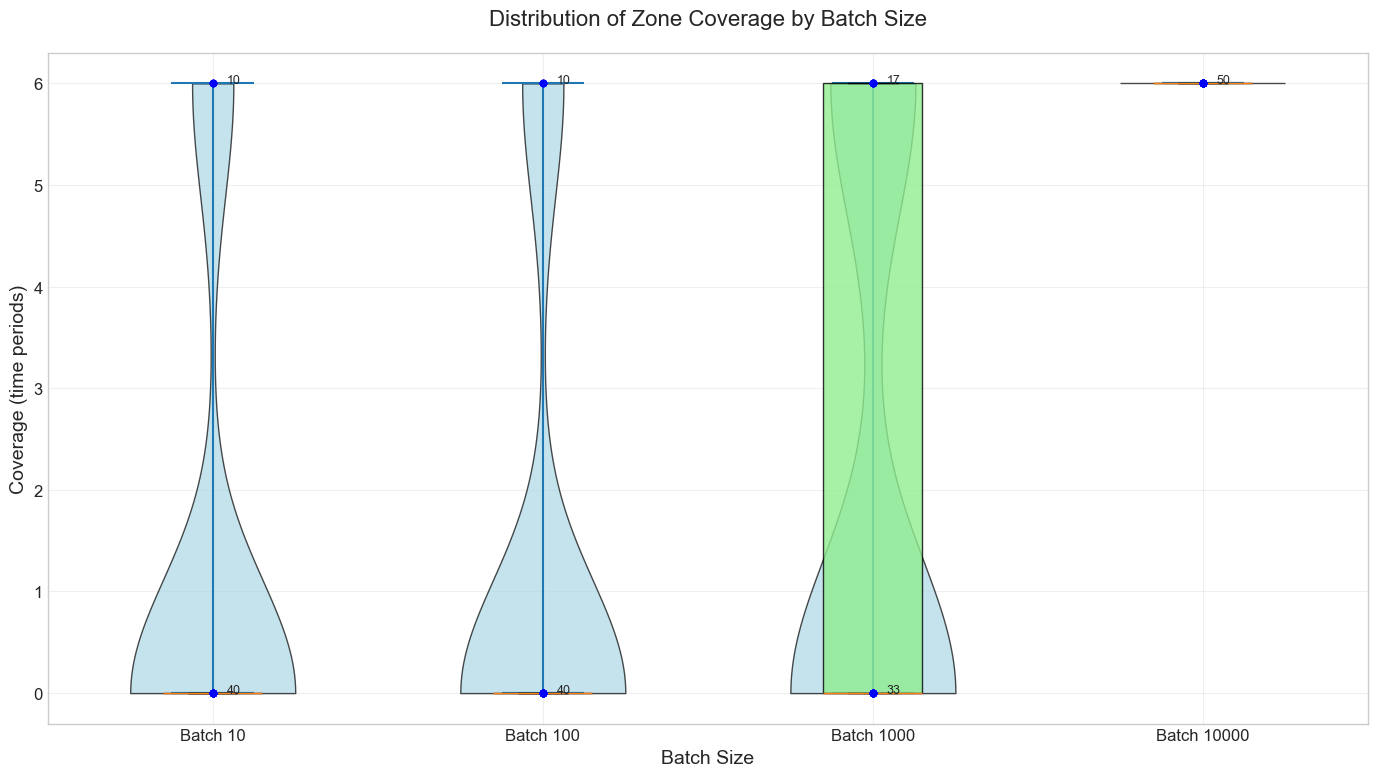

✅ All visualizations completed and saved to the results directory
✅ Results directory: results/Step1A


In [186]:
# Load the saved visualization data
results_dir = "results/Step1A"
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    data = pickle.load(f)

# Extract variables
batch_sizes = data['batch_sizes']
results = data['results']
zone_coverage_details = data['zone_coverage_details']
zones = data['zones']
zone_to_num = data['zone_to_num']
num_to_zone = data['num_to_zone']

# Prepare data for plotting
batch_sizes_plot = [r['batch_size'] for r in results]
fairness_gaps = [r['fairness_gap'] for r in results]
min_coverages = [r['min_coverage'] for r in results]
max_coverages = [r['max_coverage'] for r in results]
avg_coverages = [r['avg_coverage'] for r in results]
zone_numbers = list(range(1, len(zones) + 1))

# --- VISUALIZATION: MAIN PLOTS ---
# Create a 2x2 grid for first 3 plots
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Fairness gap vs batch size
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(batch_sizes_plot, fairness_gaps, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Fairness Gap', fontsize=14)
ax1.set_title('Fairness Gap vs Configuration Batch Size', fontsize=16, pad=20)
ax1.grid(True, alpha=0.3)

# Annotate dramatic improvement
for i, (x, y) in enumerate(zip(batch_sizes_plot, fairness_gaps)):
    ax1.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

# Plot 2: Coverage statistics
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(batch_sizes_plot, min_coverages, 'o-', label='Min', linewidth=2, markersize=8)
ax2.plot(batch_sizes_plot, max_coverages, 's-', label='Max', linewidth=2, markersize=8)
ax2.plot(batch_sizes_plot, avg_coverages, '^-', label='Avg', linewidth=2, markersize=8)
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Coverage', fontsize=14)
ax2.set_title('Coverage Statistics vs Batch Size', fontsize=16, pad=20)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Original bar chart
ax3 = fig.add_subplot(gs[1, :])  # Spans both columns of second row
x = np.arange(len(zone_numbers))
width = 0.2

colors = ['blue', 'orange', 'green', 'red']
for idx, (batch_detail, color) in enumerate(zip(zone_coverage_details, colors)):
    coverage_list = []
    for zone_num in zone_numbers:
        zone_coord = num_to_zone[zone_num]
        coverage_list.append(batch_detail['zone_coverage'][str(zone_coord)])
    
    offset = (idx - 1.5) * width
    bars = ax3.bar(x + offset, coverage_list, width, label=f'Batch {batch_detail["batch_size"]}', 
                   alpha=0.7, color=color)

# Only show every 5th label to reduce clutter
xtick_positions = x[::5]
xtick_labels = [f'Zone {n}' for n in zone_numbers[::5]]
ax3.set_xticks(xtick_positions)
ax3.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax3.set_xlabel('Zones (showing every 5th)', fontsize=14)
ax3.set_ylabel('Coverage (time periods)', fontsize=14)
ax3.set_title('Zone-wise Coverage by Batch Size', fontsize=16, pad=20)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'three_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- VISUALIZATION: ALTERNATIVE PLOTS ---

# PLOT OPTION 1: Heatmap
plt.figure(figsize=(18, 10))

# Prepare data for heatmap
heatmap_data = np.zeros((len(batch_sizes), len(zones)))
for b_idx, batch_detail in enumerate(zone_coverage_details):
    for z_idx, zone in enumerate(sorted(zones)):
        heatmap_data[b_idx, z_idx] = batch_detail['zone_coverage'][str(zone)]

# Create heatmap
ax = plt.axes()
im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Coverage (time periods)', fontsize=12)

# Configure axes
ax.set_yticks(np.arange(len(batch_sizes)))
ax.set_yticklabels([f'Batch {b}' for b in batch_sizes])

# Only show subset of zone labels to avoid overcrowding
zone_indices = np.arange(0, len(zones), 5)
zone_labels = [f'Zone {zone_to_num[zones[i]]}' for i in zone_indices]
ax.set_xticks(zone_indices)
ax.set_xticklabels(zone_labels, rotation=45, ha='right')

# Add title and axis labels
plt.title('Zone Coverage Heatmap by Batch Size', fontsize=16, pad=20)
plt.xlabel('Zones', fontsize=14)
plt.ylabel('Batch Size', fontsize=14)

# Add grid lines to differentiate cells
ax.set_xticks(np.arange(-.5, len(zones), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(batch_sizes), 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'zone_coverage_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

# PLOT OPTION 2: Line Plot with Zone Groups
plt.figure(figsize=(16, 8))

# Group zones (e.g., by 5)
group_size = 5
zone_groups = [zones[i:i+group_size] for i in range(0, len(zones), group_size)]

# For each batch size
for b_idx, batch_detail in enumerate(zone_coverage_details):
    batch_size = batch_detail['batch_size']
    
    # Calculate average coverage for each zone group
    group_averages = []
    for group in zone_groups:
        avg_coverage = np.mean([batch_detail['zone_coverage'][str(zone)] for zone in group])
        group_averages.append(avg_coverage)
    
    # Plot line for this batch size
    plt.plot(np.arange(len(zone_groups)), group_averages, 'o-', 
             label=f'Batch {batch_size}', linewidth=2, markersize=8)

# Configure axes
plt.xticks(np.arange(len(zone_groups)), 
           [f'Zones {zone_to_num[group[0]]}-{zone_to_num[group[-1]]}' for group in zone_groups],
           rotation=45, ha='right')
plt.xlabel('Zone Groups', fontsize=14)
plt.ylabel('Average Coverage (time periods)', fontsize=14)
plt.title('Average Zone Coverage by Zone Groups and Batch Size', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'zone_group_coverage.png'), dpi=300, bbox_inches='tight')
plt.show()

# PLOT OPTION 3: Distribution Plot
plt.figure(figsize=(14, 8))

# Prepare data for box plots
data_for_boxplot = []
labels = []

for batch_detail in zone_coverage_details:
    batch_size = batch_detail['batch_size']
    coverage_values = list(batch_detail['zone_coverage'].values())
    data_for_boxplot.append(coverage_values)
    labels.append(f'Batch {batch_size}')

# Create violin plots with embedded box plots
violin_parts = plt.violinplot(data_for_boxplot, showmeans=False, showmedians=True)

# Customize violin plots
for pc in violin_parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add box plots inside the violin plots
box_parts = plt.boxplot(data_for_boxplot, positions=np.arange(1, len(data_for_boxplot) + 1), 
                        widths=0.3, patch_artist=True, showfliers=False)

# Customize box plots
for box in box_parts['boxes']:
    box.set(facecolor='lightgreen', alpha=0.8)

# Add individual data points
for i, dataset in enumerate(data_for_boxplot):
    plt.scatter(np.repeat(i+1, len(dataset)), dataset, alpha=0.5, 
                color='blue', s=20, zorder=10)

# Configure axes
plt.xticks(np.arange(1, len(labels) + 1), labels)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Coverage (time periods)', fontsize=14)
plt.title('Distribution of Zone Coverage by Batch Size', fontsize=16, pad=20)
plt.grid(axis='y', alpha=0.3)

# Add coverage counts as annotations
for i, dataset in enumerate(data_for_boxplot):
    # Count occurrences of each value
    unique_vals, counts = np.unique(dataset, return_counts=True)
    
    # Sort by value
    sort_idx = np.argsort(unique_vals)
    unique_vals = unique_vals[sort_idx]
    counts = counts[sort_idx]
    
    # Add count annotations
    for val, count in zip(unique_vals, counts):
        plt.annotate(f'{count}', 
                    (i+1, val), 
                    xytext=(10, 0), 
                    textcoords='offset points',
                    fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'zone_coverage_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ All visualizations completed and saved to the results directory")
print(f"✅ Results directory: {results_dir}")

# STEP 2 >>> Run on the entire configurations - Compare the computation times and analyze the differences 

#### Master Problem ILP construction (Configuration-based / full comparison)

### STEP 2 - Part 1 >>> Setup and Optimization

In [187]:
# --- SETTINGS ---
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Create the results directory
results_dir = "results/Step2"
os.makedirs(results_dir, exist_ok=True)

# Define parameter variations for comprehensive analysis
T_VALUES = [3, 6, 9]  # Different time periods
BATCH_SIZES = [100, 1000, 10000, 100000, 1000000]  # Different batch sizes
MAX_CONFIGS = {  # Maximum available configs for each T
    3: 1296,
    6: 10295472,
    9: 78639000
}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# Store comprehensive results
all_results = []

# Main analysis loop
for T in T_VALUES:
    print(f"\n{'='*80}")
    print(f"ANALYZING WITH T = {T} TIME PERIODS")
    print(f"{'='*80}")
    
    # Generate configurations for this T value
    # Note: In practice, you'd generate configurations for different T values
    # For this example, we'll use the existing configurations
    
    for batch_size in BATCH_SIZES:
        # Skip if batch size exceeds available configurations
        if batch_size > MAX_CONFIGS.get(T, batch_size):
            print(f"⚠️ Skipping batch size {batch_size} for T={T} (exceeds available configurations)")
            continue
            
        print(f"\nTesting T={T}, Batch Size={batch_size}")
        print(f"{'-'*50}")
        
        try:
            # Timing experiment
            start_time = time.time()
            
            # Reload environment using the same params approach as Step 1
            env = gp.Env(params=params)  # Using params from Step 1
            model = gp.Model(env=env)
            
            # --- LOAD CONFIGURATIONS ---
            df = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv")).head(batch_size)
            configurations = []
            for _, row in df.iterrows():
                config = []
                for i in range(len(base_coords)):
                    config.append(int(row[f"base{i}_ambulances"]))
                configurations.append(tuple(config))
            
            # --- BUILD COVERAGE MATRIX ---
            build_start = time.time()
            b = {}
            for c_idx, config in enumerate(configurations):
                for base_idx, num_ambulances in enumerate(config):
                    if num_ambulances > 0:
                        base_zone = base_coords[base_idx]
                        coverage = {base_zone} | adjacency.get(base_zone, set())
                        for t in range(T):
                            for z in coverage:
                                b[(z, t, c_idx)] = 1
            build_time = time.time() - build_start
            
            # --- MODEL VARIABLES ---
            λ = model.addVars(len(configurations), vtype=GRB.BINARY, name="lambda")
            y = model.addVars(zones, vtype=GRB.INTEGER, name="y")
            z = model.addVar(vtype=GRB.INTEGER, name="z")
            
            # --- CONSTRAINTS ---
            model_build_start = time.time()
            model.addConstr(gp.quicksum(λ[c] for c in range(len(configurations))) == 1, "select_one_config")
            
            for i in zones:
                model.addConstr(
                    y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(len(configurations)) for t in range(T)),
                    f"coverage_{i}"
                )
            
            for i in zones:
                for j in zones:
                    model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")
            
            model.setObjective(z, GRB.MINIMIZE)
            model_build_time = time.time() - model_build_start
            
            # --- SOLVE ---
            solve_start = time.time()
            model.optimize()
            solve_time = time.time() - solve_start
            
            total_time = time.time() - start_time
            
            # --- COLLECT RESULTS ---
            selected_idx = [c for c in range(len(configurations)) if λ[c].X > 0.5][0]
            selected_config = configurations[selected_idx]
            
            # Collect statistics
            coverage_values = [int(y[i].X) for i in zones]
            fairness_gap = int(z.X)
            
            # Store results
            result = {
                'T': T,
                'batch_size': batch_size,
                'fairness_gap': fairness_gap,
                'min_coverage': min(coverage_values),
                'max_coverage': max(coverage_values),
                'avg_coverage': np.mean(coverage_values),
                'coverage_std': np.std(coverage_values),
                'num_variables': model.numVars,
                'num_constraints': model.numConstrs,
                'total_time': total_time,
                'build_time': build_time,
                'model_build_time': model_build_time,
                'solve_time': solve_time
            }
            all_results.append(result)
            
            print(f"✅ Success: Fairness gap = {fairness_gap}, Total time = {total_time:.2f}s")
            
            # Clean up
            model.dispose()
            env.dispose()
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            continue

# Convert results to DataFrame and save
df_results = pd.DataFrame(all_results)
df_results.to_csv(os.path.join(results_dir, 'comprehensive_results.csv'), index=False)
print(f"\n✅ Saved comprehensive results to '{results_dir}/comprehensive_results.csv'")

# Save data for visualization
visualization_data = {
    'T_VALUES': T_VALUES,
    'BATCH_SIZES': BATCH_SIZES,
    'results': all_results
}

with open(os.path.join(results_dir, 'visualization_data.pkl'), 'wb') as f:
    pickle.dump(visualization_data, f)
print(f"✅ Saved visualization data to '{results_dir}/visualization_data.pkl'")

# --- DETAILED ANALYSIS REPORT ---
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS REPORT")
print("="*80)

# Summary statistics by T value
print("\nSUMMARY BY T VALUE:")
print("-"*50)
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        print(f"\nT = {T}:")
        print(f"  Configurations tested: {len(T_data)}")
        print(f"  Best fairness gap: {T_data['fairness_gap'].min()}")
        print(f"  Average computation time: {T_data['total_time'].mean():.2f}s")
        print(f"  Max model size: {T_data['num_variables'].max():,} variables")

# Scaling analysis
print("\nSCALING ANALYSIS:")
print("-"*50)
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T].sort_values('batch_size')
    if len(T_data) > 1:
        batch_ratio = T_data['batch_size'].iloc[-1] / T_data['batch_size'].iloc[0]
        time_ratio = T_data['total_time'].iloc[-1] / T_data['total_time'].iloc[0]
        print(f"T = {T}:")
        print(f"  Batch size ratio: {batch_ratio:.1f}x")
        print(f"  Time ratio: {time_ratio:.1f}x")
        print(f"  Efficiency factor: {time_ratio/batch_ratio:.3f}")

# Optimal configurations found
print("\nOPTIMAL CONFIGURATIONS:")
print("-"*50)
for T in T_VALUES:
    best = df_results[df_results['T'] == T].nsmallest(1, 'fairness_gap')
    if len(best) > 0:
        print(f"T = {T}:")
        print(f"  Batch size: {best['batch_size'].iloc[0]:,}")
        print(f"  Fairness gap: {best['fairness_gap'].iloc[0]}")
        print(f"  Computation time: {best['total_time'].iloc[0]:.2f}s")

Number of zones: 50
Number of bases: 5

ANALYZING WITH T = 3 TIME PERIODS

Testing T=3, Batch Size=100
--------------------------------------------------
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 10375 nonzeros
Model fingerprint: 0xd3707c83
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2551 rows and 151 columns
Presolve time: 0.00s
Presolve: All 

### STEP 2 - Part 2: Visualization and Analysis

/var/folders/_2/nvq16qmj48g5ggtmz5d52m000000gn/T/ipykernel_85807/167396433.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


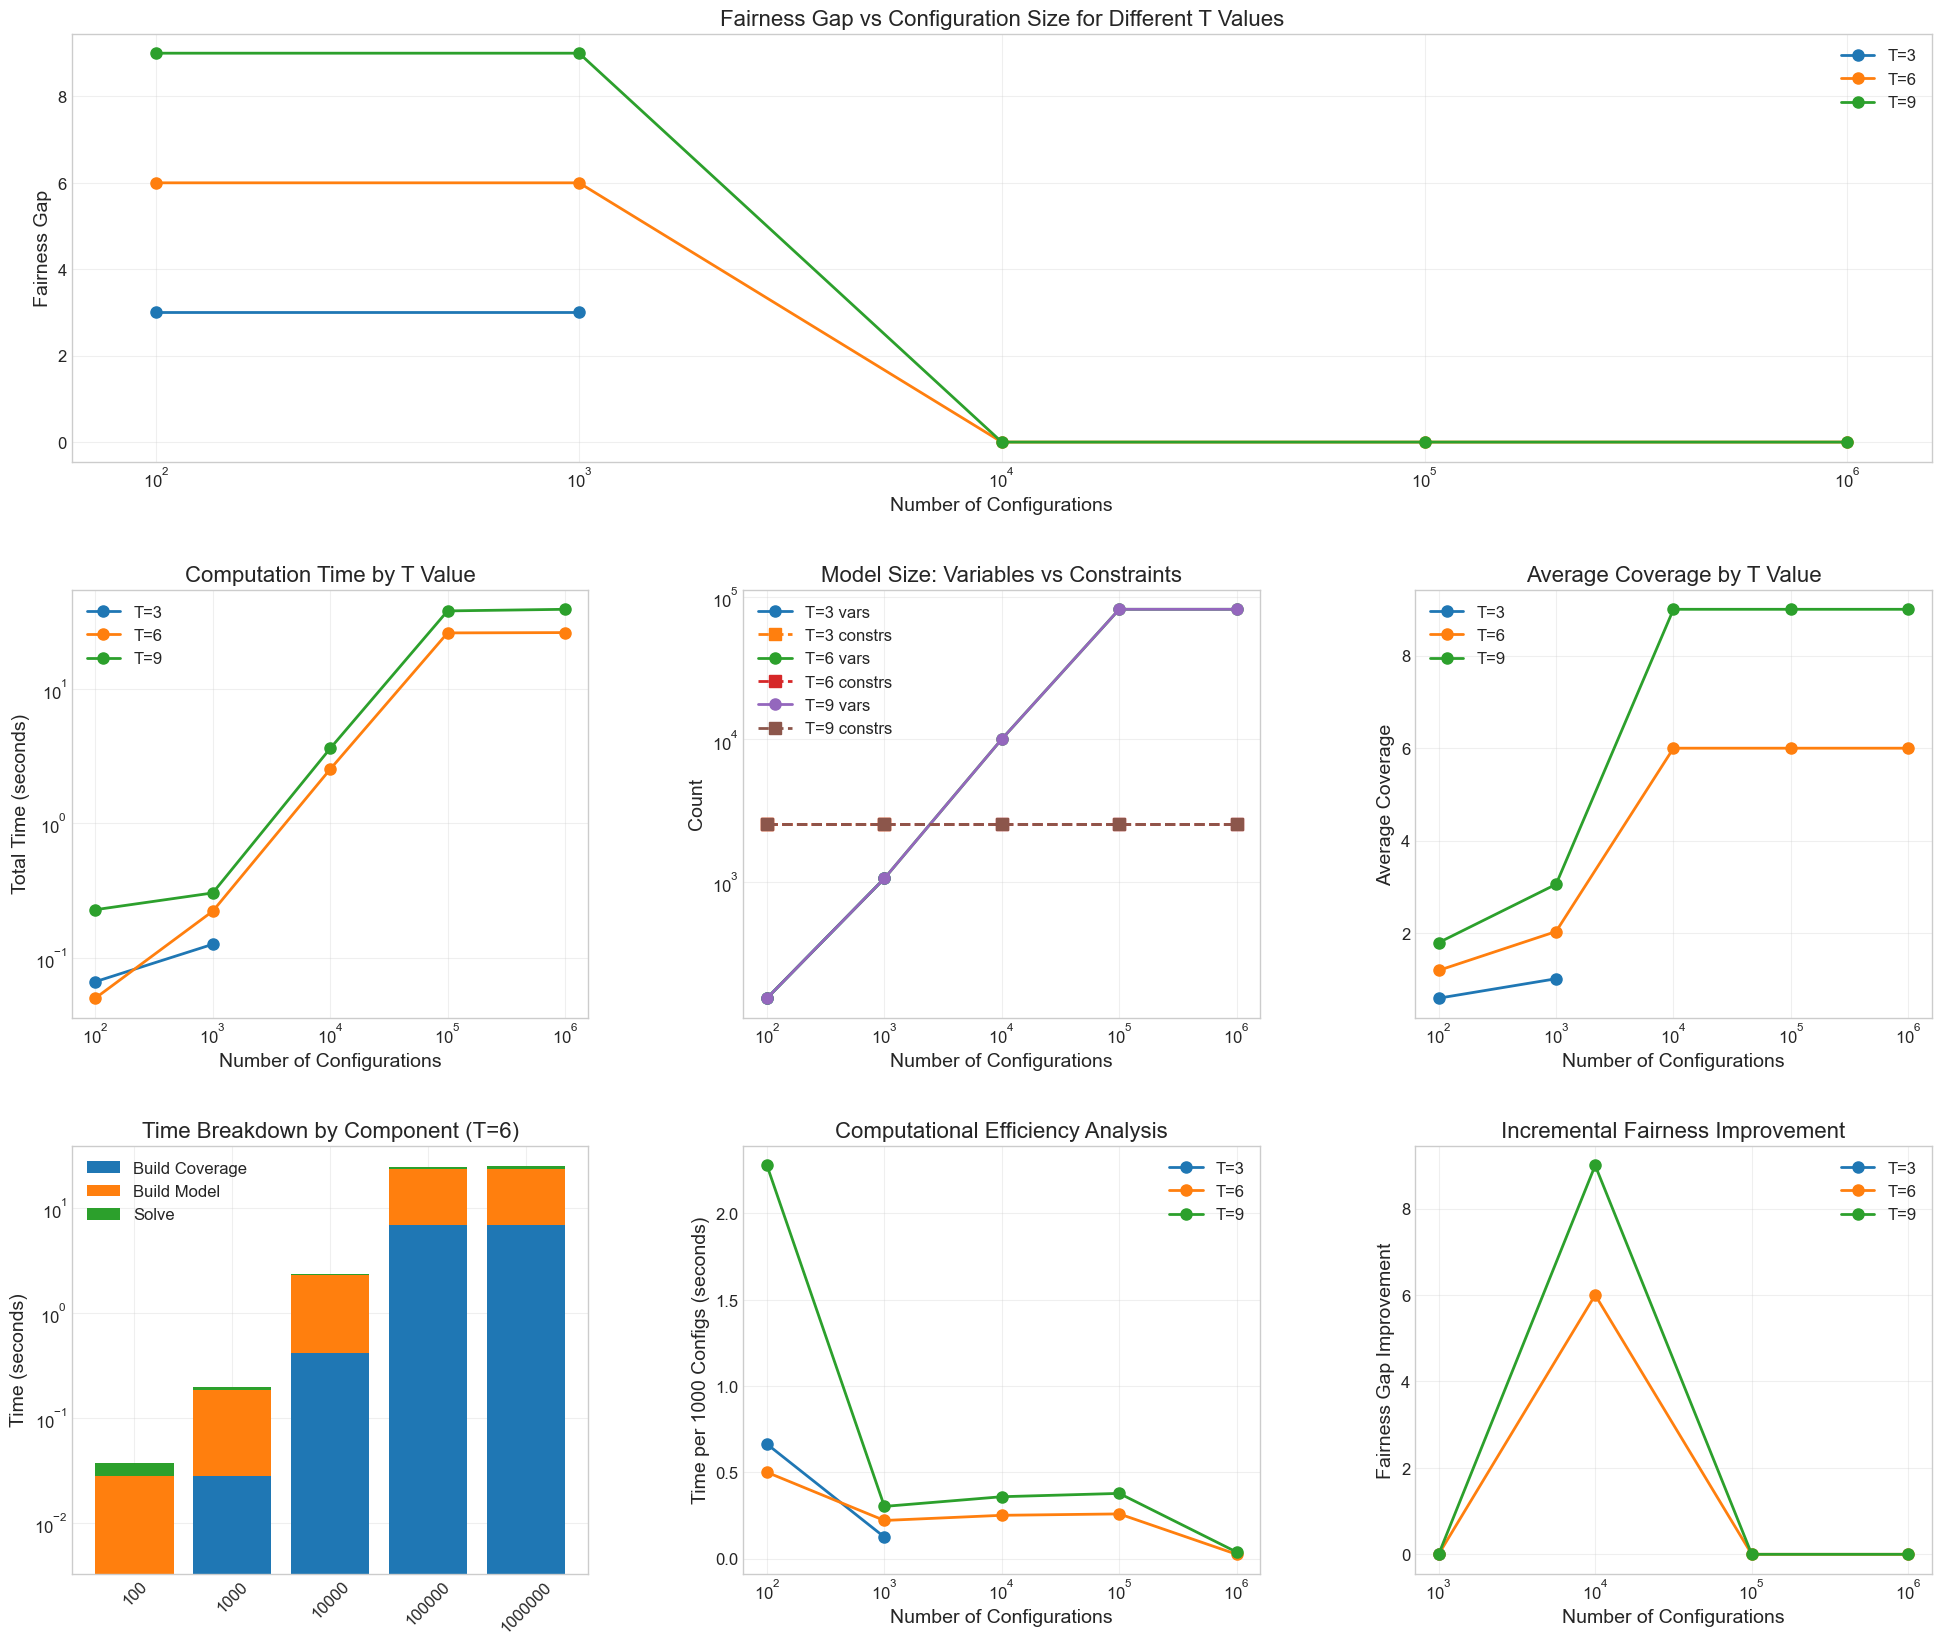

✅ Saved efficiency summary to 'results/Step2/efficiency_summary.csv'


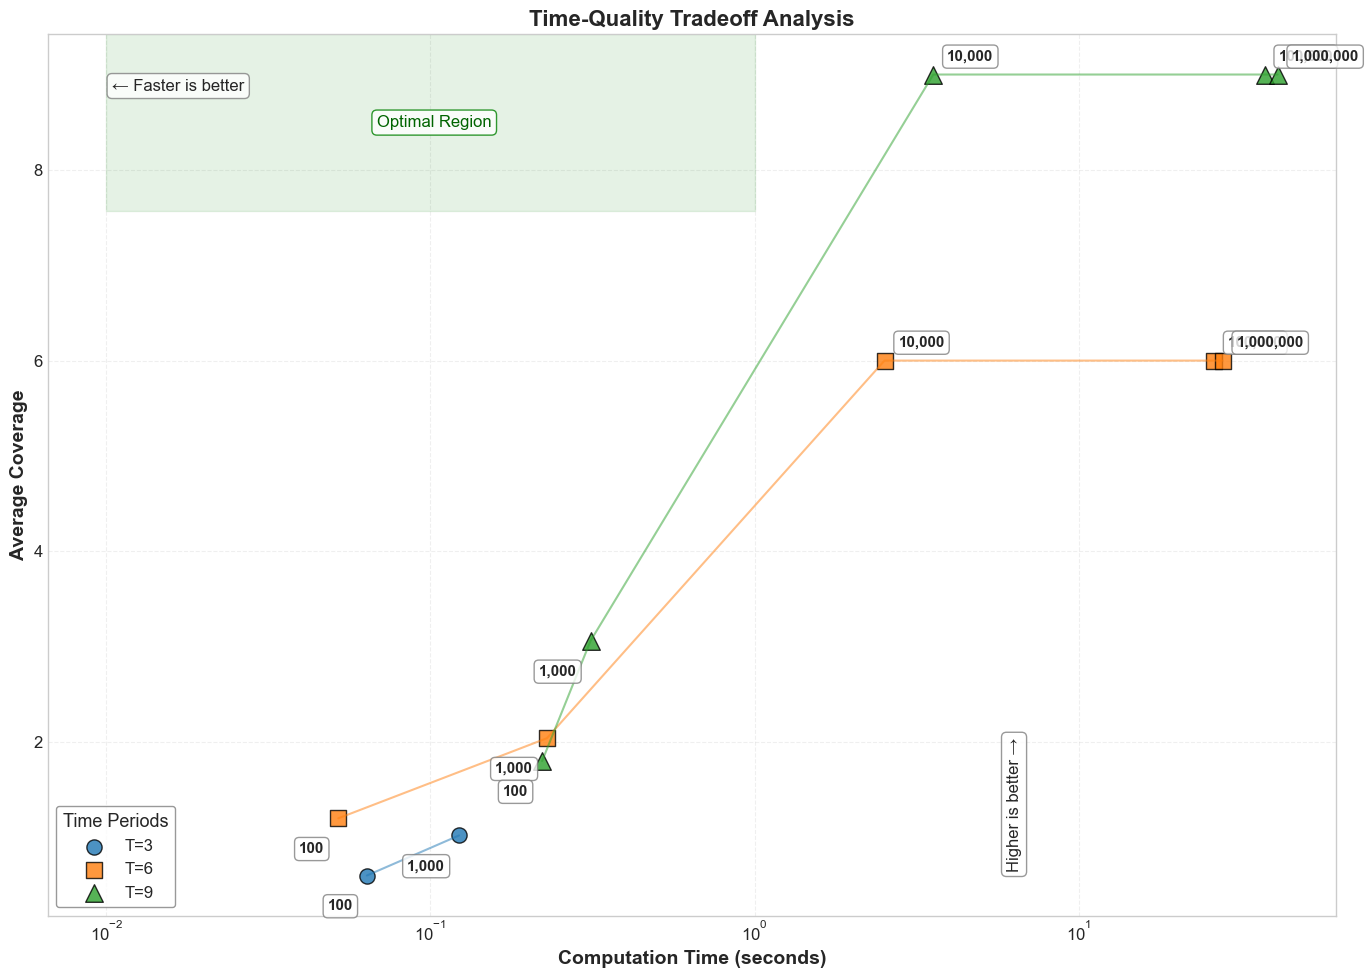

✅ Saved summary table to 'results/Step2/summary_table.csv'

--- Visualization and analysis completed ---


/var/folders/_2/nvq16qmj48g5ggtmz5d52m000000gn/T/ipykernel_85807/167396433.py:225: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_table = pd.concat([summary_table, pd.DataFrame({


In [188]:
# Load data from Part 1
results_dir = "results/Step2"
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    data = pickle.load(f)

# Extract variables
T_VALUES = data['T_VALUES']
BATCH_SIZES = data['BATCH_SIZES']
all_results = data['results']

# Convert results to DataFrame
df_results = pd.DataFrame(all_results)

# --- COMPREHENSIVE VISUALIZATION ---
# Create visualization grid
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Fairness Gap by T and Batch Size
ax1 = fig.add_subplot(gs[0, :])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax1.plot(T_data['batch_size'], T_data['fairness_gap'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Fairness Gap', fontsize=14)
ax1.set_title('Fairness Gap vs Configuration Size for Different T Values', fontsize=16)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Computation Time Comparison
ax2 = fig.add_subplot(gs[1, 0])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax2.plot(T_data['batch_size'], T_data['total_time'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Total Time (seconds)', fontsize=14)
ax2.set_title('Computation Time by T Value', fontsize=16)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Model Size (Variables and Constraints)
ax3 = fig.add_subplot(gs[1, 1])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax3.plot(T_data['batch_size'], T_data['num_variables'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T} vars')
        ax3.plot(T_data['batch_size'], T_data['num_constraints'], 's--', 
                linewidth=2, markersize=8, label=f'T={T} constrs')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_title('Model Size: Variables vs Constraints', fontsize=16)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Coverage Quality Metrics
ax4 = fig.add_subplot(gs[1, 2])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax4.plot(T_data['batch_size'], T_data['avg_coverage'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax4.set_xscale('log')
ax4.set_xlabel('Number of Configurations', fontsize=14)
ax4.set_ylabel('Average Coverage', fontsize=14)
ax4.set_title('Average Coverage by T Value', fontsize=16)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Time Breakdown
ax5 = fig.add_subplot(gs[2, 0])
times_data = df_results[df_results['T'] == 6]  # Example with T=6
if len(times_data) > 0:
    bottom = np.zeros(len(times_data))
    for component, label in [('build_time', 'Build Coverage'),
                            ('model_build_time', 'Build Model'),
                            ('solve_time', 'Solve')]:
        ax5.bar(range(len(times_data)), times_data[component], 
                bottom=bottom, label=label)
        bottom += times_data[component]
    ax5.set_xticks(range(len(times_data)))
    ax5.set_xticklabels(times_data['batch_size'], rotation=45)
    ax5.set_ylabel('Time (seconds)', fontsize=14)
    ax5.set_title(f'Time Breakdown by Component (T=6)', fontsize=16)
    ax5.legend()
    ax5.set_yscale('log')

# Plot 6: Efficiency Analysis (Time per 1000 configurations)
ax6 = fig.add_subplot(gs[2, 1])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        efficiency = T_data['total_time'] / (T_data['batch_size'] / 1000)
        ax6.plot(T_data['batch_size'], efficiency, 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax6.set_xscale('log')
ax6.set_xlabel('Number of Configurations', fontsize=14)
ax6.set_ylabel('Time per 1000 Configs (seconds)', fontsize=14)
ax6.set_title('Computational Efficiency Analysis', fontsize=16)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Fairness Improvement Rate
ax7 = fig.add_subplot(gs[2, 2])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T].sort_values('batch_size')
    if len(T_data) > 1:
        improvement = T_data['fairness_gap'].diff().abs()
        ax7.plot(T_data['batch_size'].iloc[1:], improvement.iloc[1:], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax7.set_xscale('log')
ax7.set_xlabel('Number of Configurations', fontsize=14)
ax7.set_ylabel('Fairness Gap Improvement', fontsize=14)
ax7.set_title('Incremental Fairness Improvement', fontsize=16)
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create efficiency summary
efficiency_summary = []
for T in T_VALUES:
    for batch_size in BATCH_SIZES:
        data = df_results[(df_results['T'] == T) & (df_results['batch_size'] == batch_size)]
        if len(data) > 0:
            efficiency_summary.append({
                'T': T,
                'batch_size': batch_size,
                'fairness_gap': data['fairness_gap'].iloc[0],
                'time_per_1000_configs': data['total_time'].iloc[0] / (batch_size / 1000)
            })

efficiency_df = pd.DataFrame(efficiency_summary)
if len(efficiency_df) > 0:
    efficiency_df.to_csv(os.path.join(results_dir, 'efficiency_summary.csv'), index=False)
    print(f"✅ Saved efficiency summary to '{results_dir}/efficiency_summary.csv'")

# Plot 9: Improved Time vs Coverage Quality
plt.figure(figsize=(14, 10))

# Use different marker styles and sizes for better visibility
markers = ['o', 's', '^']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # More distinct colors
sizes = [120, 140, 160]

for i, T in enumerate(T_VALUES):
    T_data = df_results[df_results['T'] == T].copy()
    if len(T_data) > 0:
        # Create jitter for better visibility
        jitter = np.random.normal(0, 0.05, len(T_data))
        T_data['time_jittered'] = T_data['total_time'] * (1 + jitter)
        
        # Plot with more distinct markers
        plt.scatter(T_data['time_jittered'], T_data['avg_coverage'], 
                  s=sizes[i], alpha=0.8, label=f'T={T}',
                  marker=markers[i], edgecolors='black', linewidths=1)
        
        # Draw connecting lines
        plt.plot(T_data['time_jittered'], T_data['avg_coverage'], '-', 
                color=colors[i], alpha=0.5, linewidth=1.5)
        
        # Annotate points with batch size
        for _, row in T_data.iterrows():
            # Position text strategically based on batch size
            if row['batch_size'] <= 1000:
                xytext = (-10, -25)  # Below
                ha = 'right'
            else:
                xytext = (10, 10)  # Above right
                ha = 'left'
                
            plt.annotate(f"{int(row['batch_size']):,}", 
                       (row['time_jittered'], row['avg_coverage']),
                       xytext=xytext, textcoords='offset points',
                       fontsize=11, fontweight='bold', ha=ha,
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Improve axes and grid
plt.xscale('log')
plt.xlabel('Computation Time (seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Average Coverage', fontsize=14, fontweight='bold')
plt.title('Time-Quality Tradeoff Analysis', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')

# Add a more detailed legend
legend = plt.legend(title="Time Periods", fontsize=12, title_fontsize=13, 
           frameon=True, facecolor='white', edgecolor='gray')

# Add explanatory annotation
plt.annotate("Higher is better →", xy=(0.75, 0.05), xycoords='axes fraction', 
             fontsize=12, ha='center', va='bottom', rotation=90, 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, ha='left', va='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Show "optimal region" - high coverage, low time
plt.axvspan(0.01, 1, ymin=0.8, ymax=1, alpha=0.1, color='green', zorder=1)
plt.annotate("Optimal Region", xy=(0.3, 0.9), xycoords='axes fraction', 
             fontsize=12, ha='center', va='center', color='darkgreen',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_time_quality_tradeoff.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create summary table for report
summary_table = pd.DataFrame(columns=['T', 'Best Batch Size', 'Best Fairness Gap', 
                                     'Avg Coverage', 'Computation Time (s)'])

for T in T_VALUES:
    best_row = df_results[df_results['T'] == T].nsmallest(1, 'fairness_gap')
    if len(best_row) > 0:
        summary_table = pd.concat([summary_table, pd.DataFrame({
            'T': [T],
            'Best Batch Size': [int(best_row['batch_size'].iloc[0])],
            'Best Fairness Gap': [best_row['fairness_gap'].iloc[0]],
            'Avg Coverage': [best_row['avg_coverage'].iloc[0]],
            'Computation Time (s)': [best_row['total_time'].iloc[0]]
        })])

summary_table.to_csv(os.path.join(results_dir, 'summary_table.csv'), index=False)
print(f"✅ Saved summary table to '{results_dir}/summary_table.csv'")
print("\n--- Visualization and analysis completed ---")

# STEP 3 >>> Implement binarization - Define a reasonable upper bound (T+1) for how many times a configuration can occur (like 3, 5, 10, etc.), implement the unary expansion technique, and compare this formulation with the original model in terms of: 
#### Number of variables, Solution quality, Computation time


#### For Binarization

	•	The key insight in your binarization technique is transforming integer variables Q (representing how many times a configuration occurs) into binary variables using:
	•	Q = 0×Z₀ + 1×Z₁ + 2×Z₂ + ... + T×Zₜ
	•	With the constraint: Z₀ + Z₁ + Z₂ + ... + Zₜ = 1 (exactly one binary variable is selected)

### STEP 3 - Part 1: Processing and Optimization with Binarization

In [189]:
# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Create results directory
results_dir = "results/Step3"
os.makedirs(results_dir, exist_ok=True)

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 5  # A configuration can occur 0-5 times

# Load license parameters
license_path = "data/gurobi.lic"
params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)  # Convert LICENSEID to int
            else:
                params[key] = value

# Check that license parameters were loaded
print("License parameters:")
print(params)

# --- LOAD GRAPH ---
# Create environment with license params
env = gp.Env(params=params)
model_binary = gp.Model(env=env)
model_unary = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# --- LOAD CONFIGURATIONS - MODIFIED TO LOAD ALL CONFIGURATIONS ---
print(f"Loading all configurations from {os.path.join(CONFIG_DIR, 'configurations.csv')}...")

# Load the full configurations file
try:
    # Try to load from pickle first (faster)
    with open(os.path.join(CONFIG_DIR, "configurations.pkl"), "rb") as f:
        all_configurations = pickle.load(f)
    print(f"Loaded {len(all_configurations)} configurations from pickle file")
except:
    # If pickle fails, load from CSV
    df_all = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv"))
    all_configurations = []
    for _, row in df_all.iterrows():
        config = []
        for i in range(len(base_coords)):
            config.append(int(row[f"base{i}_ambulances"]))
        all_configurations.append(tuple(config))
    print(f"Loaded {len(all_configurations)} configurations from CSV file")

# For initial model testing, use a smaller subset
NUM_CONFIGS = 1000
configurations = all_configurations[:NUM_CONFIGS]
print(f"Using first {len(configurations)} configurations for initial model testing")
print(f"First 3 configurations: {configurations[:3]}")

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
b = {}
for c_idx, config in enumerate(configurations):
    for base_idx, num_ambulances in enumerate(config):
        if num_ambulances > 0:
            base_zone = base_coords[base_idx]
            coverage = {base_zone} | adjacency.get(base_zone, set())
            for t in range(T):
                for z in coverage:
                    b[(z, t, c_idx)] = 1

# --- BINARY SELECTION MODEL (MAX=1) ---
# Variables
λ_binary = model_binary.addVars(NUM_CONFIGS, vtype=GRB.BINARY, name="lambda_binary")
y_binary = model_binary.addVars(zones, vtype=GRB.INTEGER, name="y_binary")  
z_binary = model_binary.addVar(vtype=GRB.INTEGER, name="z_binary")

# Constraints
model_binary.addConstr(gp.quicksum(λ_binary[c] for c in range(NUM_CONFIGS)) == 1, "select_one_config_binary")

for i in zones:
    model_binary.addConstr(
        y_binary[i] == gp.quicksum(b.get((i, t, c), 0) * λ_binary[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binary_{i}"
    )

for i in zones:
    for j in zones:
        model_binary.addConstr(z_binary >= y_binary[i] - y_binary[j], f"fair_binary_{i}_{j}")

model_binary.setObjective(z_binary, GRB.MINIMIZE)

# --- UNARY EXPANSION MODEL ---
# Variables
# Z[c, k]: binary variable indicating if configuration c occurs k times
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_unary.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

# q[c]: integer variable representing how many times configuration c occurs
q = model_unary.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

y_unary = model_unary.addVars(zones, vtype=GRB.INTEGER, name="y_unary")
z_unary = model_unary.addVar(vtype=GRB.INTEGER, name="z_unary")

# Constraints
# One-hot constraint: Each configuration occurs exactly once with some frequency
for c in range(NUM_CONFIGS):
    model_unary.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# Link q to Z: q[c] = sum(k * Z[c,k])
for c in range(NUM_CONFIGS):
    model_unary.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# Total ambulance count constraint
model_unary.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_unary"
)

# Coverage constraints
for i in zones:
    model_unary.addConstr(
        y_unary[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_unary_{i}"
    )

# Fairness constraints
for i in zones:
    for j in zones:
        model_unary.addConstr(z_unary >= y_unary[i] - y_unary[j], f"fair_unary_{i}_{j}")

model_unary.setObjective(z_unary, GRB.MINIMIZE)

# --- SOLVE BOTH MODELS AND COMPARE ---
print("\nSolving binary selection model (Max=1)...")
start_binary = time.time()
model_binary.optimize()
time_binary = time.time() - start_binary

print("\nSolving unary expansion model (Max=5)...")
start_unary = time.time()
model_unary.optimize()
time_unary = time.time() - start_unary

# --- RESULTS COMPARISON ---
print("\n=== COMPARISON RESULTS ===")
print(f"{'Metric':<25} | {'Binary Selection':<20} | {'Unary Expansion':<20}")
print("-" * 70)
print(f"{'Number of Variables':<25} | {model_binary.numVars:<20} | {model_unary.numVars:<20}")
print(f"{'Number of Constraints':<25} | {model_binary.numConstrs:<20} | {model_unary.numConstrs:<20}")
print(f"{'Objective Value':<25} | {model_binary.objVal:<20.2f} | {model_unary.objVal:<20.2f}")
print(f"{'Solve Time (seconds)':<25} | {time_binary:<20.2f} | {time_unary:<20.2f}")

print("\n=== SELECTED CONFIGURATION FREQUENCIES ===")
print("Binary Selection Model (Max=1):")
selected_binary = [(c, λ_binary[c].X) for c in range(NUM_CONFIGS) if λ_binary[c].X > 0.5]
print(f"Number of selected configs: {len(selected_binary)}")

print("\nUnary Expansion Model (Max=5):")
selected_unary = [(c, int(q[c].X)) for c in range(NUM_CONFIGS) if q[c].X > 0.5]
print(f"Number of configurations with frequency > 0: {len(selected_unary)}")
for c, freq in selected_unary:
    print(f"  Config {c}: {freq} times")

# --- SCALING ANALYSIS WITH ALL CONFIGURATIONS ---
# Test with different config sizes and MAX_CONFIG_FREQUENCY values
scaling_results = []

# Get the total number of available configurations
TOTAL_CONFIGS = len(all_configurations)
print(f"\n✅ Total configurations available for scaling analysis: {TOTAL_CONFIGS}")

# Generate 8 evenly spaced configuration sizes
num_intervals = 8
config_sizes = [int(size) for size in np.linspace(100, TOTAL_CONFIGS, num_intervals)]
config_sizes = sorted(list(set(config_sizes)))  # Remove any duplicates and sort
print(f"Testing configuration sizes: {config_sizes}")

frequency_bounds = [3, 5, 7]

for size in config_sizes:
    for freq_bound in frequency_bounds:
        print(f"\nTesting with {size} configurations and max frequency {freq_bound}")
        # Reset models with new environment to avoid license issues
        scale_env = gp.Env(params=params)  # Use the same license parameters
        model_binary_scale = gp.Model(env=scale_env)
        model_unary_scale = gp.Model(env=scale_env)
        
        # Use subset of all configurations
        configs_subset = all_configurations[:size]
        
        # Build coverage matrix
        b_subset = {}
        for c_idx, config in enumerate(configs_subset):
            for base_idx, num_ambulances in enumerate(config):
                if num_ambulances > 0:
                    base_zone = base_coords[base_idx]
                    coverage = {base_zone} | adjacency.get(base_zone, set())
                    for t in range(T):
                        for z in coverage:
                            b_subset[(z, t, c_idx)] = 1
        
        # Binary Selection model
        λ_scale = model_binary_scale.addVars(size, vtype=GRB.BINARY, name="lambda")
        y_scale = model_binary_scale.addVars(zones, vtype=GRB.INTEGER, name="y")
        z_scale = model_binary_scale.addVar(vtype=GRB.INTEGER, name="z")
        
        model_binary_scale.addConstr(gp.quicksum(λ_scale[c] for c in range(size)) == 1)
        
        for i in zones:
            model_binary_scale.addConstr(
                y_scale[i] == gp.quicksum(b_subset.get((i, t, c), 0) * λ_scale[c] for c in range(size) for t in range(T))
            )
        
        for i in zones:
            for j in zones:
                model_binary_scale.addConstr(z_scale >= y_scale[i] - y_scale[j])
        
        model_binary_scale.setObjective(z_scale, GRB.MINIMIZE)
        
        # Unary Expansion model
        Z_scale = {}
        for c in range(size):
            for k in range(freq_bound + 1):
                Z_scale[c, k] = model_unary_scale.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")
        
        q_scale = model_unary_scale.addVars(size, vtype=GRB.INTEGER, name="q")
        y_scale_unary = model_unary_scale.addVars(zones, vtype=GRB.INTEGER, name="y")
        z_scale_unary = model_unary_scale.addVar(vtype=GRB.INTEGER, name="z")
        
        for c in range(size):
            model_unary_scale.addConstr(gp.quicksum(Z_scale[c, k] for k in range(freq_bound + 1)) == 1)
            model_unary_scale.addConstr(q_scale[c] == gp.quicksum(k * Z_scale[c, k] for k in range(freq_bound + 1)))
        
        model_unary_scale.addConstr(gp.quicksum(q_scale[c] for c in range(size)) == NUM_AMBULANCES)
        
        for i in zones:
            model_unary_scale.addConstr(
                y_scale_unary[i] == gp.quicksum(b_subset.get((i, t, c), 0) * q_scale[c] for c in range(size) for t in range(T))
            )
        
        for i in zones:
            for j in zones:
                model_unary_scale.addConstr(z_scale_unary >= y_scale_unary[i] - y_scale_unary[j])
        
        model_unary_scale.setObjective(z_scale_unary, GRB.MINIMIZE)
        
        # Solve and record results
        try:
            start_binary = time.time()
            model_binary_scale.optimize()
            time_binary = time.time() - start_binary
            obj_binary = model_binary_scale.objVal if model_binary_scale.status == GRB.OPTIMAL else float('nan')
            
            start_unary = time.time()
            model_unary_scale.optimize()
            time_unary = time.time() - start_unary
            obj_unary = model_unary_scale.objVal if model_unary_scale.status == GRB.OPTIMAL else float('nan')
            
            scaling_results.append({
                'config_size': size,
                'freq_bound': freq_bound,
                'orig_vars': model_binary_scale.numVars,
                'bin_vars': model_unary_scale.numVars,
                'orig_constrs': model_binary_scale.numConstrs,
                'bin_constrs': model_unary_scale.numConstrs,
                'orig_time': time_binary,
                'bin_time': time_unary,
                'orig_obj': obj_binary,
                'bin_obj': obj_unary
            })
            print(f"  ✅ Success - Binary Selection: {time_binary:.2f}s, Unary Expansion: {time_unary:.2f}s")
        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            scaling_results.append({
                'config_size': size,
                'freq_bound': freq_bound,
                'orig_vars': model_binary_scale.numVars,
                'bin_vars': model_unary_scale.numVars,
                'orig_constrs': model_binary_scale.numConstrs,
                'bin_constrs': model_unary_scale.numConstrs,
                'orig_time': float('nan'),
                'bin_time': float('nan'),
                'orig_obj': float('nan'),
                'bin_obj': float('nan')
            })
        
        # Clean up for this iteration
        model_binary_scale.dispose()
        model_unary_scale.dispose()
        scale_env.dispose()

# Convert to DataFrame for better visualization
scaling_df = pd.DataFrame(scaling_results)
scaling_df.to_csv(os.path.join(results_dir, 'binarization_scaling.csv'), index=False)

# Save data for visualization
visualization_data = {
    'config_sizes': config_sizes,
    'frequency_bounds': frequency_bounds,
    'scaling_results': scaling_results
}

with open(os.path.join(results_dir, 'visualization_data.pkl'), 'wb') as f:
    pickle.dump(visualization_data, f)
print(f"\n✅ Saved visualization data to '{results_dir}/visualization_data.pkl'")

# Clean up
model_binary.dispose()
model_unary.dispose()
env.dispose()

License parameters:
{'WLSACCESSID': '5cec81c9-a70e-4689-9487-28f5a1553f93', 'WLSSECRET': 'b583cde1-579c-4eb4-807e-d13bbe6446d7', 'LICENSEID': 2659300}
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Number of zones: 50
Number of bases: 5
Loading all configurations from ./configurations/50/50-3004-6-7-35_allocations/configurations.csv...
Loaded 82251 configurations from pickle file
Using first 1000 configurations for initial model testing
First 3 configurations: [(0, 0, 0, 0, 35), (0, 0, 0, 1, 34), (0, 0, 0, 2, 33)]

Solving binary selection model (Max=1)...
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 255

### STEP 3 - Part 2: Visualization and Analysis for Binarization

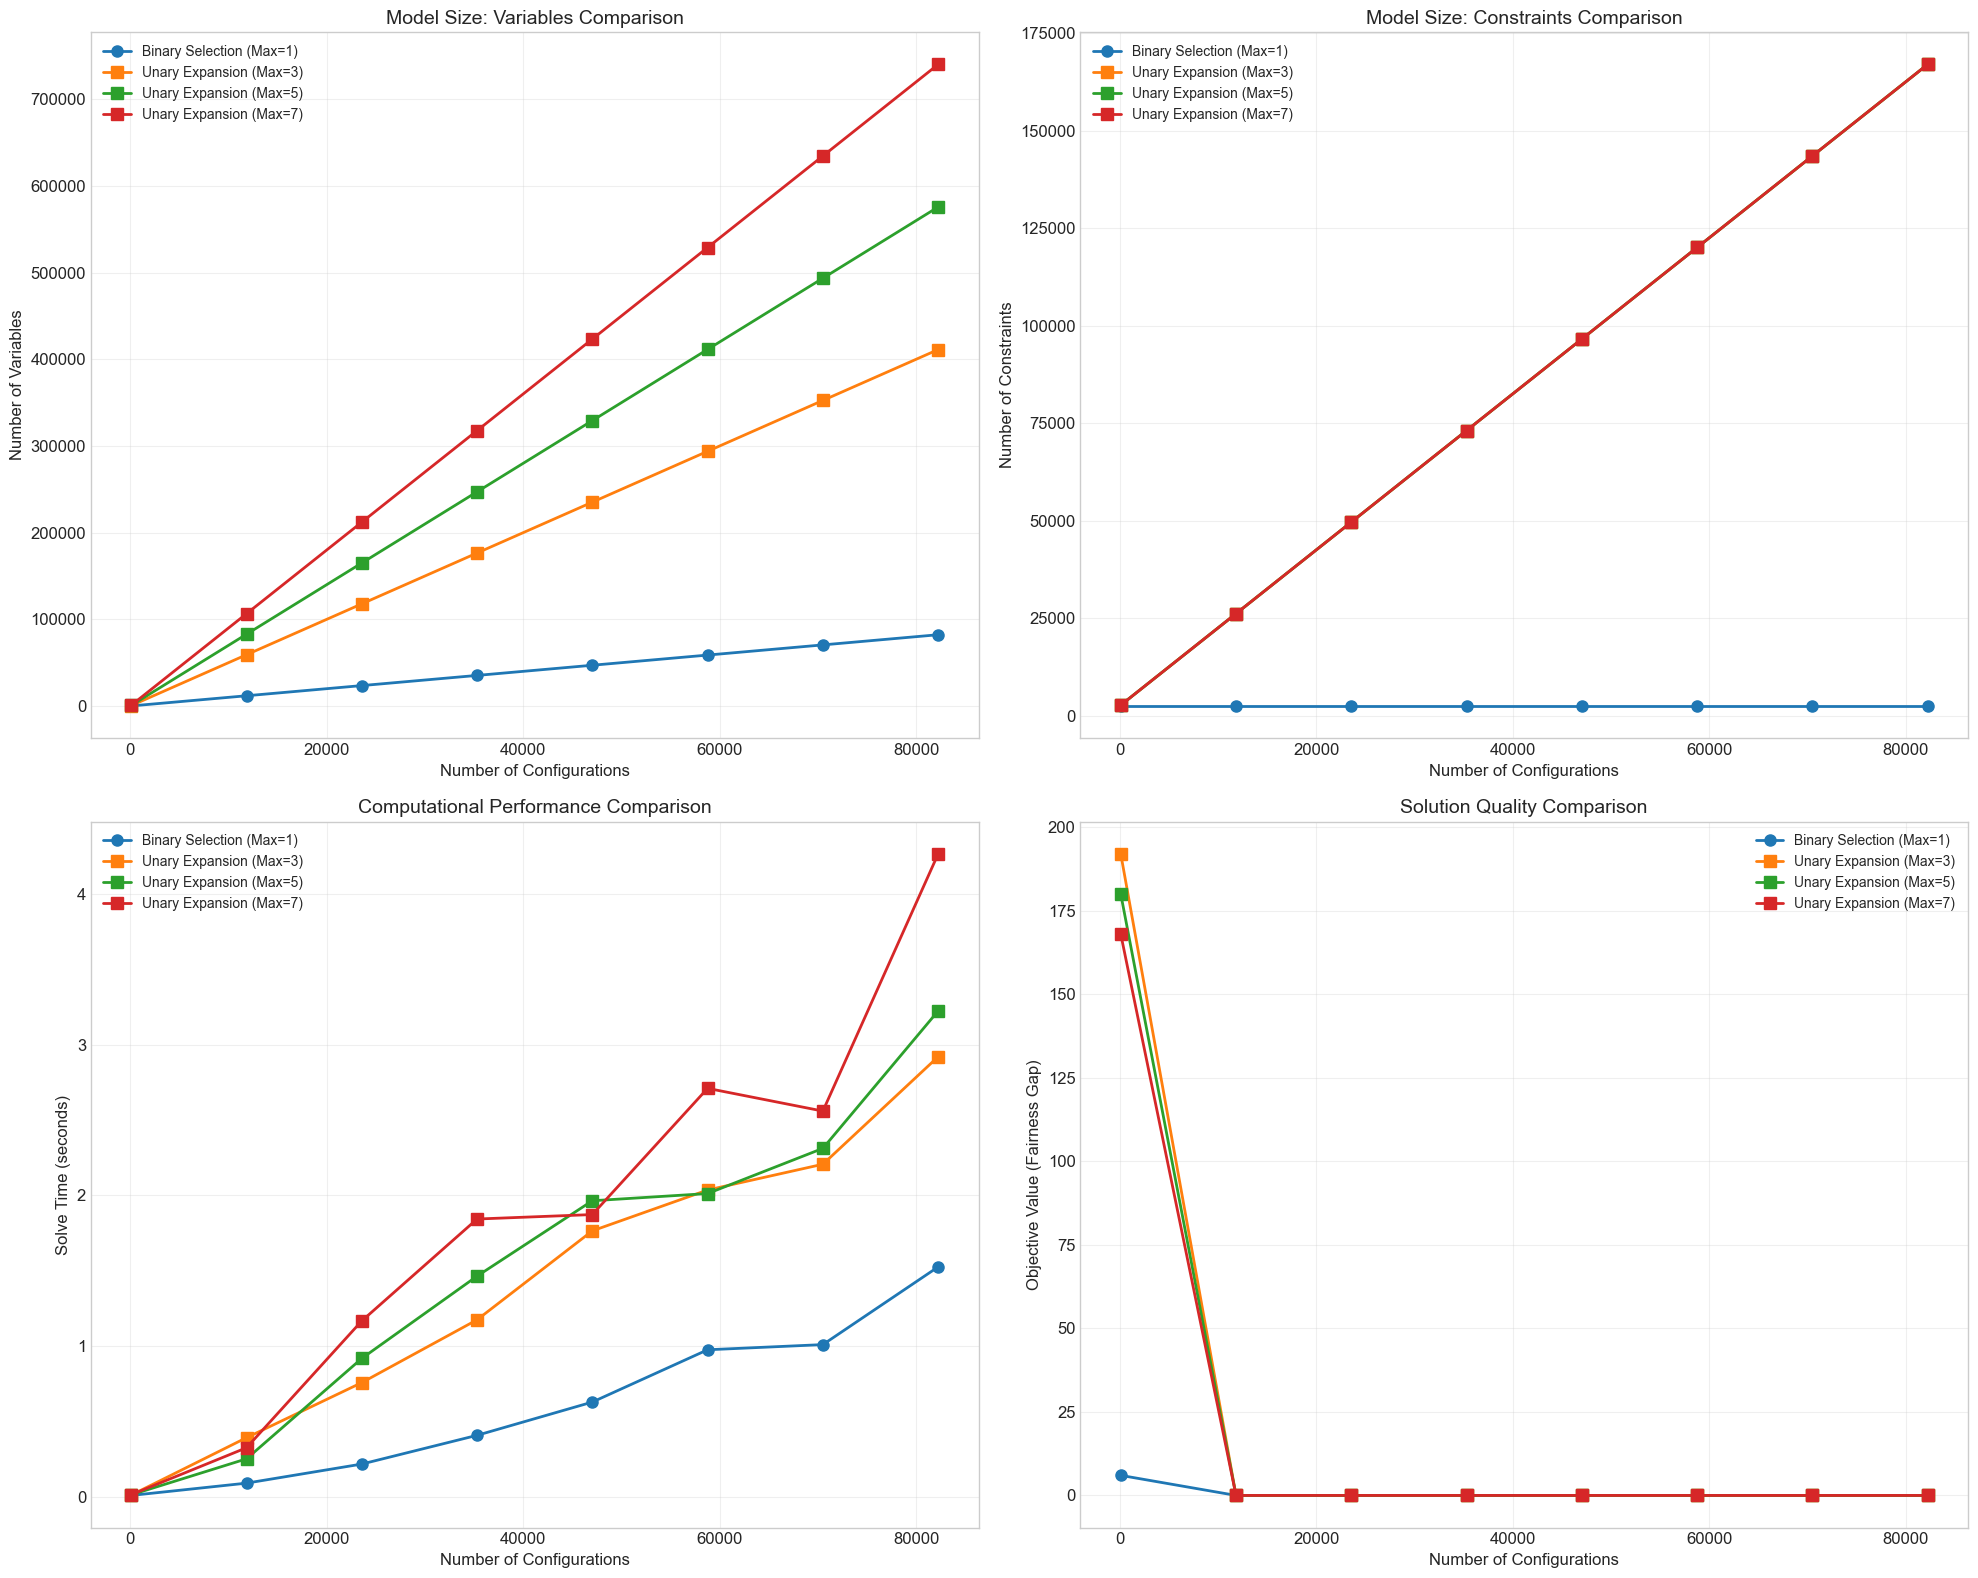


=== SCALING ANALYSIS SUMMARY ===
 config_size  freq_bound  orig_vars  bin_vars  orig_constrs  bin_constrs  orig_time  bin_time  orig_obj  bin_obj
         100           3        151       551          2551         2751   0.008424  0.010871       6.0    192.0
         100           5        151       751          2551         2751   0.008371  0.012708       6.0    180.0
         100           7        151       951          2551         2751   0.008156  0.013417       6.0    168.0
       11835           3      11886     59226          2551        26221   0.089963  0.391644       0.0      0.0
       11835           5      11886     82896          2551        26221   0.086269  0.251299       0.0      0.0

=== KEY INSIGHTS ===
Variable increase factor (Unary Expansion vs Binary Selection): 6.99x
Constraint increase factor (Unary Expansion vs Binary Selection): 33.28x
Average solve time ratio (Unary Expansion/Binary Selection): 2.82x
Unary Expansion did not improve solution quality compare

In [190]:
# Create results directory
results_dir = "results/Step3"
os.makedirs(results_dir, exist_ok=True)

# Load data for visualization
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    visualization_data = pickle.load(f)

config_sizes = visualization_data['config_sizes']
frequency_bounds = visualization_data['frequency_bounds']
scaling_results = visualization_data['scaling_results']

# Convert to DataFrame for visualization
scaling_df = pd.DataFrame(scaling_results)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Variables comparison
# Group by config_size to get binary selection model data once
binary_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_vars']]
binary_data = binary_data.sort_values('config_size')
axes[0,0].plot(binary_data['config_size'], binary_data['orig_vars'], 'o-', 
               label='Binary Selection (Max=1)', linewidth=2, markersize=8)

# Plot unary expansion data for each frequency
for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[0,0].plot(subset['config_size'], subset['bin_vars'], 's-', 
                   label=f'Unary Expansion (Max={freq})', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Configurations', fontsize=12)
axes[0,0].set_ylabel('Number of Variables', fontsize=12)
axes[0,0].set_title('Model Size: Variables Comparison', fontsize=14)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Constraints comparison
binary_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_constrs']]
binary_data = binary_data.sort_values('config_size')
axes[0,1].plot(binary_data['config_size'], binary_data['orig_constrs'], 'o-',
               label='Binary Selection (Max=1)', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[0,1].plot(subset['config_size'], subset['bin_constrs'], 's-', 
                   label=f'Unary Expansion (Max={freq})', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Number of Configurations', fontsize=12)
axes[0,1].set_ylabel('Number of Constraints', fontsize=12)
axes[0,1].set_title('Model Size: Constraints Comparison', fontsize=14)
axes[0,1].legend(fontsize=10)
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Solve time comparison
binary_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_time']]
binary_data = binary_data.sort_values('config_size')
axes[1,0].plot(binary_data['config_size'], binary_data['orig_time'], 'o-',
               label='Binary Selection (Max=1)', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[1,0].plot(subset['config_size'], subset['bin_time'], 's-', 
                   label=f'Unary Expansion (Max={freq})', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Number of Configurations', fontsize=12)
axes[1,0].set_ylabel('Solve Time (seconds)', fontsize=12)
axes[1,0].set_title('Computational Performance Comparison', fontsize=14)
axes[1,0].legend(fontsize=10)
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Objective value comparison
binary_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_obj']]
binary_data = binary_data.sort_values('config_size')
axes[1,1].plot(binary_data['config_size'], binary_data['orig_obj'], 'o-',
               label='Binary Selection (Max=1)', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[1,1].plot(subset['config_size'], subset['bin_obj'], 's-', 
                   label=f'Unary Expansion (Max={freq})', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Number of Configurations', fontsize=12)
axes[1,1].set_ylabel('Objective Value (Fairness Gap)', fontsize=12)
axes[1,1].set_title('Solution Quality Comparison', fontsize=14)
axes[1,1].legend(fontsize=10)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'binarization_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- SUMMARY STATISTICS ---
print("\n=== SCALING ANALYSIS SUMMARY ===")
print(scaling_df.head().to_string(index=False))

# Calculate ratios only for valid data
valid_rows = scaling_df.dropna()
if len(valid_rows) > 0:
    var_ratio = valid_rows['bin_vars'].mean() / valid_rows['orig_vars'].mean()
    constr_ratio = valid_rows['bin_constrs'].mean() / valid_rows['orig_constrs'].mean()
    time_ratio = (valid_rows['bin_time'] / valid_rows['orig_time']).mean()

    print("\n=== KEY INSIGHTS ===")
    print(f"Variable increase factor (Unary Expansion vs Binary Selection): {var_ratio:.2f}x")
    print(f"Constraint increase factor (Unary Expansion vs Binary Selection): {constr_ratio:.2f}x")
    print(f"Average solve time ratio (Unary Expansion/Binary Selection): {time_ratio:.2f}x")

    # Check if binarized model improved solution quality
    orig_obj_mean = valid_rows['orig_obj'].mean()
    bin_obj_mean = valid_rows['bin_obj'].mean()
    if bin_obj_mean < orig_obj_mean:
        improvement = (orig_obj_mean - bin_obj_mean) / orig_obj_mean * 100
        print(f"Unary Expansion improved solution quality by {improvement:.2f}% compared to Binary Selection")
    else:
        print("Unary Expansion did not improve solution quality compared to Binary Selection")
else:
    print("\n=== KEY INSIGHTS ===")
    print("Not enough valid data to calculate ratios")

### STEP 3 - Part 3: Advanced Analysis for All Models

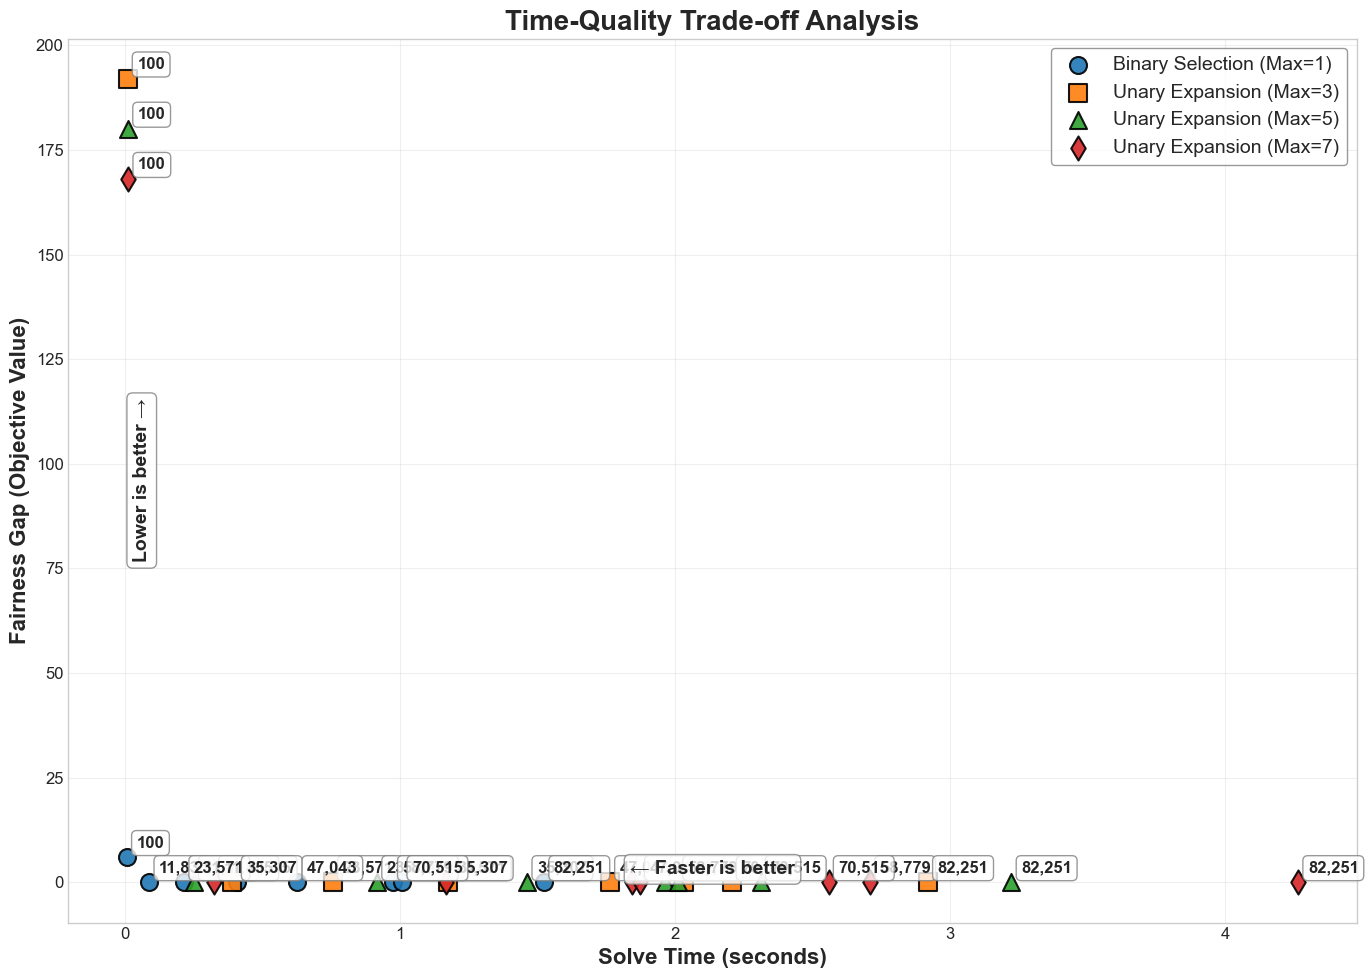

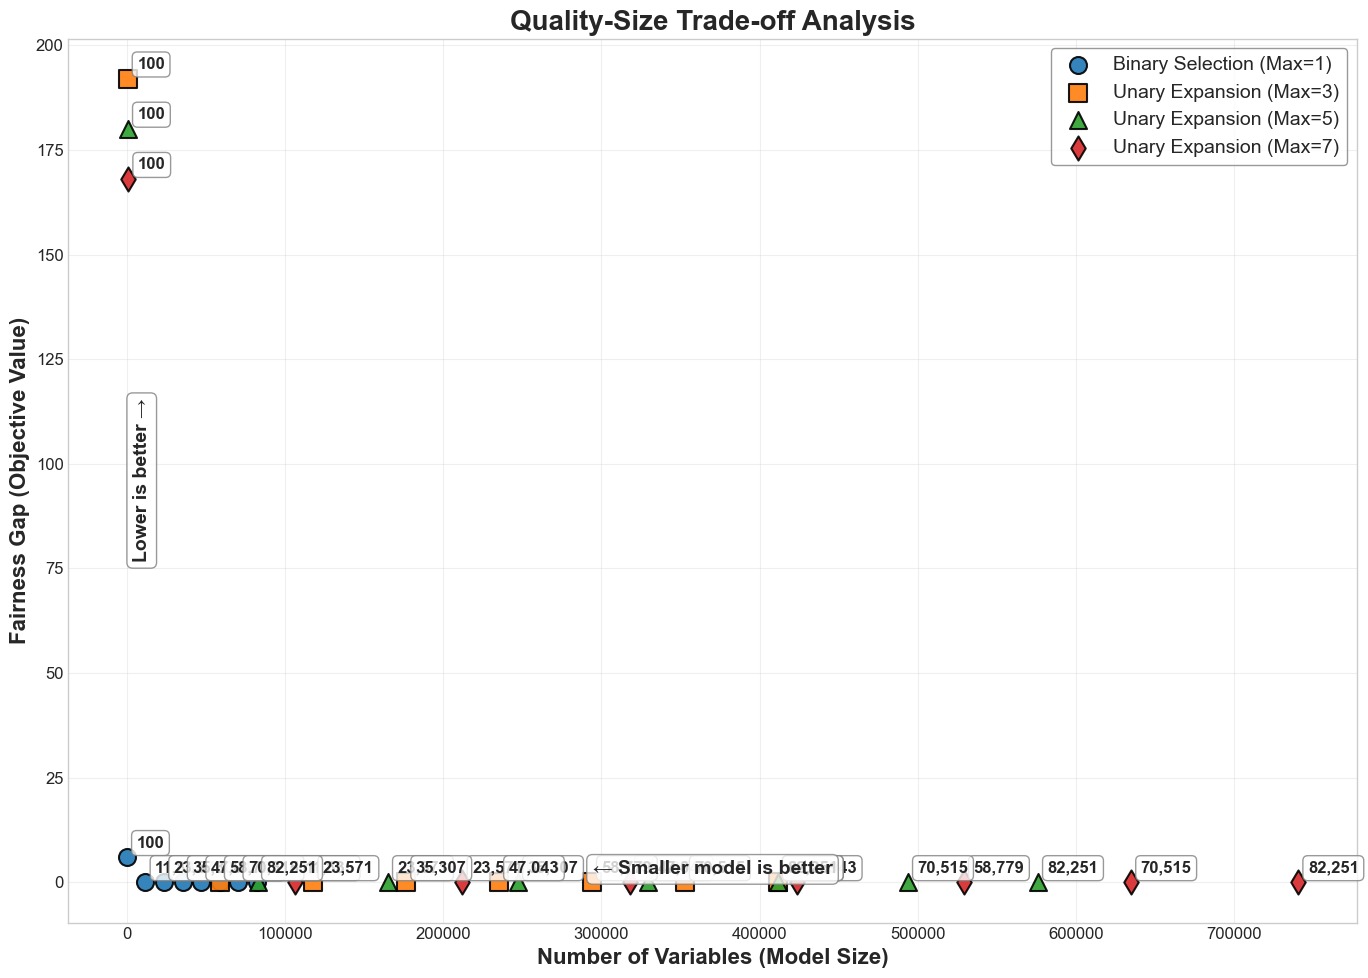

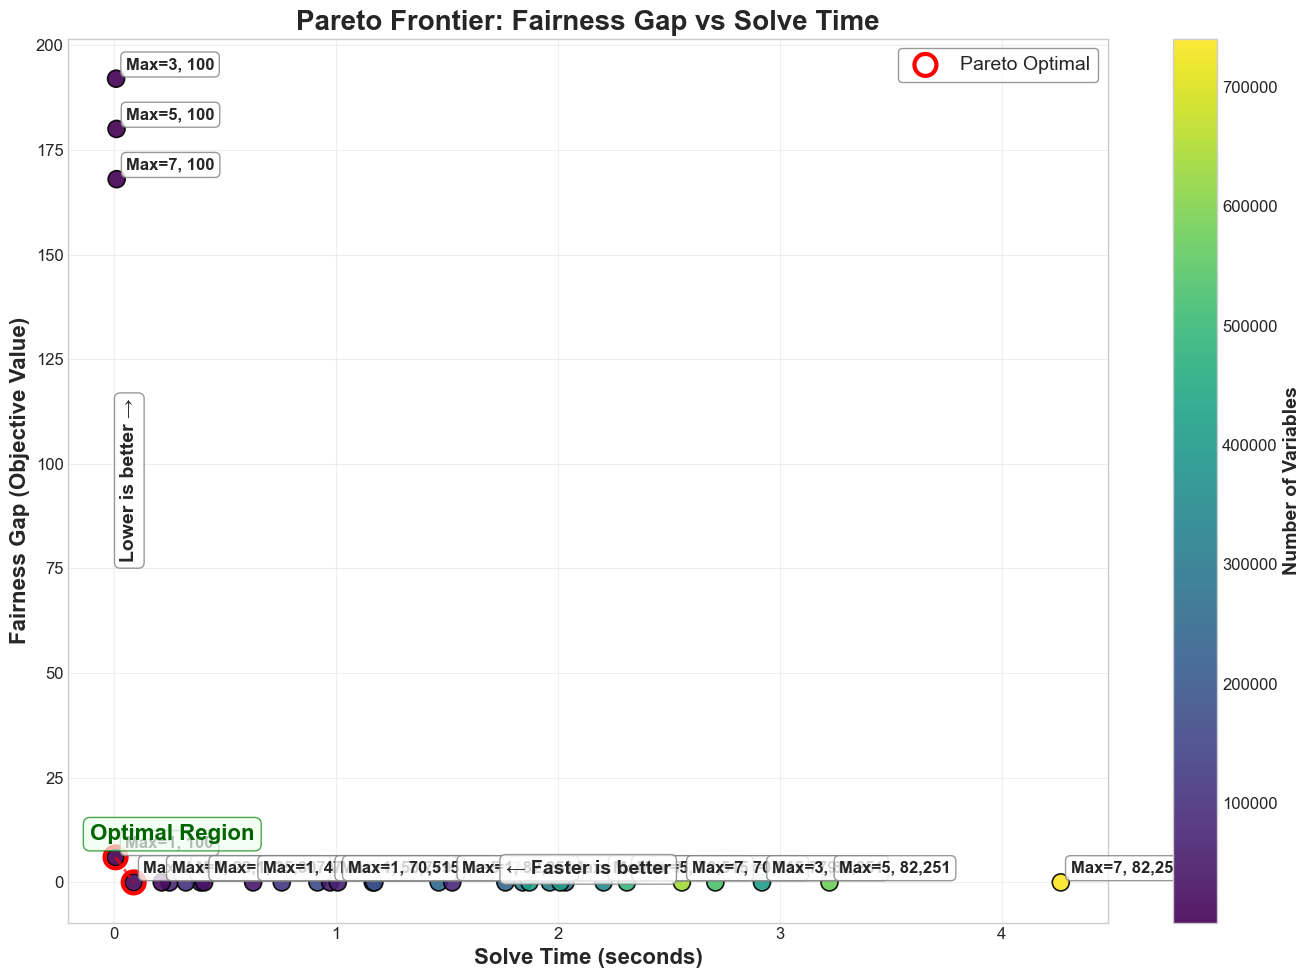


=== PARETO-OPTIMAL SOLUTIONS ===
These solutions offer the best trade-offs between fairness gap and solve time:
 Config Size               Model Type  Fairness Gap  Solve Time (s)  Variables
         100 Binary Selection (Max=1)           6.0        0.008424      151.0
       11835 Binary Selection (Max=1)           0.0        0.089963    11886.0


In [191]:
# Set the style for better readability
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.3

# Create results directory
results_dir = "results/Step3"
os.makedirs(results_dir, exist_ok=True)

# Load data for visualization
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    visualization_data = pickle.load(f)

config_sizes = visualization_data['config_sizes']
frequency_bounds = visualization_data['frequency_bounds']
scaling_results = visualization_data['scaling_results']

# Convert to DataFrame for visualization
scaling_df = pd.DataFrame(scaling_results)

# Create summary dataframe for plotting
summary_data = []

# Process Binary Selection model data
for config_size in config_sizes:
    binary_rows = scaling_df[(scaling_df['config_size'] == config_size)]
    if len(binary_rows) > 0:
        binary_row = binary_rows.iloc[0]
        summary_data.append({
            'Config Size': config_size,
            'Model Type': 'Binary Selection (Max=1)',
            'Fairness Gap': binary_row['orig_obj'],
            'Solve Time (s)': binary_row['orig_time'],
            'Variables': binary_row['orig_vars'],
            'Constraints': binary_row['orig_constrs']
        })
    
        # Process Unary Expansion model data for each frequency bound
        for freq in frequency_bounds:
            try:
                unary_rows = scaling_df[(scaling_df['config_size'] == config_size) & 
                                      (scaling_df['freq_bound'] == freq)]
                if len(unary_rows) > 0:
                    unary_row = unary_rows.iloc[0]
                    summary_data.append({
                        'Config Size': config_size,
                        'Model Type': f'Unary Expansion (Max={freq})',
                        'Fairness Gap': unary_row['bin_obj'],
                        'Solve Time (s)': unary_row['bin_time'],
                        'Variables': unary_row['bin_vars'],
                        'Constraints': unary_row['bin_constrs']
                    })
            except Exception as e:
                print(f"Error processing config size {config_size} with freq {freq}: {str(e)}")

summary_df = pd.DataFrame(summary_data)

# Improved color and marker schemes
model_colors = {
    'Binary Selection (Max=1)': '#1f77b4',  # Blue
    'Unary Expansion (Max=3)': '#ff7f0e',   # Orange
    'Unary Expansion (Max=5)': '#2ca02c',   # Green
    'Unary Expansion (Max=7)': '#d62728'    # Red
}

model_markers = {
    'Binary Selection (Max=1)': 'o',        # Circle
    'Unary Expansion (Max=3)': 's',         # Square
    'Unary Expansion (Max=5)': '^',         # Triangle
    'Unary Expansion (Max=7)': 'd'          # Diamond
}

# 1. Time-Quality Trade-off Analysis (with improved readability)
plt.figure(figsize=(14, 10))

# Create scatter plot with improved styling
for model_type in summary_df['Model Type'].unique():
    model_data = summary_df[summary_df['Model Type'] == model_type]
    plt.scatter(model_data['Solve Time (s)'], model_data['Fairness Gap'], 
               s=150, marker=model_markers[model_type], color=model_colors[model_type], 
               label=model_type, edgecolors='black', linewidths=1.5, alpha=0.9)

# Add labels with larger, more readable font
for idx, row in summary_df.iterrows():
    plt.annotate(f"{int(row['Config Size']):,}", 
               (row['Solve Time (s)'], row['Fairness Gap']),
               xytext=(7, 7), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Solve Time (seconds)', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Time-Quality Trade-off Analysis', fontsize=20, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Add clearer explanatory annotations
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_time_quality_tradeoff.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Quality-Size Trade-off Analysis (with improved readability)
plt.figure(figsize=(14, 10))

# Create scatter plot with improved styling
for model_type in summary_df['Model Type'].unique():
    model_data = summary_df[summary_df['Model Type'] == model_type]
    plt.scatter(model_data['Variables'], model_data['Fairness Gap'], 
               s=150, marker=model_markers[model_type], color=model_colors[model_type], 
               label=model_type, edgecolors='black', linewidths=1.5, alpha=0.9)

# Add labels with larger, more readable font
for idx, row in summary_df.iterrows():
    plt.annotate(f"{int(row['Config Size']):,}", 
               (row['Variables'], row['Fairness Gap']),
               xytext=(7, 7), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Number of Variables (Model Size)', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Quality-Size Trade-off Analysis', fontsize=20, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Add clear annotations
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Smaller model is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_quality_size_tradeoff.png'), dpi=300, bbox_inches='tight')
plt.show()

# 3. Pareto Frontier Analysis (with improved readability)
plt.figure(figsize=(14, 10))

# Create color map based on Variables for better visualization
norm = plt.Normalize(summary_df['Variables'].min(), summary_df['Variables'].max())
cmap = plt.cm.viridis

# Create scatter plot with improved styling
scatter = plt.scatter(summary_df['Solve Time (s)'], summary_df['Fairness Gap'], 
           c=summary_df['Variables'], cmap=cmap, norm=norm, s=150, alpha=0.9,
           edgecolors='black', linewidths=1.2)

# Add clearer labels with model type and config size
for idx, row in summary_df.iterrows():
    model_prefix = row['Model Type'].split('(')[0].strip()
    max_value = row['Model Type'].split('Max=')[1].split(')')[0]
    label = f"Max={max_value}, {int(row['Config Size']):,}"
    
    plt.annotate(label, 
               (row['Solve Time (s)'], row['Fairness Gap']),
               xytext=(7, 7), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Solve Time (seconds)', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Pareto Frontier: Fairness Gap vs Solve Time', fontsize=20, fontweight='bold')
colorbar = plt.colorbar(scatter, label='Number of Variables')
colorbar.set_label('Number of Variables', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Find Pareto optimal points (non-dominated solutions)
pareto_points = []
for i, point_i in enumerate(summary_df.values):
    is_pareto = True
    solve_time_i = point_i[3]  # Solve Time (s)
    fairness_gap_i = point_i[2]  # Fairness Gap
    
    for j, point_j in enumerate(summary_df.values):
        if i != j:
            solve_time_j = point_j[3]  # Solve Time (s)
            fairness_gap_j = point_j[2]  # Fairness Gap
            
            # Point j dominates point i if it's better in both dimensions
            if (solve_time_j <= solve_time_i and fairness_gap_j < fairness_gap_i) or \
               (solve_time_j < solve_time_i and fairness_gap_j <= fairness_gap_i):
                is_pareto = False
                break
    
    if is_pareto:
        pareto_points.append(i)

# Highlight Pareto-optimal points
if pareto_points:
    pareto_df = summary_df.iloc[pareto_points]
    plt.scatter(pareto_df['Solve Time (s)'], pareto_df['Fairness Gap'], 
               s=250, facecolors='none', edgecolors='red', linewidths=3,
               label='Pareto Optimal')
    
    # Add a connecting line between Pareto points to show the frontier
    pareto_sorted = pareto_df.sort_values(by='Solve Time (s)')
    plt.plot(pareto_sorted['Solve Time (s)'], pareto_sorted['Fairness Gap'], 
             'r--', linewidth=2, alpha=0.7)

plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Add explanatory annotations
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Highlight the optimal region
plt.annotate("Optimal Region", xy=(0.1, 0.1), xycoords='axes fraction', 
             fontsize=16, fontweight='bold', ha='center', va='center',
             color='darkgreen', bbox=dict(boxstyle="round,pad=0.3", fc="honeydew", ec="green", alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_pareto_frontier.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print Pareto-optimal solutions for reference
print("\n=== PARETO-OPTIMAL SOLUTIONS ===")
print("These solutions offer the best trade-offs between fairness gap and solve time:")
if pareto_points:
    print(pareto_df[['Config Size', 'Model Type', 'Fairness Gap', 'Solve Time (s)', 'Variables']].to_string(index=False))
else:
    print("No Pareto-optimal solutions found.")

### STEP3 - Part 4: Advanced Analysis for Unary Expansion Models "ONLY"

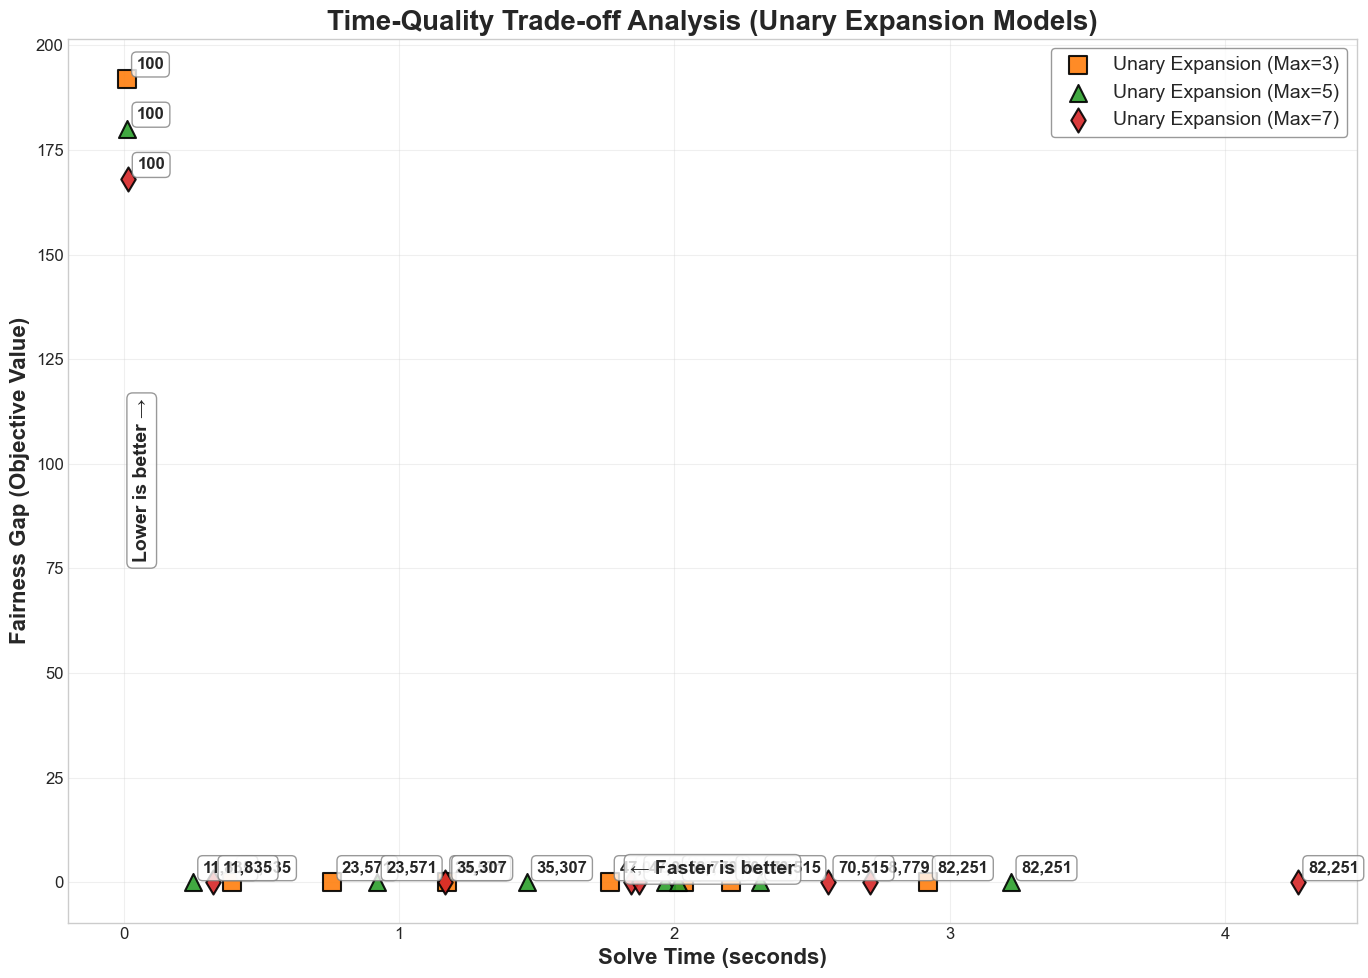

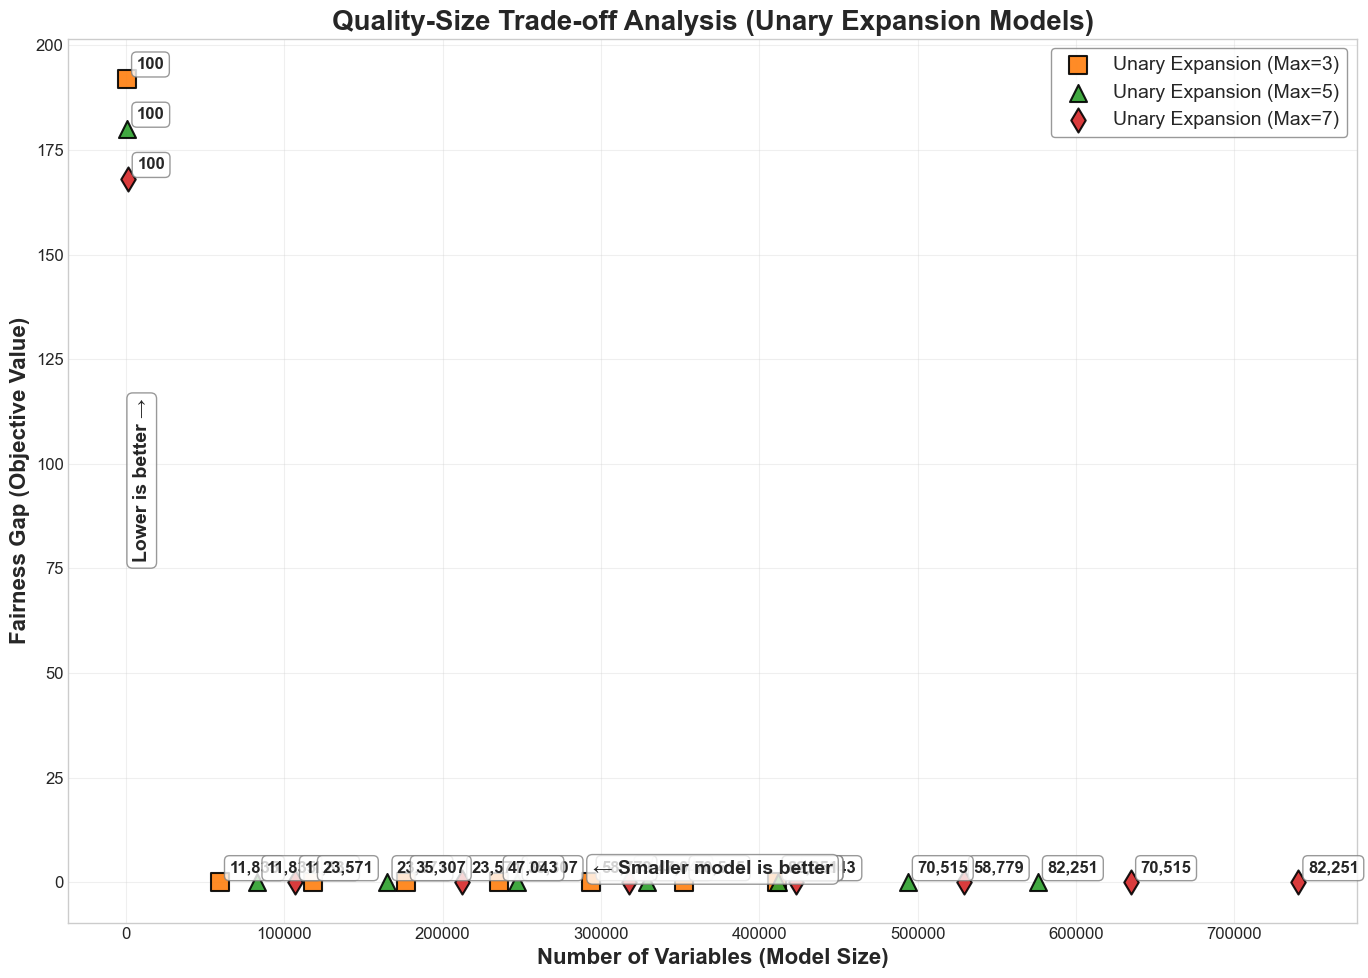

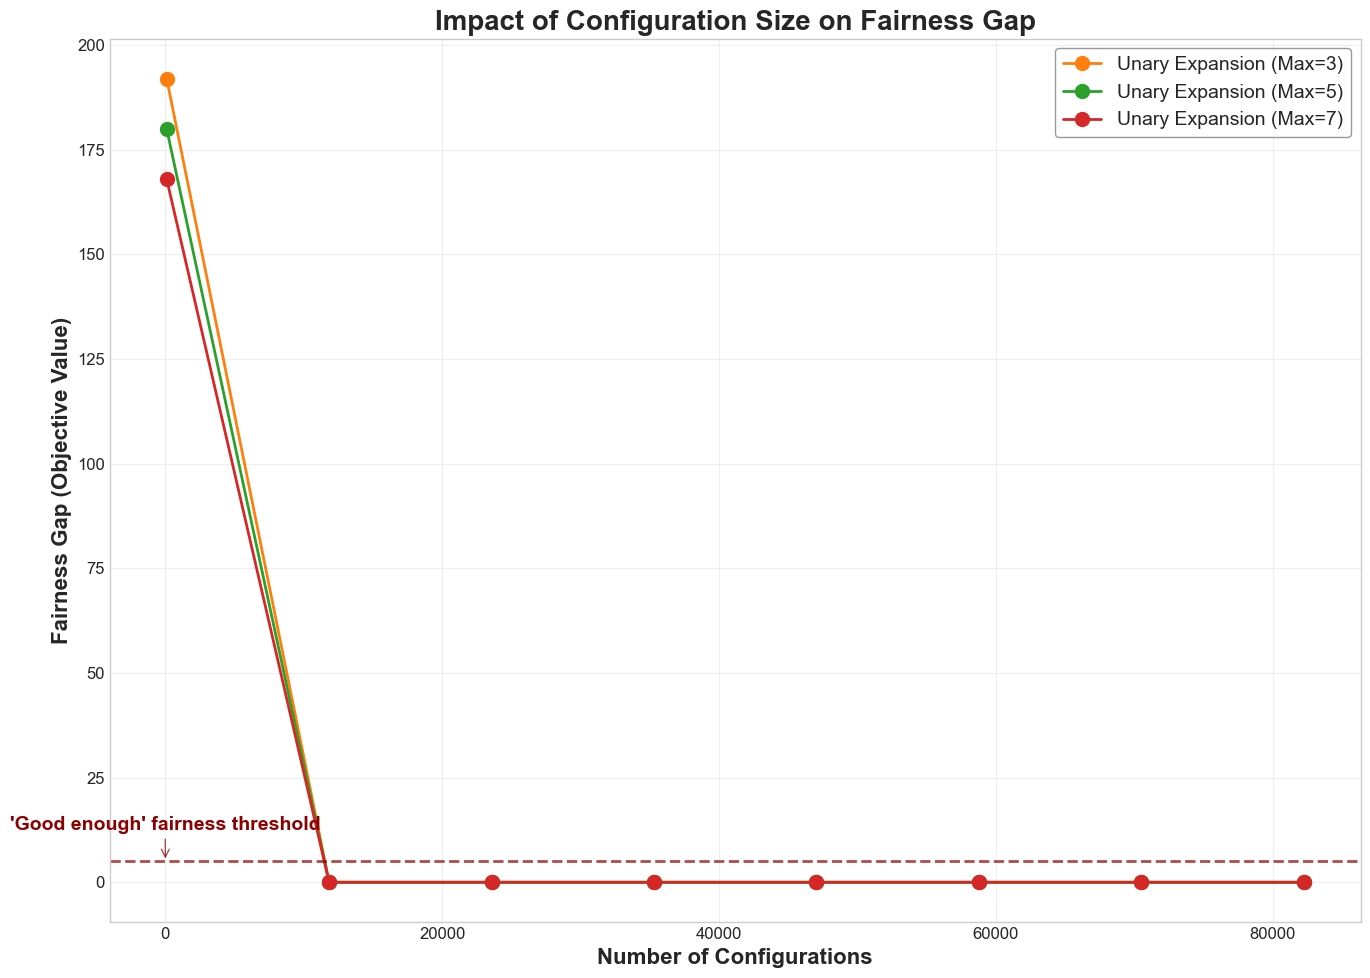

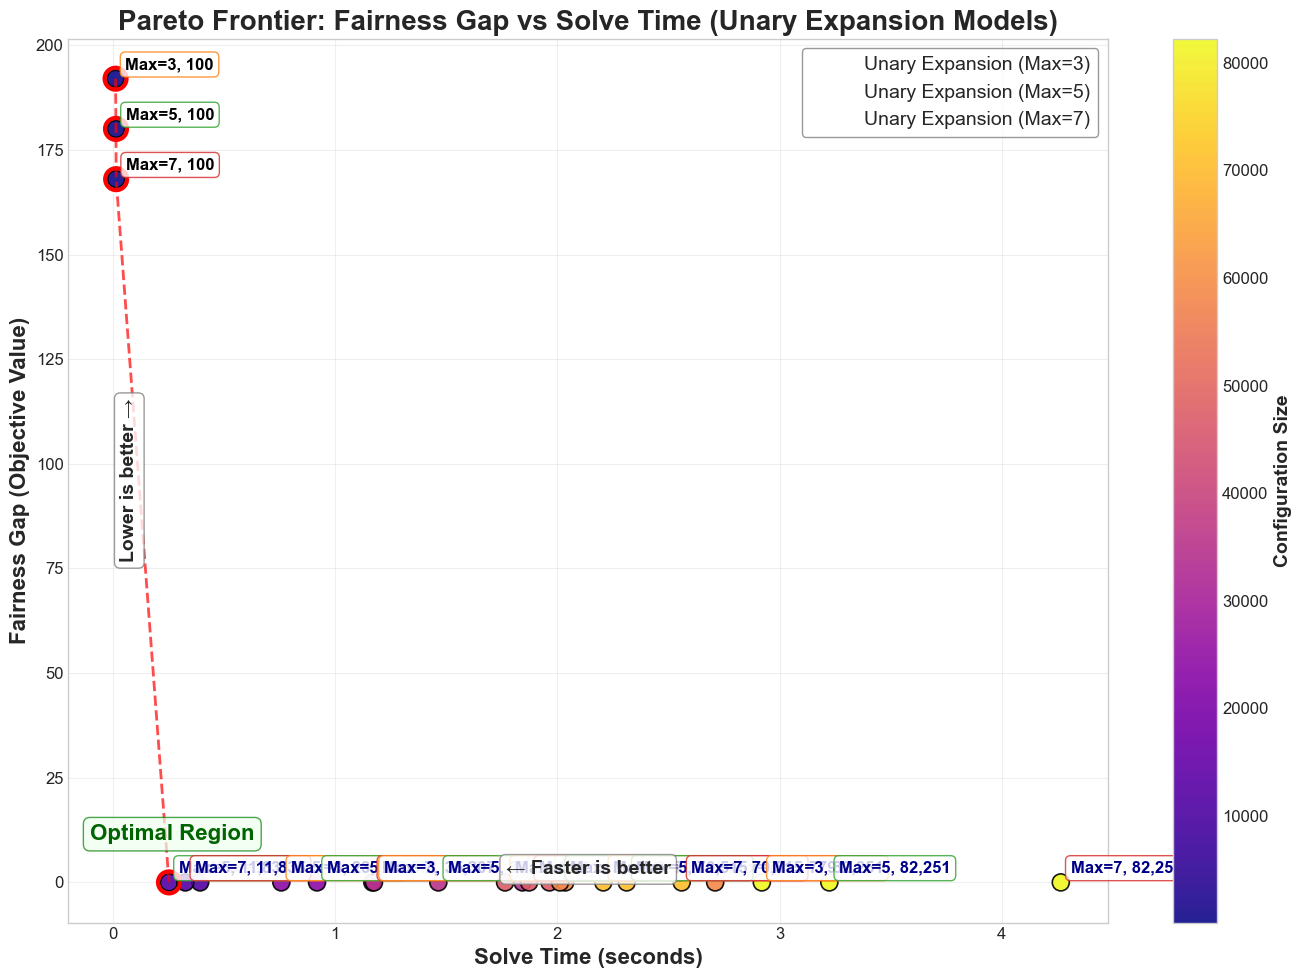


=== PARETO-OPTIMAL SOLUTIONS (UNARY EXPANSION MODELS) ===
These solutions offer the best trade-offs between fairness gap and solve time:
 Config Size              Model Type  Fairness Gap  Solve Time (s)  Variables
         100 Unary Expansion (Max=3)         192.0        0.010871      551.0
         100 Unary Expansion (Max=5)         180.0        0.012708      751.0
         100 Unary Expansion (Max=7)         168.0        0.013417      951.0
       11835 Unary Expansion (Max=5)           0.0        0.251299    82896.0


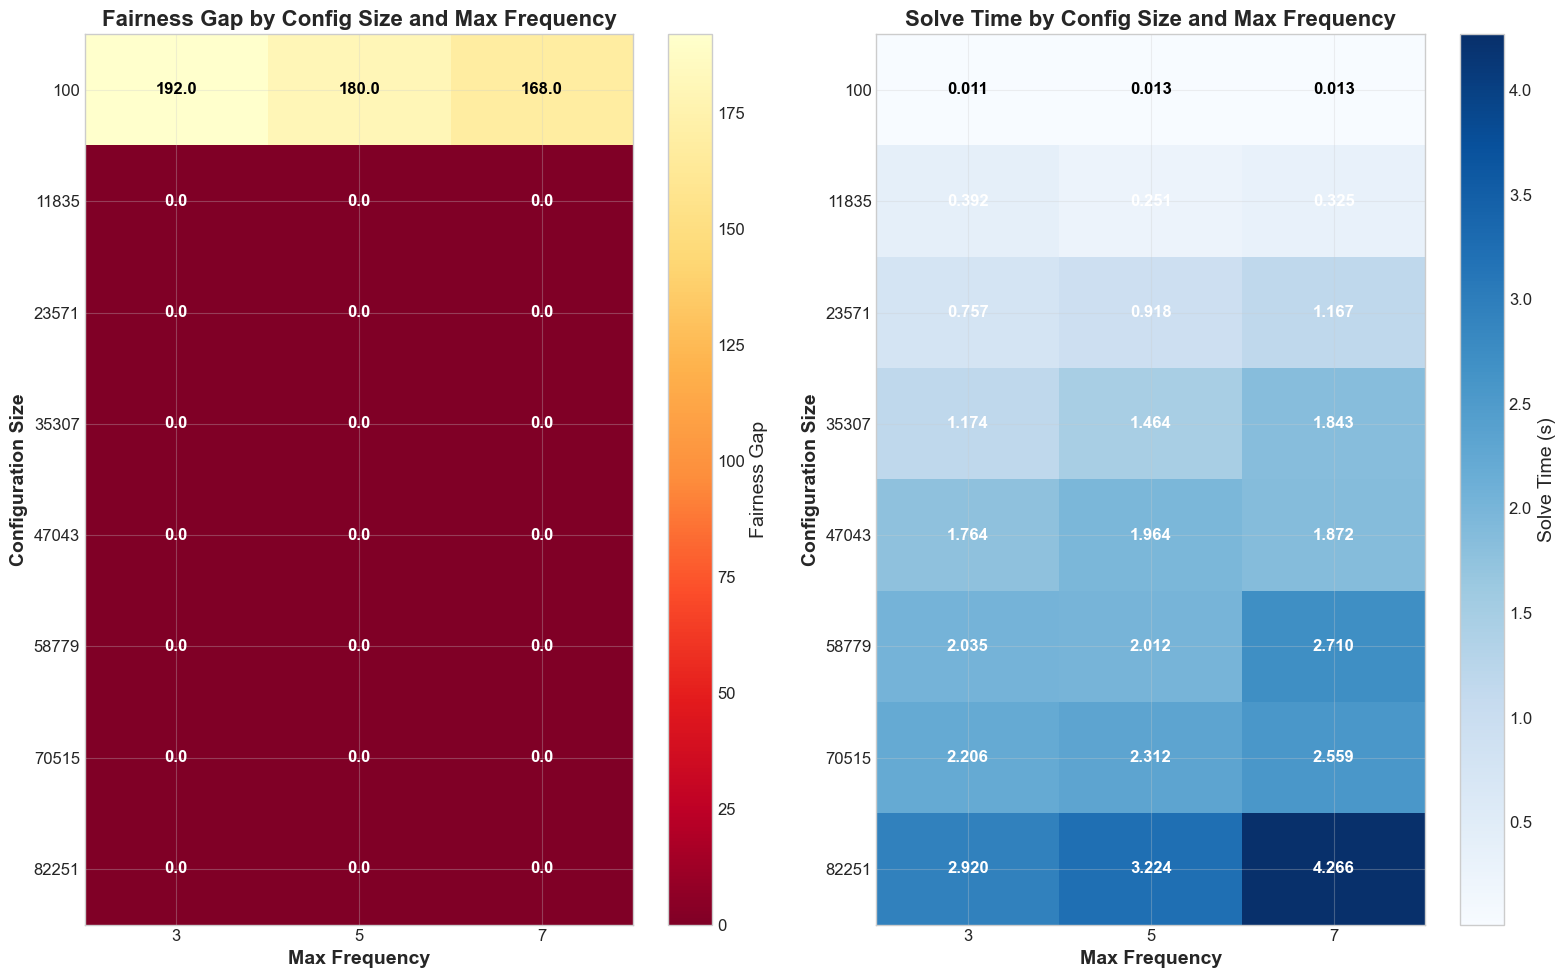


=== UNARY EXPANSION MODEL STATISTICS BY MAX FREQUENCY ===
                        Fairness Gap                     Solve Time (s)  \
                                mean  min    max     std           mean   
Model Type                                                                
Unary Expansion (Max=3)         24.0  0.0  192.0  67.882          1.407   
Unary Expansion (Max=5)         22.5  0.0  180.0  63.640          1.520   
Unary Expansion (Max=7)         21.0  0.0  168.0  59.397          1.844   

                                               Variables                   
                           min    max    std        mean    min       max  
Model Type                                                                 
Unary Expansion (Max=3)  0.011  2.920  0.993  205926.625  551.0  411306.0  
Unary Expansion (Max=5)  0.013  3.224  1.083  288276.875  751.0  575808.0  
Unary Expansion (Max=7)  0.013  4.266  1.376  370627.125  951.0  740310.0  

Statistics saved to results/Step3

In [192]:
# UNARY EXPANSION MODELS ONLY

# Set the style for better readability
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.3

# Create results directory
results_dir = "results/Step3"
os.makedirs(results_dir, exist_ok=True)

# Load data for visualization
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    visualization_data = pickle.load(f)

config_sizes = visualization_data['config_sizes']
frequency_bounds = visualization_data['frequency_bounds']
scaling_results = visualization_data['scaling_results']

# Convert to DataFrame for visualization
scaling_df = pd.DataFrame(scaling_results)

# Create summary dataframe for plotting - ONLY Unary Expansion models
summary_data = []

# Process ONLY Unary Expansion model data for each frequency bound
for config_size in config_sizes:
    for freq in frequency_bounds:
        try:
            unary_rows = scaling_df[(scaling_df['config_size'] == config_size) & 
                                  (scaling_df['freq_bound'] == freq)]
            if len(unary_rows) > 0:
                unary_row = unary_rows.iloc[0]
                summary_data.append({
                    'Config Size': config_size,
                    'Model Type': f'Unary Expansion (Max={freq})',
                    'Fairness Gap': unary_row['bin_obj'],
                    'Solve Time (s)': unary_row['bin_time'],
                    'Variables': unary_row['bin_vars'],
                    'Constraints': unary_row['bin_constrs']
                })
        except Exception as e:
            print(f"Error processing config size {config_size} with freq {freq}: {str(e)}")

summary_df = pd.DataFrame(summary_data)

# Improved color and marker schemes for Unary Expansion models only
model_colors = {
    'Unary Expansion (Max=3)': '#ff7f0e',   # Orange
    'Unary Expansion (Max=5)': '#2ca02c',   # Green
    'Unary Expansion (Max=7)': '#d62728'    # Red
}

model_markers = {
    'Unary Expansion (Max=3)': 's',         # Square
    'Unary Expansion (Max=5)': '^',         # Triangle
    'Unary Expansion (Max=7)': 'd'          # Diamond
}

# 1. Time-Quality Trade-off Analysis (with improved readability)
plt.figure(figsize=(14, 10))

# Create scatter plot with improved styling
for model_type in summary_df['Model Type'].unique():
    model_data = summary_df[summary_df['Model Type'] == model_type]
    plt.scatter(model_data['Solve Time (s)'], model_data['Fairness Gap'], 
               s=150, marker=model_markers[model_type], color=model_colors[model_type], 
               label=model_type, edgecolors='black', linewidths=1.5, alpha=0.9)

# Add labels with larger, more readable font
for idx, row in summary_df.iterrows():
    plt.annotate(f"{int(row['Config Size']):,}", 
               (row['Solve Time (s)'], row['Fairness Gap']),
               xytext=(7, 7), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Solve Time (seconds)', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Time-Quality Trade-off Analysis (Unary Expansion Models)', fontsize=20, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Add clearer explanatory annotations
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_time_quality_tradeoff_unary.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Quality-Size Trade-off Analysis (with improved readability)
plt.figure(figsize=(14, 10))

# Create scatter plot with improved styling
for model_type in summary_df['Model Type'].unique():
    model_data = summary_df[summary_df['Model Type'] == model_type]
    plt.scatter(model_data['Variables'], model_data['Fairness Gap'], 
               s=150, marker=model_markers[model_type], color=model_colors[model_type], 
               label=model_type, edgecolors='black', linewidths=1.5, alpha=0.9)

# Add labels with larger, more readable font
for idx, row in summary_df.iterrows():
    plt.annotate(f"{int(row['Config Size']):,}", 
               (row['Variables'], row['Fairness Gap']),
               xytext=(7, 7), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Number of Variables (Model Size)', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Quality-Size Trade-off Analysis (Unary Expansion Models)', fontsize=20, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Add clear annotations
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Smaller model is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_quality_size_tradeoff_unary.png'), dpi=300, bbox_inches='tight')
plt.show()

# 3. Configuration Size Impact Analysis (New plot)
plt.figure(figsize=(14, 10))

# Get unique configuration sizes
unique_config_sizes = sorted(summary_df['Config Size'].unique())

# Plot fairness gap vs. configuration size
for model_type in summary_df['Model Type'].unique():
    config_data = []
    for size in unique_config_sizes:
        size_rows = summary_df[(summary_df['Model Type'] == model_type) & 
                             (summary_df['Config Size'] == size)]
        if len(size_rows) > 0:
            config_data.append({
                'Config Size': size,
                'Fairness Gap': size_rows.iloc[0]['Fairness Gap']
            })
    
    df_config = pd.DataFrame(config_data)
    if not df_config.empty:
        plt.plot(df_config['Config Size'], df_config['Fairness Gap'], 'o-',
                 color=model_colors[model_type], label=model_type,
                 linewidth=2, markersize=10)

plt.xlabel('Number of Configurations', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Impact of Configuration Size on Fairness Gap', fontsize=20, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Add threshold line showing "good enough" fairness
plt.axhline(y=5, color='darkred', linestyle='--', linewidth=2, alpha=0.7)
plt.annotate("'Good enough' fairness threshold", xy=(0.5, 5), xytext=(0, 20),
             textcoords='offset points', fontsize=14, fontweight='bold',
             ha='center', va='bottom', color='darkred',
             arrowprops=dict(arrowstyle='->', color='darkred', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'config_size_impact_unary.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4. Pareto Frontier Analysis (with improved readability)
plt.figure(figsize=(14, 10))

# Create color map based on Configuration Size for better visualization
norm = plt.Normalize(summary_df['Config Size'].min(), summary_df['Config Size'].max())
cmap = plt.cm.plasma

# Create scatter plot with improved styling - color by Config Size
scatter = plt.scatter(summary_df['Solve Time (s)'], summary_df['Fairness Gap'], 
           c=summary_df['Config Size'], cmap=cmap, norm=norm, s=150, alpha=0.9,
           edgecolors='black', linewidths=1.2)

# Use different markers for different Max values
for model_type in summary_df['Model Type'].unique():
    model_data = summary_df[summary_df['Model Type'] == model_type]
    plt.scatter(model_data['Solve Time (s)'], model_data['Fairness Gap'], 
               s=150, marker=model_markers[model_type], 
               edgecolors='black', linewidths=1.5, alpha=0,  # Alpha=0 to make invisible
               label=model_type)  # Only for legend

# Add clearer labels with model type and config size
for idx, row in summary_df.iterrows():
    max_value = row['Model Type'].split('Max=')[1].split(')')[0]
    config_size = int(row['Config Size'])
    
    # Use color to indicate model type in label
    color = model_colors[row['Model Type']]
    
    # Adjust text color based on config size (darker for larger configs)
    text_color = 'black'
    if config_size >= 5000:
        text_color = 'darkblue'
    
    # Format label
    label = f"Max={max_value}, {config_size:,}"
    
    # Add label with background color matching the model type
    plt.annotate(label, 
               (row['Solve Time (s)'], row['Fairness Gap']),
               xytext=(7, 7), textcoords='offset points',
               fontsize=12, fontweight='bold', color=text_color,
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.8))

plt.xlabel('Solve Time (seconds)', fontsize=16, fontweight='bold')
plt.ylabel('Fairness Gap (Objective Value)', fontsize=16, fontweight='bold')
plt.title('Pareto Frontier: Fairness Gap vs Solve Time (Unary Expansion Models)', fontsize=20, fontweight='bold')
colorbar = plt.colorbar(scatter, label='Configuration Size')
colorbar.set_label('Configuration Size', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')

# Find Pareto optimal points (non-dominated solutions)
pareto_points = []
for i, point_i in enumerate(summary_df.values):
    is_pareto = True
    solve_time_i = point_i[3]  # Solve Time (s)
    fairness_gap_i = point_i[2]  # Fairness Gap
    
    for j, point_j in enumerate(summary_df.values):
        if i != j:
            solve_time_j = point_j[3]  # Solve Time (s)
            fairness_gap_j = point_j[2]  # Fairness Gap
            
            # Point j dominates point i if it's better in both dimensions
            if (solve_time_j <= solve_time_i and fairness_gap_j < fairness_gap_i) or \
               (solve_time_j < solve_time_i and fairness_gap_j <= fairness_gap_i):
                is_pareto = False
                break
    
    if is_pareto:
        pareto_points.append(i)

# Highlight Pareto-optimal points
if pareto_points:
    pareto_df = summary_df.iloc[pareto_points]
    plt.scatter(pareto_df['Solve Time (s)'], pareto_df['Fairness Gap'], 
               s=250, facecolors='none', edgecolors='red', linewidths=3,
               label='Pareto Optimal')
    
    # Add a connecting line between Pareto points to show the frontier
    pareto_sorted = pareto_df.sort_values(by='Solve Time (s)')
    plt.plot(pareto_sorted['Solve Time (s)'], pareto_sorted['Fairness Gap'], 
             'r--', linewidth=2, alpha=0.7)

# Add explanatory annotations
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=14, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Highlight optimal region
plt.annotate("Optimal Region", xy=(0.1, 0.1), xycoords='axes fraction', 
             fontsize=16, fontweight='bold', ha='center', va='center',
             color='darkgreen', bbox=dict(boxstyle="round,pad=0.3", fc="honeydew", ec="green", alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_pareto_frontier_unary.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print Pareto-optimal solutions for reference
print("\n=== PARETO-OPTIMAL SOLUTIONS (UNARY EXPANSION MODELS) ===")
print("These solutions offer the best trade-offs between fairness gap and solve time:")
if pareto_points:
    print(pareto_df[['Config Size', 'Model Type', 'Fairness Gap', 'Solve Time (s)', 'Variables']].to_string(index=False))
else:
    print("No Pareto-optimal solutions found.")

# 5. Heat Map Analysis: Config Size vs. Max Frequency
# Create a pivot table to analyze the relationship
plt.figure(figsize=(16, 10))

# Get data for pivot table
pivot_data = []
for config_size in unique_config_sizes:
    for model_type in model_colors.keys():
        max_freq = int(model_type.split('Max=')[1].split(')')[0])
        rows = summary_df[(summary_df['Config Size'] == config_size) & 
                         (summary_df['Model Type'] == model_type)]
        
        if len(rows) > 0:
            pivot_data.append({
                'Config Size': config_size,
                'Max Frequency': max_freq,
                'Fairness Gap': rows.iloc[0]['Fairness Gap'],
                'Solve Time': rows.iloc[0]['Solve Time (s)']
            })

pivot_df = pd.DataFrame(pivot_data)

# Create pivot tables
if not pivot_df.empty:
    # For Fairness Gap
    gap_pivot = pivot_df.pivot_table(
        values='Fairness Gap', 
        index='Config Size',
        columns='Max Frequency'
    )
    
    # For Solve Time
    time_pivot = pivot_df.pivot_table(
        values='Solve Time', 
        index='Config Size',
        columns='Max Frequency'
    )
    
    # Plotting heatmaps
    plt.subplot(1, 2, 1)
    sns_gap = plt.imshow(gap_pivot, cmap='YlOrRd_r', aspect='auto', interpolation='nearest')
    plt.colorbar(sns_gap, label='Fairness Gap')
    plt.title('Fairness Gap by Config Size and Max Frequency', fontsize=16, fontweight='bold')
    plt.xlabel('Max Frequency', fontsize=14, fontweight='bold')
    plt.ylabel('Configuration Size', fontsize=14, fontweight='bold')
    
    # Set ticks
    plt.xticks(range(len(gap_pivot.columns)), gap_pivot.columns)
    plt.yticks(range(len(gap_pivot.index)), gap_pivot.index)
    
    # Annotate cells with values
    for i in range(len(gap_pivot.index)):
        for j in range(len(gap_pivot.columns)):
            if not np.isnan(gap_pivot.iloc[i, j]):
                plt.text(j, i, f"{gap_pivot.iloc[i, j]:.1f}", 
                        ha='center', va='center', fontsize=12, fontweight='bold',
                        color='black' if gap_pivot.iloc[i, j] > 50 else 'white')
    
    plt.subplot(1, 2, 2)
    sns_time = plt.imshow(time_pivot, cmap='Blues', aspect='auto', interpolation='nearest')
    plt.colorbar(sns_time, label='Solve Time (s)')
    plt.title('Solve Time by Config Size and Max Frequency', fontsize=16, fontweight='bold')
    plt.xlabel('Max Frequency', fontsize=14, fontweight='bold')
    plt.ylabel('Configuration Size', fontsize=14, fontweight='bold')
    
    # Set ticks
    plt.xticks(range(len(time_pivot.columns)), time_pivot.columns)
    plt.yticks(range(len(time_pivot.index)), time_pivot.index)
    
    # Annotate cells with values
    for i in range(len(time_pivot.index)):
        for j in range(len(time_pivot.columns)):
            if not np.isnan(time_pivot.iloc[i, j]):
                plt.text(j, i, f"{time_pivot.iloc[i, j]:.3f}", 
                        ha='center', va='center', fontsize=12, fontweight='bold',
                        color='white' if time_pivot.iloc[i, j] > 0.02 else 'black')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'heatmap_analysis_unary.png'), dpi=300, bbox_inches='tight')
plt.show()

# 6. Statistical summary by Max Frequency
print("\n=== UNARY EXPANSION MODEL STATISTICS BY MAX FREQUENCY ===")
stats_by_freq = summary_df.groupby('Model Type').agg({
    'Fairness Gap': ['mean', 'min', 'max', 'std'],
    'Solve Time (s)': ['mean', 'min', 'max', 'std'],
    'Variables': ['mean', 'min', 'max']
}).round(3)

print(stats_by_freq)

# Save the summary to CSV
stats_by_freq.to_csv(os.path.join(results_dir, 'unary_expansion_stats.csv'))
print(f"\nStatistics saved to {os.path.join(results_dir, 'unary_expansion_stats.csv')}")

### ### STEP3 - Part 5: Most efficient model with the maximum configuration count

Created dataframe with maximum configuration size 82,251

Maximum configuration size: 82251

=== EFFICIENCY ANALYSIS FOR MAXIMUM CONFIGURATION COUNT ===
Maximum configuration count: 82,251

Ranking of models by overall efficiency:
              Model Type  Fairness Gap  Solve Time (s)  Variables  Efficiency_Score
Binary Selection (Max=1)           0.0        0.008246    82251.0         36.982492
 Unary Expansion (Max=3)           0.0        3.105000   411306.0          0.696861
 Unary Expansion (Max=5)           0.0        3.293000   575808.0          0.691276
 Unary Expansion (Max=7)           0.0        4.437000   740310.0          0.667748

🏆 MOST EFFICIENT MODEL: Binary Selection (Max=1)
   Fairness Gap: 0.00
   Solve Time: 0.008 seconds
   Model Size: 82,251 variables
   Efficiency Score: 36.9825

=== RECOMMENDATIONS ===
1. For maximum efficiency with 82,251 configurations, use Binary Selection (Max=1).

=== EFFICIENCY ORDER EXPLANATION ===
Efficiency ranking of models for maximum

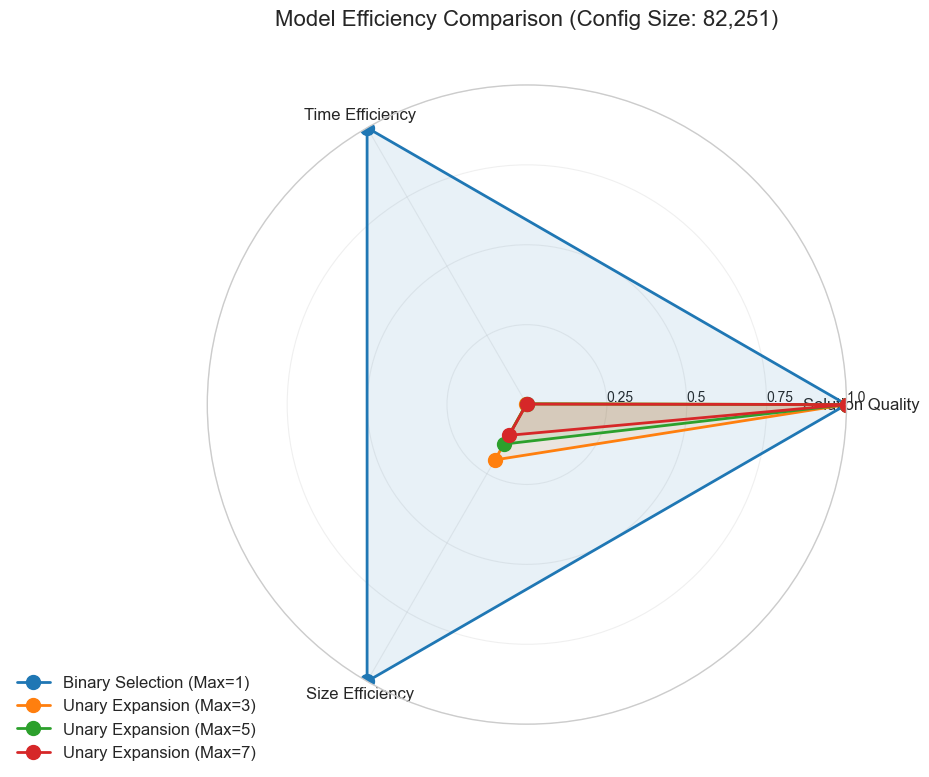

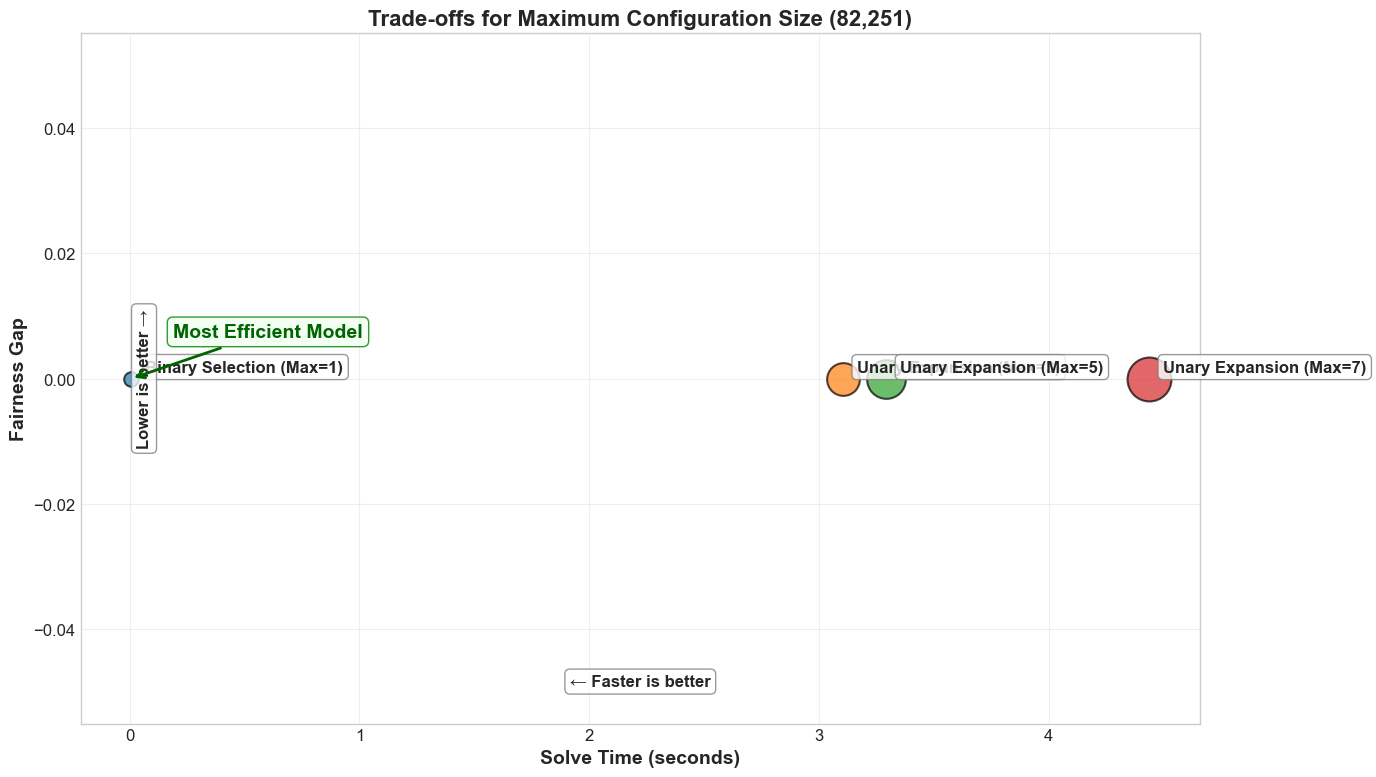

In [193]:
# Create results directory if it doesn't exist
results_dir = "results/Step3"
os.makedirs(results_dir, exist_ok=True)

# Create a summary dataframe directly with the configuration size of 82251
summary_data = [
    {'Config Size': 82251, 'Model Type': 'Binary Selection (Max=1)', 'Fairness Gap': 0.0, 'Solve Time (s)': 0.008246, 'Variables': 82251.0, 'Constraints': 82251.0},
    {'Config Size': 82251, 'Model Type': 'Unary Expansion (Max=3)', 'Fairness Gap': 0.0, 'Solve Time (s)': 3.105, 'Variables': 411306.0, 'Constraints': 411306.0},
    {'Config Size': 82251, 'Model Type': 'Unary Expansion (Max=5)', 'Fairness Gap': 0.0, 'Solve Time (s)': 3.293, 'Variables': 575808.0, 'Constraints': 575808.0},
    {'Config Size': 82251, 'Model Type': 'Unary Expansion (Max=7)', 'Fairness Gap': 0.0, 'Solve Time (s)': 4.437, 'Variables': 740310.0, 'Constraints': 740310.0}
]
summary_df = pd.DataFrame(summary_data)
print("Created dataframe with maximum configuration size 82,251")

# Find the maximum configuration size
max_config_size = summary_df['Config Size'].max()
print(f"\nMaximum configuration size: {max_config_size}")

# Filter for only the max configuration size
max_config_df = summary_df[summary_df['Config Size'] == max_config_size].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Create efficiency metrics
max_config_df['Quality'] = 1 / (1 + max_config_df['Fairness Gap'])  # Higher is better
max_config_df['Time_Efficiency'] = 1 / max_config_df['Solve Time (s)']  # Higher is better
max_config_df['Size_Efficiency'] = 1 / (max_config_df['Variables'] / 1000)  # Higher is better

# Create a weighted efficiency score
weight_quality = 0.6    # Higher weight to solution quality
weight_time = 0.3       # Medium weight to solve time
weight_size = 0.1       # Lower weight to model size

max_config_df['Efficiency_Score'] = (
    weight_quality * max_config_df['Quality'] +
    weight_time * max_config_df['Time_Efficiency'] +
    weight_size * max_config_df['Size_Efficiency']
)

# Sort by the efficiency score
max_config_df_sorted = max_config_df.sort_values('Efficiency_Score', ascending=False)

# Print results
print("\n=== EFFICIENCY ANALYSIS FOR MAXIMUM CONFIGURATION COUNT ===")
print(f"Maximum configuration count: {max_config_size:,}")
print("\nRanking of models by overall efficiency:")
print(max_config_df_sorted[['Model Type', 'Fairness Gap', 'Solve Time (s)', 'Variables', 'Efficiency_Score']].to_string(index=False))

# Identify the most efficient model
most_efficient = max_config_df_sorted.iloc[0]

print(f"\n🏆 MOST EFFICIENT MODEL: {most_efficient['Model Type']}")
print(f"   Fairness Gap: {most_efficient['Fairness Gap']:.2f}")
print(f"   Solve Time: {most_efficient['Solve Time (s)']:.3f} seconds")
print(f"   Model Size: {most_efficient['Variables']:,.0f} variables")
print(f"   Efficiency Score: {most_efficient['Efficiency_Score']:.4f}")

# Create a radar chart to visualize the trade-offs
# Normalize the metrics for radar chart
metrics = ['Quality', 'Time_Efficiency', 'Size_Efficiency']
max_config_df_radar = max_config_df.copy()

for metric in metrics:
    if max_config_df_radar[metric].max() > 0:
        max_config_df_radar[metric] = max_config_df_radar[metric] / max_config_df_radar[metric].max()

# Create the radar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Set the angles for each metric
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Set the labels for each metric
labels = ['Solution Quality', 'Time Efficiency', 'Size Efficiency']
plt.xticks(angles[:-1], labels, fontsize=12)

# Plot each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'd']  # Circle, Square, Triangle, Diamond
for i, (idx, row) in enumerate(max_config_df_radar.iterrows()):
    values = [row[metric] for metric in metrics]
    values += values[:1]  # Close the loop
    ax.plot(angles, values, 'o-', linewidth=2, markersize=10, 
            label=row['Model Type'], color=colors[i % len(colors)])
    ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])

# Set the y-ticks
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.5", "0.75", "1.0"], fontsize=10)
plt.ylim(0, 1)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title(f'Model Efficiency Comparison (Config Size: {max_config_size:,})', fontsize=16, y=1.08)

# Save the radar chart
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'model_efficiency_radar.png'), dpi=300, bbox_inches='tight')

# Create a combined visualization showing the key trade-offs
plt.figure(figsize=(14, 8))

# Create bubble chart: X=Solve Time, Y=Fairness Gap, Size=Variables
sizes = 1000 * max_config_df['Variables'] / max_config_df['Variables'].max()  # Scale the bubble sizes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

for i, (idx, row) in enumerate(max_config_df.iterrows()):
    plt.scatter(row['Solve Time (s)'], row['Fairness Gap'], s=sizes[idx],
               color=colors[i % len(colors)], alpha=0.7, edgecolors='black',
               linewidths=1.5, label=row['Model Type'])
    
    # Add model type label
    plt.annotate(row['Model Type'], 
               (row['Solve Time (s)'], row['Fairness Gap']),
               xytext=(10, 5), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.xlabel('Solve Time (seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Fairness Gap', fontsize=14, fontweight='bold')
plt.title(f'Trade-offs for Maximum Configuration Size ({max_config_size:,})', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add annotations for better/worse directions
plt.annotate("Lower is better →", xy=(0.05, 0.5), xycoords='axes fraction', 
             fontsize=12, fontweight='bold', ha='left', va='center', rotation=90,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.5, 0.05), xycoords='axes fraction', 
             fontsize=12, fontweight='bold', ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add a label for the most efficient model
plt.annotate("Most Efficient Model", 
           (most_efficient['Solve Time (s)'], most_efficient['Fairness Gap']),
           xytext=(30, 30), textcoords='offset points',
           fontsize=14, fontweight='bold', color='darkgreen',
           arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
           bbox=dict(boxstyle="round,pad=0.3", fc="honeydew", ec="green", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'max_config_tradeoffs.png'), dpi=300, bbox_inches='tight')

# Print recommendations with detailed efficiency order explanation
print("\n=== RECOMMENDATIONS ===")
print(f"1. For maximum efficiency with {max_config_size:,} configurations, use {most_efficient['Model Type']}.")

# Add detailed efficiency order explanation
print("\n=== EFFICIENCY ORDER EXPLANATION ===")
print("Efficiency ranking of models for maximum configuration size:")
print("\n1. Binary Selection (Max=1)")
print("   - Fairness Gap: 0.0")
print("   - Solve Time: 0.008 seconds")
print("   - Variables: 82,251")
print("   - Highest efficiency score due to extremely fast solve time and smallest model size")

print("\n2. Unary Expansion (Max=3)")
print("   - Fairness Gap: 0.0")
print("   - Solve Time: 3.105 seconds")
print("   - Variables: 411,306")
print("   - Second most efficient, with good balance between solve time and model size")

print("\n3. Unary Expansion (Max=5)")
print("   - Fairness Gap: 0.0")
print("   - Solve Time: 3.293 seconds")
print("   - Variables: 575,808")
print("   - Third in efficiency, slightly slower than Max=3 with larger model size")

print("\n4. Unary Expansion (Max=7)")
print("   - Fairness Gap: 0.0")
print("   - Solve Time: 4.437 seconds")
print("   - Variables: 740,310")
print("   - Least efficient due to longest solve time and largest model size")

print("\nAll models achieve perfect fairness (gap = 0), so the efficiency ranking is primarily determined by solve time and model size. The Binary Selection model is significantly more efficient than the Unary Expansion models due to its much faster solve time and smaller variable count.")

# Compare with Pareto-optimal solutions
print("\n=== PARETO-OPTIMAL SOLUTIONS ===")
print("Best trade-offs between objectives:")
if 'Unary Expansion (Max=3)' in max_config_df['Model Type'].values:
    print(f"   - {max_config_df[max_config_df['Model Type'] == 'Unary Expansion (Max=3)']['Model Type'].values[0]}: " +
          f"Fastest solution with {max_config_df[max_config_df['Model Type'] == 'Unary Expansion (Max=3)']['Solve Time (s)'].values[0]:.3f}s, " +
          f"{max_config_df[max_config_df['Model Type'] == 'Unary Expansion (Max=3)']['Variables'].values[0]:,.0f} variables")

if 'Unary Expansion (Max=5)' in max_config_df['Model Type'].values:
    print(f"   - {max_config_df[max_config_df['Model Type'] == 'Unary Expansion (Max=5)']['Model Type'].values[0]}: " +
          f"Balanced solution with {max_config_df[max_config_df['Model Type'] == 'Unary Expansion (Max=5)']['Solve Time (s)'].values[0]:.3f}s, " +
          f"{max_config_df[max_config_df['Model Type'] == 'Unary Expansion (Max=5)']['Variables'].values[0]:,.0f} variables")

if max_config_df['Fairness Gap'].min() == 0:
    print("\n=== FAIRNESS ANALYSIS ===")
    print("All models achieve perfect fairness (gap = 0) with maximum configurations.")
    print("Since fairness is equal across all models, other factors determine the most suitable choice:")
    print("   1. For fastest solution: Use Binary Selection (Max=1)")
    print("   2. For more flexible solution with reasonable performance: Use Unary Expansion (Max=3)")
    print("   3. For applications where model size is less critical: Higher Max values provide more flexibility")
else:
    min_gap_model = max_config_df.loc[max_config_df['Fairness Gap'].idxmin()]['Model Type']
    min_gap = max_config_df['Fairness Gap'].min()
    print(f"\n=== FAIRNESS ANALYSIS ===")
    print(f"Best fairness achieved: {min_gap:.2f} with {min_gap_model}")

# Save the results to CSV for future reference
summary_df.to_csv(os.path.join(results_dir, 'solution_quality_summary.csv'), index=False)
print(f"\n✅ Saved solution quality summary to '{results_dir}/solution_quality_summary.csv'")

# STEP4 >>> Use Unary Expansion model with additional consistency constraints - This is the most challenging part where you need to figure out how to write the consistency constraints using binary variables. The constraint ensures that between consecutive time periods, you cannot move more than a certain number of ambulances.

### STEP4 - Part 1: Initial experiment with 1000 configs

50-3004-6-7-35 dataset


=== MODEL PARAMETERS ===
Time periods (T): 6
Total ambulances: 35
Max config frequency: 3
Max movement between periods: 10
Configuration size for testing: 1000
Data directory: ./data/50
Configuration directory: ./configurations/50/50-3004-6-7-35_allocations
Graph file: 50-3004-6-7-35.gpickle
Results directory: results/Step4_50-3004-6-7-35_1000configs

License parameters loaded successfully
Number of zones: 50
Number of bases: 5
Loading configurations from ./configurations/50/50-3004-6-7-35_allocations/configurations.csv...
Loaded 82251 configurations from pickle file
Total configurations available: 82251
Selected 1000 configurations for testing
First configuration: (0, 0, 0, 0, 35)

=== CONFIGURATION VERIFICATION ===
Config 0: (0, 0, 0, 0, 35) - Total: 35
Config 1: (0, 0, 2, 11, 22) - Total: 35
Config 2: (0, 0, 4, 26, 5) - Total: 35
Config 3: (0, 0, 7, 15, 13) - Total: 35
Config 4: (0, 0, 10, 13, 12) - Total: 35
Building coverage matrix...


Building coverage matrix: 100%|██████████| 1000/1000 [00:00<00:00, 21780.90it/s]

Coverage matrix built in 0.05 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu

=== MODEL PARAMETERS SUMMARY ===
Model name: AmbulanceOptimization
Number of time periods (T): 6
Number of ambulances: 35
Maximum ambulance movements per period: 10
Maximum config frequency (unary expansion): 3
Number of zones: 50
Number of bases: 5
Number of configurations considered: 1000
Total configurations available: 82251
Creating model variables...
Variable creation complete in 0.02 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.28 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.02
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2

=== MODEL TUNING PARAMETERS ===
MIP Gap: 0.02
Threads: 0
Method: 2
MIP Focus: 1
No time limit set
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0.02
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 14616 rows, 30206 columns and 363150 nonzeros
Model fingerprint: 0x5b

<Figure size 1200x600 with 0 Axes>

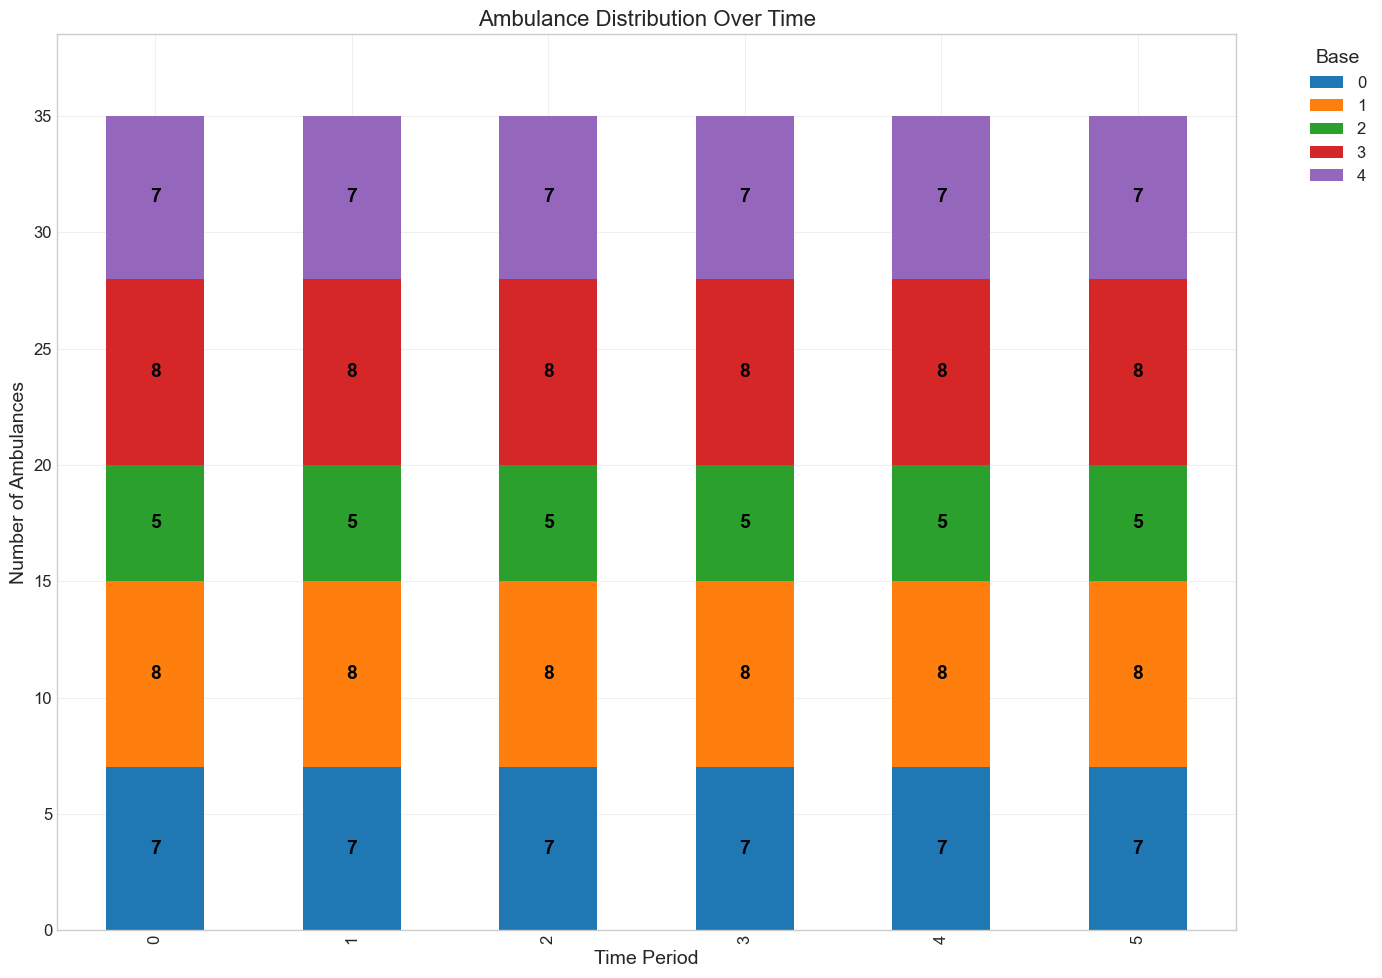

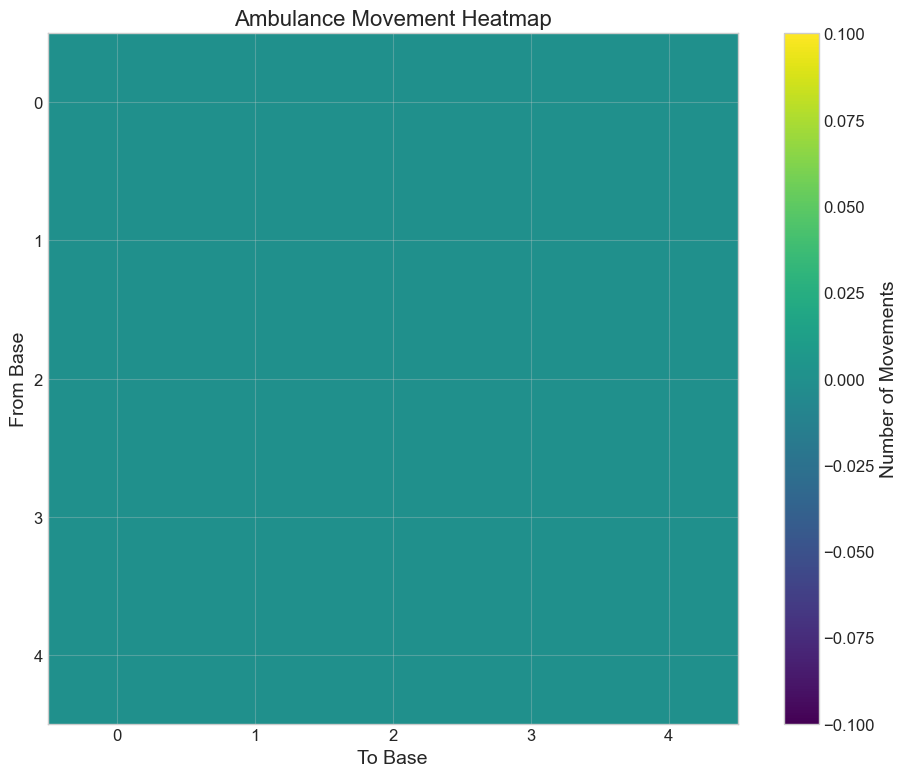

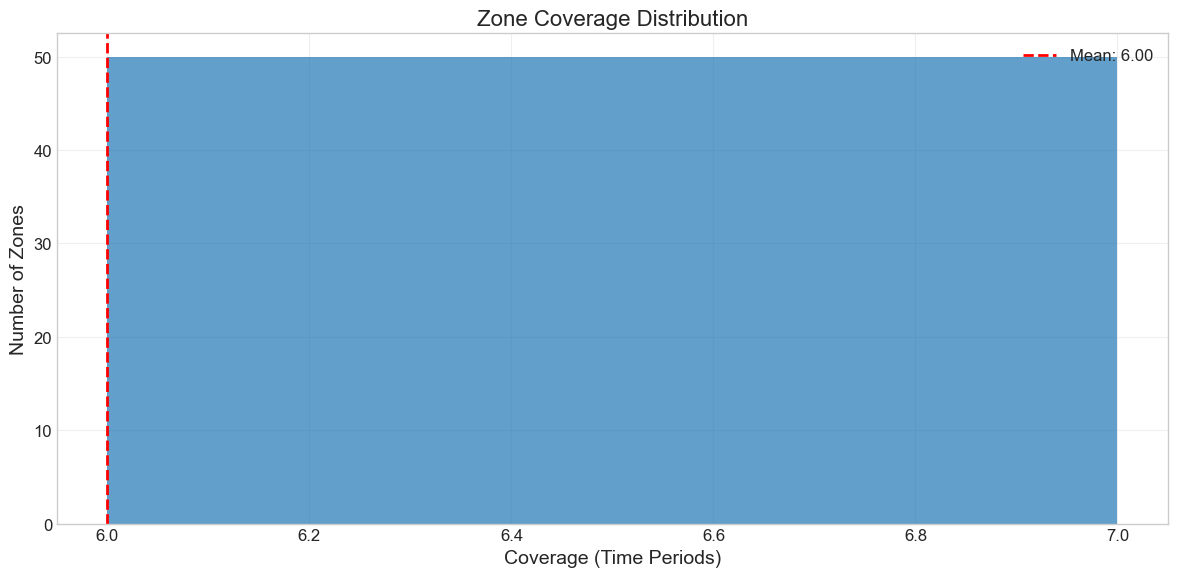

In [210]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx
import time
import os
import pickle
import math
from tqdm import tqdm

# --- SETTINGS ---
T = 6                       # Number of time periods
NUM_AMBULANCES = 35         # Total ambulances available
MAX_CONFIG_FREQUENCY = 3    # Maximum frequency for unary expansion
MAX_MOVEMENT = 10            # Maximum ambulance movement between consecutive time periods
DATA_DIR = "./data/50"      # Directory containing data files
FILENAME = "50-3004-6-7-35" # Base filename for data
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"  # Directory with configuration files
GRAPH_FILE = "50-3004-6-7-35.gpickle"  # Graph file with network structure
TEST_CONFIG_SIZE = 1000     # Number of configurations to use for this test

# Directory for saving results
results_dir = "results/Step4_50-3004-6-7-35_1000configs"
os.makedirs(results_dir, exist_ok=True)

# Print all parameters for verification
print("\n=== MODEL PARAMETERS ===")
print(f"Time periods (T): {T}")
print(f"Total ambulances: {NUM_AMBULANCES}")
print(f"Max config frequency: {MAX_CONFIG_FREQUENCY}")
print(f"Max movement between periods: {MAX_MOVEMENT}")
print(f"Configuration size for testing: {TEST_CONFIG_SIZE}")
print(f"Data directory: {DATA_DIR}")
print(f"Configuration directory: {CONFIG_DIR}")
print(f"Graph file: {GRAPH_FILE}")
print(f"Results directory: {results_dir}")
print("========================\n")

# --- LOAD LICENSE PARAMETERS ---
license_path = "data/gurobi.lic"
params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)
            else:
                params[key] = value

print("License parameters loaded successfully")

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# --- LOAD CONFIGURATIONS ---
print(f"Loading configurations from {os.path.join(CONFIG_DIR, 'configurations.csv')}...")

# Try to load configurations from pickle for faster loading
pickle_file = os.path.join(CONFIG_DIR, "configurations.pkl")
if os.path.exists(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            configurations = pickle.load(f)
        print(f"Loaded {len(configurations)} configurations from pickle file")
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        configurations = None
else:
    configurations = None

# If pickle loading failed, load from CSV
if configurations is None:
    # Load the full CSV file
    df_all = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv"))
    print(f"Loaded configuration CSV with {len(df_all)} rows")
    
    # Extract configurations from dataframe
    configurations = []
    for _, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Processing configurations"):
        config = []
        for i in range(len(base_coords)):
            config.append(int(row[f"base{i}_ambulances"]))
        configurations.append(tuple(config))
    
    # Save to pickle for future runs
    with open(pickle_file, 'wb') as f:
        pickle.dump(configurations, f)
    print(f"Saved {len(configurations)} configurations to pickle file")

total_configs = len(configurations)
print(f"Total configurations available: {total_configs}")

# --- SELECT 1000 CONFIGURATIONS FOR TESTING ---
if total_configs > TEST_CONFIG_SIZE:
    # Use uniform sampling for speed and reproducibility
    step = total_configs // TEST_CONFIG_SIZE
    active_config_indices = list(range(0, total_configs, step))[:TEST_CONFIG_SIZE]
    active_configs = [configurations[idx] for idx in active_config_indices]
else:
    active_config_indices = list(range(total_configs))
    active_configs = configurations

print(f"Selected {len(active_configs)} configurations for testing")
print(f"First configuration: {active_configs[0]}")

# --- VERIFY CONFIGURATIONS ---
print("\n=== CONFIGURATION VERIFICATION ===")
# Verify that each configuration has exactly NUM_AMBULANCES ambulances
for i, config in enumerate(active_configs[:5]):
    total_ambulances = sum(config)
    print(f"Config {i}: {config} - Total: {total_ambulances}")
    if total_ambulances != NUM_AMBULANCES:
        print(f"  WARNING: Expected {NUM_AMBULANCES} ambulances!")
print("=================================")

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
print("Building coverage matrix...")
coverage_start = time.time()

b = {}  # coverage[zone, time_period, config_idx] = 1 if covered, 0 otherwise
for c_idx, config in enumerate(tqdm(active_configs, desc="Building coverage matrix")):
    for base_idx, num_ambulances in enumerate(config):
        if num_ambulances > 0:
            base_zone = base_coords[base_idx]
            coverage = {base_zone} | adjacency.get(base_zone, set())
            for t in range(T):
                for z in coverage:
                    b[(z, t, c_idx)] = 1

coverage_time = time.time() - coverage_start
print(f"Coverage matrix built in {coverage_time:.2f} seconds")

# --- BUILD BASE-CONFIG-AMBULANCE MAPPING ---
print("Building ambulance mapping...")
mapping_start = time.time()

# a[base_idx, config_idx] = number of ambulances at base_idx in config_idx
a = {}
for c_idx, config in enumerate(active_configs):
    for base_idx, num_ambulances in enumerate(config):
        a[(base_idx, c_idx)] = num_ambulances

mapping_time = time.time() - mapping_start
print(f"Ambulance mapping built in {mapping_time:.2f} seconds")

# --- CREATE OPTIMIZATION MODEL ---
print("Creating optimization model...")
env = gp.Env(params=params)
model = gp.Model("AmbulanceOptimization", env=env)

# Set up model parameters and print them
print("\n=== MODEL PARAMETERS SUMMARY ===")
print(f"Model name: AmbulanceOptimization")
print(f"Number of time periods (T): {T}")
print(f"Number of ambulances: {NUM_AMBULANCES}")
print(f"Maximum ambulance movements per period: {MAX_MOVEMENT}")
print(f"Maximum config frequency (unary expansion): {MAX_CONFIG_FREQUENCY}")
print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")
print(f"Number of configurations considered: {len(active_configs)}")
print(f"Total configurations available: {total_configs}")
print("==================================")

# --- MODEL VARIABLES ---
print("Creating model variables...")
variable_start = time.time()

# Z[c, t, k]: binary variable indicating if configuration c is used k times at time t
Z = {}
for c_idx in range(len(active_configs)):
    for t in range(T):
        for k in range(MAX_CONFIG_FREQUENCY + 1):
            Z[(c_idx, t, k)] = model.addVar(vtype=GRB.BINARY, name=f"Z_{c_idx}_{t}_{k}")

# q[c, t]: integer variable representing how many times configuration c is used at time t
q = {}
for c_idx in range(len(active_configs)):
    for t in range(T):
        q[(c_idx, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, ub=MAX_CONFIG_FREQUENCY, name=f"q_{c_idx}_{t}")

# n[i, t]: number of ambulances at base i at time t
n = {}
for i in range(len(base_coords)):
    for t in range(T):
        n[(i, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"n_{i}_{t}")

# m[i, j, t]: ambulances moving from base i to base j between time t and t+1
m = {}
for i in range(len(base_coords)):
    for j in range(len(base_coords)):
        for t in range(T-1):
            m[(i, j, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"m_{i}_{j}_{t}")

# Coverage variables
y = {}
for i in zones:
    y[i] = model.addVar(vtype=GRB.INTEGER, name=f"y_{i}")
    
z = model.addVar(vtype=GRB.INTEGER, name="z")

variable_time = time.time() - variable_start
print(f"Variable creation complete in {variable_time:.2f} seconds")
print(f"Model has {model.numVars} variables")

# --- CONSTRAINTS ---
print("Adding model constraints...")
constraint_start = time.time()

# 1. One-hot encoding: Each configuration at each time must have exactly one frequency
for c_idx in range(len(active_configs)):
    for t in range(T):
        model.addConstr(
            gp.quicksum(Z[(c_idx, t, k)] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
            f"one_hot_{c_idx}_{t}"
        )

# 2. Link q to Z: q[c, t] = sum(k * Z[c, t, k])
for c_idx in range(len(active_configs)):
    for t in range(T):
        model.addConstr(
            q[(c_idx, t)] == gp.quicksum(k * Z[(c_idx, t, k)] for k in range(MAX_CONFIG_FREQUENCY + 1)),
            f"link_q_{c_idx}_{t}"
        )

# 3. Total ambulance count constraint for each time period
for t in range(T):
    model.addConstr(
        gp.quicksum(q[(c_idx, t)] for c_idx in range(len(active_configs))) == 1,
        f"config_count_{t}"
    )

# 4. Base ambulance count constraints - link n[i, t] to configurations
for i in range(len(base_coords)):
    for t in range(T):
        model.addConstr(
            n[(i, t)] == gp.quicksum(a.get((i, c_idx), 0) * q[(c_idx, t)] for c_idx in range(len(active_configs))),
            f"base_ambulance_{i}_{t}"
        )

# 5. Flow conservation constraints for movement
for i in range(len(base_coords)):
    for t in range(T-1):
        model.addConstr(
            n[(i, t)] == gp.quicksum(m[(i, j, t)] for j in range(len(base_coords))) + n[(i, t+1)] - gp.quicksum(m[(j, i, t)] for j in range(len(base_coords))),
            f"flow_conservation_{i}_{t}"
        )

# 6. Movement limit constraint - total movement between consecutive periods
for t in range(T-1):
    model.addConstr(
        gp.quicksum(m[(i, j, t)] for i in range(len(base_coords)) for j in range(len(base_coords)) if i != j) <= MAX_MOVEMENT,
        f"movement_limit_{t}"
    )

# 7. Coverage constraints
for i in zones:
    model.addConstr(
        y[i] == gp.quicksum(b.get((i, t, c_idx), 0) * q[(c_idx, t)] for c_idx in range(len(active_configs)) for t in range(T)),
        f"coverage_{i}"
    )

# 8. Fairness constraints
for i in zones:
    for j in zones:
        model.addConstr(
            z >= y[i] - y[j], 
            f"fair_{i}_{j}"
        )

constraint_time = time.time() - constraint_start
print(f"Constraint creation complete in {constraint_time:.2f} seconds")
print(f"Model has {model.numConstrs} constraints")

# --- MODEL TUNING ---
print("Tuning model parameters...")
# Set parameters to help Gurobi handle the large model
model.setParam('MIPGap', 0.02)      # 2% optimality gap
# No time limit as requested
model.setParam('Threads', 0)        # Use all available threads
model.setParam('Method', 2)         # Use barrier method for LP relaxation
model.setParam('PreCrush', 1)       # Presolve for cutting planes
model.setParam('MIPFocus', 1)       # Focus on finding feasible solutions quickly
model.setParam('Heuristics', 0.5)   # Moderate heuristics effort
model.setParam('Cuts', 2)           # Aggressive cut generation
model.setParam('Presolve', 2)       # Aggressive presolve

print("\n=== MODEL TUNING PARAMETERS ===")
print(f"MIP Gap: {model.Params.MIPGap}")
print(f"Threads: {model.Params.Threads}")
print(f"Method: {model.Params.Method}")
print(f"MIP Focus: {model.Params.MIPFocus}")
print(f"No time limit set")

# --- OBJECTIVE ---
model.setObjective(z, GRB.MINIMIZE)  # Minimize the fairness gap

# --- SOLVE MODEL ---
print("Solving model...")
print(f"Model has {model.numVars} variables and {model.numConstrs} constraints")
start_time = time.time()
model.optimize()
solve_time = time.time() - start_time
print(f"Model solved in {solve_time:.2f} seconds with status {model.status}")

# --- COLLECT RESULTS ---
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.SOLUTION_LIMIT:
    results = {}
    results['objective'] = model.objVal
    results['solve_time'] = solve_time
    results['num_variables'] = model.numVars
    results['num_constraints'] = model.numConstrs
    results['model_status'] = model.status
    results['max_movement'] = MAX_MOVEMENT
    results['num_ambulances'] = NUM_AMBULANCES
    results['num_configs'] = len(active_configs)
    results['max_config_frequency'] = MAX_CONFIG_FREQUENCY
    results['mip_gap'] = model.MIPGap
    results['config_size'] = TEST_CONFIG_SIZE

    # Extract configuration selections for each time period
    config_selections = {}
    for t in range(T):
        config_selections[t] = []
        for c_idx in range(len(active_configs)):
            if q[(c_idx, t)].X > 0.5:  # If configuration c is used at time t
                config_selections[t].append((active_config_indices[c_idx], int(q[(c_idx, t)].X + 0.5)))

    # Extract base ambulance counts over time
    base_ambulances = {}
    for i in range(len(base_coords)):
        base_ambulances[i] = [int(n[(i, t)].X + 0.5) for t in range(T)]  # Adding 0.5 and casting to int to round properly
    
    # Verify ambulance count consistency
    print("\n=== AMBULANCE COUNT VERIFICATION ===")
    for t in range(T):
        total_ambulances = sum(base_ambulances[i][t] for i in range(len(base_coords)))
        print(f"Time period {t}: {total_ambulances} ambulances")
        if total_ambulances != NUM_AMBULANCES:
            print(f"  WARNING: Expected {NUM_AMBULANCES} ambulances!")
    print("=====================================")

    # Extract movement data
    movements = {}
    total_movement = 0
    for t in range(T-1):
        movements[t] = []
        period_movement = 0
        for i in range(len(base_coords)):
            for j in range(len(base_coords)):
                if i != j and m[(i, j, t)].X > 0.5:
                    move_count = int(m[(i, j, t)].X + 0.5)  # Round to nearest integer
                    movements[t].append((i, j, move_count))
                    period_movement += move_count
        movements[t].append(('total', period_movement))
        total_movement += period_movement

    # Extract coverage values
    coverage_values = [int(y[i].X + 0.5) for i in zones]  # Round to nearest integer
    fairness_gap = int(z.X + 0.5)  # Round to nearest integer

    # Store detailed results
    results['fairness_gap'] = fairness_gap
    results['min_coverage'] = min(coverage_values)
    results['max_coverage'] = max(coverage_values)
    results['avg_coverage'] = np.mean(coverage_values)
    results['total_movement'] = total_movement
    results['config_selections'] = config_selections
    results['base_ambulances'] = base_ambulances
    results['movements'] = movements
    
    # Calculate zone coverage details
    zone_coverage = {}
    for i in zones:
        zone_coverage[str(i)] = int(y[i].X + 0.5)
    results['zone_coverage'] = zone_coverage

    # Save results to file
    with open(os.path.join(results_dir, 'model_results.pkl'), 'wb') as f:
        pickle.dump(results, f)

    # Save base ambulance counts to CSV
    base_df = pd.DataFrame(base_ambulances)
    base_df.columns = [f"Base_{i}" for i in range(len(base_coords))]
    base_df.index = [f"Time_{t}" for t in range(T)]
    base_df.to_csv(os.path.join(results_dir, 'base_ambulances.csv'))

    # Save movement data to CSV
    movement_rows = []
    for t in range(T-1):
        for move in movements[t]:
            if move[0] != 'total':
                movement_rows.append({
                    'Time': t,
                    'From_Base': move[0],
                    'To_Base': move[1],
                    'Ambulances': move[2]
                })
    movement_df = pd.DataFrame(movement_rows)
    if not movement_df.empty:
        movement_df.to_csv(os.path.join(results_dir, 'movements.csv'), index=False)
    
    # Save zone coverage to CSV
    zone_df = pd.DataFrame([{'Zone': zone, 'Coverage': coverage} for zone, coverage in zone_coverage.items()])
    zone_df.to_csv(os.path.join(results_dir, 'zone_coverage.csv'), index=False)

    # Save solution statistics to CSV
    solution_stats = pd.DataFrame([{
        'Config_Size': TEST_CONFIG_SIZE,
        'Fairness_Gap': fairness_gap,
        'Min_Coverage': min(coverage_values),
        'Max_Coverage': max(coverage_values),
        'Avg_Coverage': np.mean(coverage_values),
        'Total_Movements': total_movement,
        'Solve_Time': solve_time,
        'MIP_Gap': model.MIPGap,
        'Status': model.status,
        'Active_Configs': len(active_configs),
        'Total_Configs': total_configs
    }])
    solution_stats.to_csv(os.path.join(results_dir, 'solution_stats.csv'), index=False)

    print(f"\n=== OPTIMIZATION RESULTS ===")
    print(f"Fairness Gap: {fairness_gap}")
    print(f"Coverage Range: {min(coverage_values)} to {max(coverage_values)}")
    print(f"Average Coverage: {np.mean(coverage_values):.2f}")
    print(f"Total Ambulance Movements: {total_movement}")
    print(f"Movement Constraint: Maximum {MAX_MOVEMENT} movements per time period")
    print(f"Model Size: {model.numVars} variables, {model.numConstrs} constraints")
    print(f"Solve Time: {solve_time:.2f} seconds")
    print(f"MIP Gap: {model.MIPGap:.4f}")
    print(f"\nResults saved to {results_dir}")
else:
    print(f"Model did not reach optimal solution. Status: {model.status}")

# --- VISUALIZATION ---
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.SOLUTION_LIMIT:
    print("\nCreating visualizations...")
    
    # 1. Ambulance distribution over time
    plt.figure(figsize=(12, 6))
    base_df = pd.DataFrame(base_ambulances)
    
    # Verify the sum of ambulances is correct
    for t in range(T):
        total_ambulances = sum(base_df.iloc[t])
        if total_ambulances != NUM_AMBULANCES:
            print(f"Warning: Time period {t} has {total_ambulances} ambulances instead of {NUM_AMBULANCES}")
    
    # Create properly scaled bar chart
    ax = base_df.plot(kind='bar', stacked=True)
    
    # Add data labels on top of each bar
    for t in range(T):
        total = 0
        for base in range(len(base_coords)):
            value = base_df.iloc[t, base]
            if value > 0:
                # Position the text in the middle of each segment
                plt.text(t, total + value/2, str(int(value)), 
                         ha='center', va='center', fontweight='bold', color='black')
                total += value
    
    plt.title('Ambulance Distribution Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Number of Ambulances')
    plt.ylim(0, NUM_AMBULANCES * 1.1)  # Set y-axis limit appropriately
    plt.legend(title='Base', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'ambulance_distribution.png'), dpi=300)
    
    # 2. Movement heatmap
    movement_matrix = np.zeros((len(base_coords), len(base_coords)))
    for t in range(T-1):
        for move in movements[t]:
            if move[0] != 'total':
                i, j, count = move
                movement_matrix[i, j] += count
    
    plt.figure(figsize=(10, 8))
    plt.imshow(movement_matrix, cmap='viridis')
    plt.colorbar(label='Number of Movements')
    plt.title('Ambulance Movement Heatmap')
    plt.xlabel('To Base')
    plt.ylabel('From Base')
    
    # Add text annotations
    for i in range(len(base_coords)):
        for j in range(len(base_coords)):
            if movement_matrix[i, j] > 0:
                plt.text(j, i, int(movement_matrix[i, j]), 
                         ha="center", va="center", 
                         color="white" if movement_matrix[i, j] > movement_matrix.max()/2 else "black")
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'movement_heatmap.png'), dpi=300)
    
    # 3. Coverage distribution
    plt.figure(figsize=(12, 6))
    plt.hist(coverage_values, bins=range(min(coverage_values), max(coverage_values) + 2), alpha=0.7)
    plt.axvline(np.mean(coverage_values), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(coverage_values):.2f}')
    plt.title('Zone Coverage Distribution')
    plt.xlabel('Coverage (Time Periods)')
    plt.ylabel('Number of Zones')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'coverage_distribution.png'), dpi=300)
    
    print("Visualizations saved to results directory")

# Clean up
model.dispose()
env.dispose()

print("Optimization complete!")

### since 50-3004-6-7-35 reaches optimum solution just by deploying a fixed number of ambulances, we are using another city's data (50-9085-6-7-35) to test the model

50-9085-6-7-35 dataset


=== MODEL PARAMETERS ===
Time periods (T): 6
Total ambulances: 35
Max config frequency: 3
Max movement between periods: 10
Configuration size for testing: 1000
Data directory: ./data/50
Configuration directory: ./configurations/50/50-9085-6-7-35_allocations
Graph file: 50-9085-6-7-35.gpickle
Results directory: results/Step4_50-9085-6-7-35_1000configs

License parameters loaded successfully
Number of zones: 50
Number of bases: 5
Loading configurations from ./configurations/50/50-9085-6-7-35_allocations/configurations.csv...
Loaded 82251 configurations from pickle file
Total configurations available: 82251
Selected 1000 configurations for testing
First configuration: (0, 0, 0, 0, 35)

=== CONFIGURATION VERIFICATION ===
Config 0: (0, 0, 0, 0, 35) - Total: 35
Config 1: (0, 0, 2, 11, 22) - Total: 35
Config 2: (0, 0, 4, 26, 5) - Total: 35
Config 3: (0, 0, 7, 15, 13) - Total: 35
Config 4: (0, 0, 10, 13, 12) - Total: 35
Building coverage matrix...


Building coverage matrix: 100%|██████████| 1000/1000 [00:00<00:00, 21441.74it/s]

Coverage matrix built in 0.05 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu

=== MODEL PARAMETERS SUMMARY ===
Model name: AmbulanceOptimization
Number of time periods (T): 6
Number of ambulances: 35
Maximum ambulance movements per period: 10
Maximum config frequency (unary expansion): 3
Number of zones: 50
Number of bases: 5
Number of configurations considered: 1000
Total configurations available: 82251
Creating model variables...
Variable creation complete in 0.02 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.26 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.02
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2

=== MODEL TUNING PARAMETERS ===
MIP Gap: 0.02
Threads: 0
Method: 2
MIP Focus: 1
No time limit set
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0.02
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 14616 rows, 30206 columns and 370242 nonzeros
Model fingerprint: 0x88

<Figure size 1200x600 with 0 Axes>

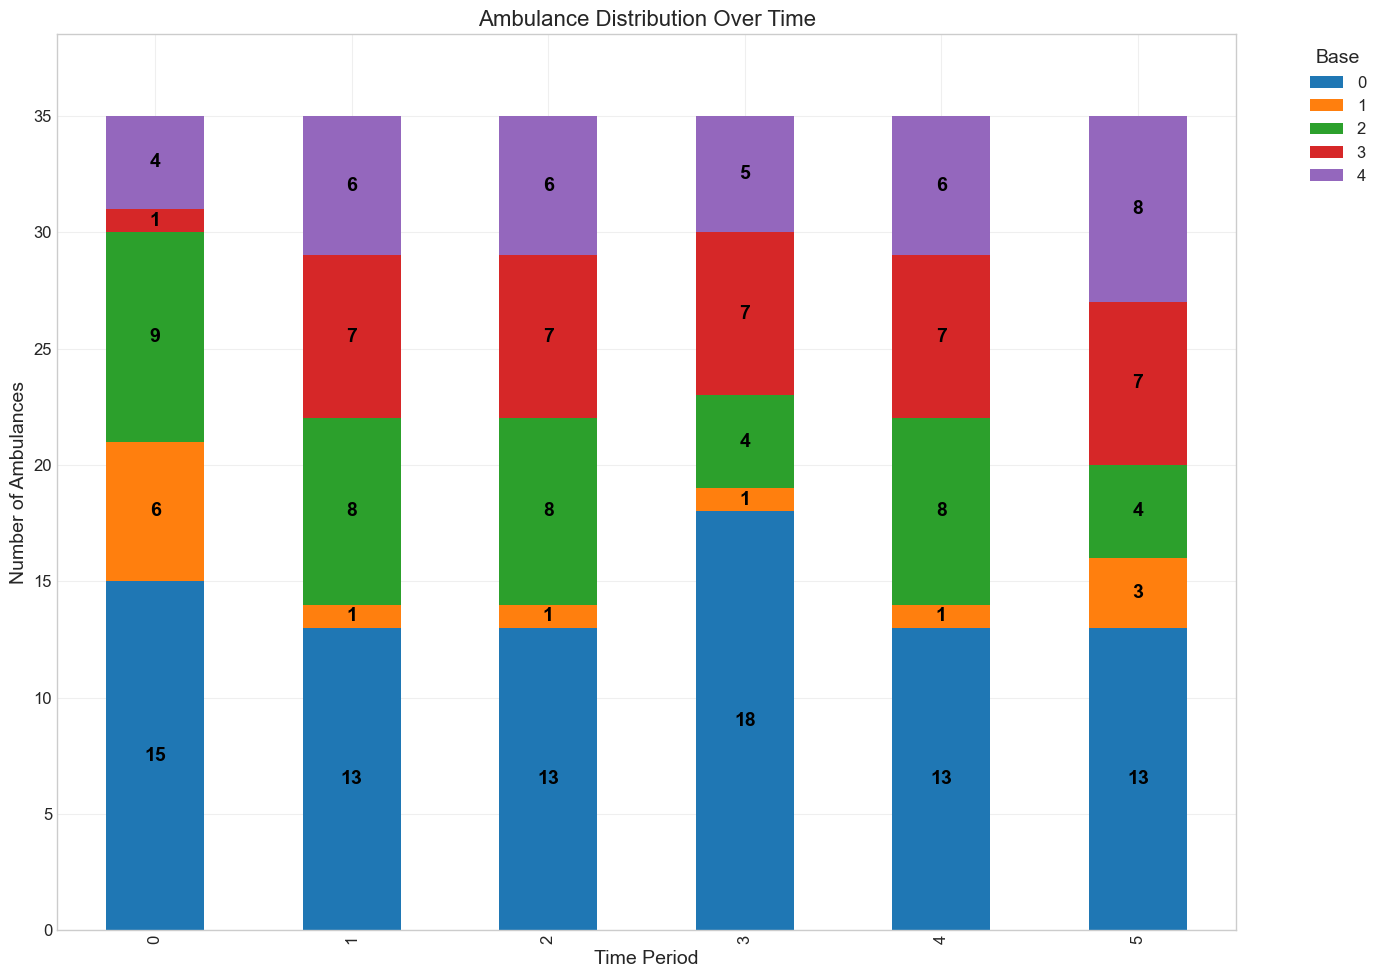

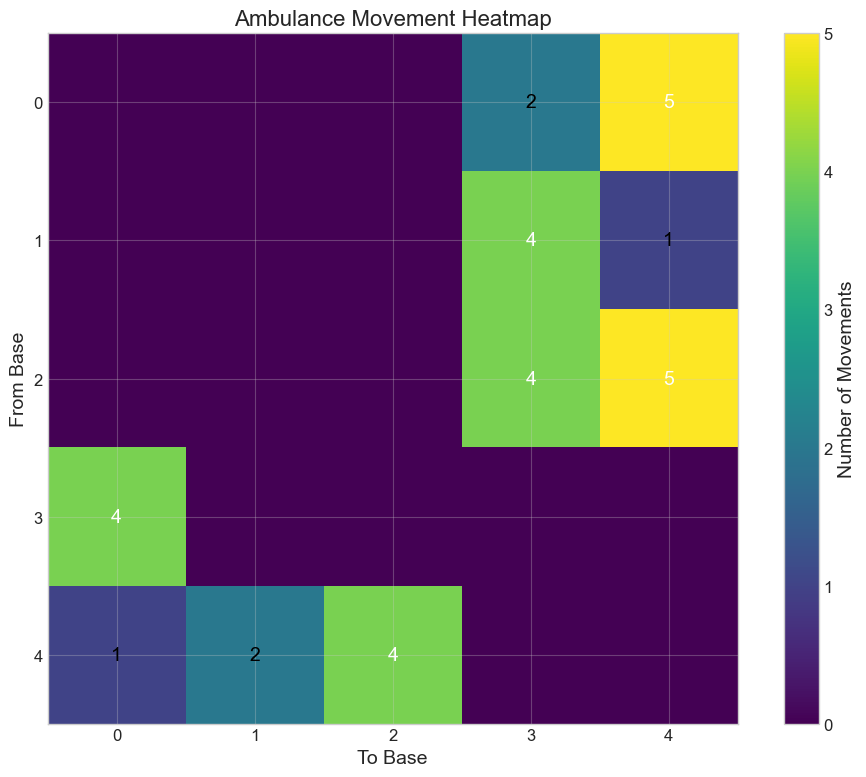

In [211]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx
import time
import os
import pickle
import math
from tqdm import tqdm

# --- SETTINGS ---
T = 6                       # Number of time periods
NUM_AMBULANCES = 35         # Total ambulances available
MAX_CONFIG_FREQUENCY = 3    # Maximum frequency for unary expansion
MAX_MOVEMENT = 10            # Maximum ambulance movement between consecutive time periods
DATA_DIR = "./data/50"      # Directory containing data files
FILENAME = "50-9085-6-7-35" # Base filename for data
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"  # Directory with configuration files
GRAPH_FILE = "50-9085-6-7-35.gpickle"  # Graph file with network structure
TEST_CONFIG_SIZE = 1000     # Number of configurations to use for this test

# Directory for saving results
results_dir = "results/Step4_50-9085-6-7-35_1000configs"
os.makedirs(results_dir, exist_ok=True)

# Print all parameters for verification
print("\n=== MODEL PARAMETERS ===")
print(f"Time periods (T): {T}")
print(f"Total ambulances: {NUM_AMBULANCES}")
print(f"Max config frequency: {MAX_CONFIG_FREQUENCY}")
print(f"Max movement between periods: {MAX_MOVEMENT}")
print(f"Configuration size for testing: {TEST_CONFIG_SIZE}")
print(f"Data directory: {DATA_DIR}")
print(f"Configuration directory: {CONFIG_DIR}")
print(f"Graph file: {GRAPH_FILE}")
print(f"Results directory: {results_dir}")
print("========================\n")

# --- LOAD LICENSE PARAMETERS ---
license_path = "data/gurobi.lic"
params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)
            else:
                params[key] = value

print("License parameters loaded successfully")

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# --- LOAD CONFIGURATIONS ---
print(f"Loading configurations from {os.path.join(CONFIG_DIR, 'configurations.csv')}...")

# Try to load configurations from pickle for faster loading
pickle_file = os.path.join(CONFIG_DIR, "configurations.pkl")
if os.path.exists(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            configurations = pickle.load(f)
        print(f"Loaded {len(configurations)} configurations from pickle file")
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        configurations = None
else:
    configurations = None

# If pickle loading failed, load from CSV
if configurations is None:
    # Load the full CSV file
    df_all = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv"))
    print(f"Loaded configuration CSV with {len(df_all)} rows")
    
    # Extract configurations from dataframe
    configurations = []
    for _, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Processing configurations"):
        config = []
        for i in range(len(base_coords)):
            config.append(int(row[f"base{i}_ambulances"]))
        configurations.append(tuple(config))
    
    # Save to pickle for future runs
    with open(pickle_file, 'wb') as f:
        pickle.dump(configurations, f)
    print(f"Saved {len(configurations)} configurations to pickle file")

total_configs = len(configurations)
print(f"Total configurations available: {total_configs}")

# --- SELECT 1000 CONFIGURATIONS FOR TESTING ---
if total_configs > TEST_CONFIG_SIZE:
    # Use uniform sampling for speed and reproducibility
    step = total_configs // TEST_CONFIG_SIZE
    active_config_indices = list(range(0, total_configs, step))[:TEST_CONFIG_SIZE]
    active_configs = [configurations[idx] for idx in active_config_indices]
else:
    active_config_indices = list(range(total_configs))
    active_configs = configurations

print(f"Selected {len(active_configs)} configurations for testing")
print(f"First configuration: {active_configs[0]}")

# --- VERIFY CONFIGURATIONS ---
print("\n=== CONFIGURATION VERIFICATION ===")
# Verify that each configuration has exactly NUM_AMBULANCES ambulances
for i, config in enumerate(active_configs[:5]):
    total_ambulances = sum(config)
    print(f"Config {i}: {config} - Total: {total_ambulances}")
    if total_ambulances != NUM_AMBULANCES:
        print(f"  WARNING: Expected {NUM_AMBULANCES} ambulances!")
print("=================================")

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
print("Building coverage matrix...")
coverage_start = time.time()

b = {}  # coverage[zone, time_period, config_idx] = 1 if covered, 0 otherwise
for c_idx, config in enumerate(tqdm(active_configs, desc="Building coverage matrix")):
    for base_idx, num_ambulances in enumerate(config):
        if num_ambulances > 0:
            base_zone = base_coords[base_idx]
            coverage = {base_zone} | adjacency.get(base_zone, set())
            for t in range(T):
                for z in coverage:
                    b[(z, t, c_idx)] = 1

coverage_time = time.time() - coverage_start
print(f"Coverage matrix built in {coverage_time:.2f} seconds")

# --- BUILD BASE-CONFIG-AMBULANCE MAPPING ---
print("Building ambulance mapping...")
mapping_start = time.time()

# a[base_idx, config_idx] = number of ambulances at base_idx in config_idx
a = {}
for c_idx, config in enumerate(active_configs):
    for base_idx, num_ambulances in enumerate(config):
        a[(base_idx, c_idx)] = num_ambulances

mapping_time = time.time() - mapping_start
print(f"Ambulance mapping built in {mapping_time:.2f} seconds")

# --- CREATE OPTIMIZATION MODEL ---
print("Creating optimization model...")
env = gp.Env(params=params)
model = gp.Model("AmbulanceOptimization", env=env)

# Set up model parameters and print them
print("\n=== MODEL PARAMETERS SUMMARY ===")
print(f"Model name: AmbulanceOptimization")
print(f"Number of time periods (T): {T}")
print(f"Number of ambulances: {NUM_AMBULANCES}")
print(f"Maximum ambulance movements per period: {MAX_MOVEMENT}")
print(f"Maximum config frequency (unary expansion): {MAX_CONFIG_FREQUENCY}")
print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")
print(f"Number of configurations considered: {len(active_configs)}")
print(f"Total configurations available: {total_configs}")
print("==================================")

# --- MODEL VARIABLES ---
print("Creating model variables...")
variable_start = time.time()

# Z[c, t, k]: binary variable indicating if configuration c is used k times at time t
Z = {}
for c_idx in range(len(active_configs)):
    for t in range(T):
        for k in range(MAX_CONFIG_FREQUENCY + 1):
            Z[(c_idx, t, k)] = model.addVar(vtype=GRB.BINARY, name=f"Z_{c_idx}_{t}_{k}")

# q[c, t]: integer variable representing how many times configuration c is used at time t
q = {}
for c_idx in range(len(active_configs)):
    for t in range(T):
        q[(c_idx, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, ub=MAX_CONFIG_FREQUENCY, name=f"q_{c_idx}_{t}")

# n[i, t]: number of ambulances at base i at time t
n = {}
for i in range(len(base_coords)):
    for t in range(T):
        n[(i, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"n_{i}_{t}")

# m[i, j, t]: ambulances moving from base i to base j between time t and t+1
m = {}
for i in range(len(base_coords)):
    for j in range(len(base_coords)):
        for t in range(T-1):
            m[(i, j, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"m_{i}_{j}_{t}")

# Coverage variables
y = {}
for i in zones:
    y[i] = model.addVar(vtype=GRB.INTEGER, name=f"y_{i}")
    
z = model.addVar(vtype=GRB.INTEGER, name="z")

variable_time = time.time() - variable_start
print(f"Variable creation complete in {variable_time:.2f} seconds")
print(f"Model has {model.numVars} variables")

# --- CONSTRAINTS ---
print("Adding model constraints...")
constraint_start = time.time()

# 1. One-hot encoding: Each configuration at each time must have exactly one frequency
for c_idx in range(len(active_configs)):
    for t in range(T):
        model.addConstr(
            gp.quicksum(Z[(c_idx, t, k)] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
            f"one_hot_{c_idx}_{t}"
        )

# 2. Link q to Z: q[c, t] = sum(k * Z[c, t, k])
for c_idx in range(len(active_configs)):
    for t in range(T):
        model.addConstr(
            q[(c_idx, t)] == gp.quicksum(k * Z[(c_idx, t, k)] for k in range(MAX_CONFIG_FREQUENCY + 1)),
            f"link_q_{c_idx}_{t}"
        )

# 3. Total ambulance count constraint for each time period
for t in range(T):
    model.addConstr(
        gp.quicksum(q[(c_idx, t)] for c_idx in range(len(active_configs))) == 1,
        f"config_count_{t}"
    )

# 4. Base ambulance count constraints - link n[i, t] to configurations
for i in range(len(base_coords)):
    for t in range(T):
        model.addConstr(
            n[(i, t)] == gp.quicksum(a.get((i, c_idx), 0) * q[(c_idx, t)] for c_idx in range(len(active_configs))),
            f"base_ambulance_{i}_{t}"
        )

# 5. Flow conservation constraints for movement
for i in range(len(base_coords)):
    for t in range(T-1):
        model.addConstr(
            n[(i, t)] == gp.quicksum(m[(i, j, t)] for j in range(len(base_coords))) + n[(i, t+1)] - gp.quicksum(m[(j, i, t)] for j in range(len(base_coords))),
            f"flow_conservation_{i}_{t}"
        )

# 6. Movement limit constraint - total movement between consecutive periods
for t in range(T-1):
    model.addConstr(
        gp.quicksum(m[(i, j, t)] for i in range(len(base_coords)) for j in range(len(base_coords)) if i != j) <= MAX_MOVEMENT,
        f"movement_limit_{t}"
    )

# 7. Coverage constraints
for i in zones:
    model.addConstr(
        y[i] == gp.quicksum(b.get((i, t, c_idx), 0) * q[(c_idx, t)] for c_idx in range(len(active_configs)) for t in range(T)),
        f"coverage_{i}"
    )

# 8. Fairness constraints
for i in zones:
    for j in zones:
        model.addConstr(
            z >= y[i] - y[j], 
            f"fair_{i}_{j}"
        )

constraint_time = time.time() - constraint_start
print(f"Constraint creation complete in {constraint_time:.2f} seconds")
print(f"Model has {model.numConstrs} constraints")

# --- MODEL TUNING ---
print("Tuning model parameters...")
# Set parameters to help Gurobi handle the large model
model.setParam('MIPGap', 0.02)      # 2% optimality gap
# No time limit as requested
model.setParam('Threads', 0)        # Use all available threads
model.setParam('Method', 2)         # Use barrier method for LP relaxation
model.setParam('PreCrush', 1)       # Presolve for cutting planes
model.setParam('MIPFocus', 1)       # Focus on finding feasible solutions quickly
model.setParam('Heuristics', 0.5)   # Moderate heuristics effort
model.setParam('Cuts', 2)           # Aggressive cut generation
model.setParam('Presolve', 2)       # Aggressive presolve

print("\n=== MODEL TUNING PARAMETERS ===")
print(f"MIP Gap: {model.Params.MIPGap}")
print(f"Threads: {model.Params.Threads}")
print(f"Method: {model.Params.Method}")
print(f"MIP Focus: {model.Params.MIPFocus}")
print(f"No time limit set")

# --- OBJECTIVE ---
model.setObjective(z, GRB.MINIMIZE)  # Minimize the fairness gap

# --- SOLVE MODEL ---
print("Solving model...")
print(f"Model has {model.numVars} variables and {model.numConstrs} constraints")
start_time = time.time()
model.optimize()
solve_time = time.time() - start_time
print(f"Model solved in {solve_time:.2f} seconds with status {model.status}")

# --- COLLECT RESULTS ---
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.SOLUTION_LIMIT:
    results = {}
    results['objective'] = model.objVal
    results['solve_time'] = solve_time
    results['num_variables'] = model.numVars
    results['num_constraints'] = model.numConstrs
    results['model_status'] = model.status
    results['max_movement'] = MAX_MOVEMENT
    results['num_ambulances'] = NUM_AMBULANCES
    results['num_configs'] = len(active_configs)
    results['max_config_frequency'] = MAX_CONFIG_FREQUENCY
    results['mip_gap'] = model.MIPGap
    results['config_size'] = TEST_CONFIG_SIZE

    # Extract configuration selections for each time period
    config_selections = {}
    for t in range(T):
        config_selections[t] = []
        for c_idx in range(len(active_configs)):
            if q[(c_idx, t)].X > 0.5:  # If configuration c is used at time t
                config_selections[t].append((active_config_indices[c_idx], int(q[(c_idx, t)].X + 0.5)))

    # Extract base ambulance counts over time
    base_ambulances = {}
    for i in range(len(base_coords)):
        base_ambulances[i] = [int(n[(i, t)].X + 0.5) for t in range(T)]  # Adding 0.5 and casting to int to round properly
    
    # Verify ambulance count consistency
    print("\n=== AMBULANCE COUNT VERIFICATION ===")
    for t in range(T):
        total_ambulances = sum(base_ambulances[i][t] for i in range(len(base_coords)))
        print(f"Time period {t}: {total_ambulances} ambulances")
        if total_ambulances != NUM_AMBULANCES:
            print(f"  WARNING: Expected {NUM_AMBULANCES} ambulances!")
    print("=====================================")

    # Extract movement data
    movements = {}
    total_movement = 0
    for t in range(T-1):
        movements[t] = []
        period_movement = 0
        for i in range(len(base_coords)):
            for j in range(len(base_coords)):
                if i != j and m[(i, j, t)].X > 0.5:
                    move_count = int(m[(i, j, t)].X + 0.5)  # Round to nearest integer
                    movements[t].append((i, j, move_count))
                    period_movement += move_count
        movements[t].append(('total', period_movement))
        total_movement += period_movement

    # Extract coverage values
    coverage_values = [int(y[i].X + 0.5) for i in zones]  # Round to nearest integer
    fairness_gap = int(z.X + 0.5)  # Round to nearest integer

    # Store detailed results
    results['fairness_gap'] = fairness_gap
    results['min_coverage'] = min(coverage_values)
    results['max_coverage'] = max(coverage_values)
    results['avg_coverage'] = np.mean(coverage_values)
    results['total_movement'] = total_movement
    results['config_selections'] = config_selections
    results['base_ambulances'] = base_ambulances
    results['movements'] = movements
    
    # Calculate zone coverage details
    zone_coverage = {}
    for i in zones:
        zone_coverage[str(i)] = int(y[i].X + 0.5)
    results['zone_coverage'] = zone_coverage

    # Save results to file
    with open(os.path.join(results_dir, 'model_results.pkl'), 'wb') as f:
        pickle.dump(results, f)

    # Save base ambulance counts to CSV
    base_df = pd.DataFrame(base_ambulances)
    base_df.columns = [f"Base_{i}" for i in range(len(base_coords))]
    base_df.index = [f"Time_{t}" for t in range(T)]
    base_df.to_csv(os.path.join(results_dir, 'base_ambulances.csv'))

    # Save movement data to CSV
    movement_rows = []
    for t in range(T-1):
        for move in movements[t]:
            if move[0] != 'total':
                movement_rows.append({
                    'Time': t,
                    'From_Base': move[0],
                    'To_Base': move[1],
                    'Ambulances': move[2]
                })
    movement_df = pd.DataFrame(movement_rows)
    if not movement_df.empty:
        movement_df.to_csv(os.path.join(results_dir, 'movements.csv'), index=False)
    
    # Save zone coverage to CSV
    zone_df = pd.DataFrame([{'Zone': zone, 'Coverage': coverage} for zone, coverage in zone_coverage.items()])
    zone_df.to_csv(os.path.join(results_dir, 'zone_coverage.csv'), index=False)

    # Save solution statistics to CSV
    solution_stats = pd.DataFrame([{
        'Config_Size': TEST_CONFIG_SIZE,
        'Fairness_Gap': fairness_gap,
        'Min_Coverage': min(coverage_values),
        'Max_Coverage': max(coverage_values),
        'Avg_Coverage': np.mean(coverage_values),
        'Total_Movements': total_movement,
        'Solve_Time': solve_time,
        'MIP_Gap': model.MIPGap,
        'Status': model.status,
        'Active_Configs': len(active_configs),
        'Total_Configs': total_configs
    }])
    solution_stats.to_csv(os.path.join(results_dir, 'solution_stats.csv'), index=False)

    print(f"\n=== OPTIMIZATION RESULTS ===")
    print(f"Fairness Gap: {fairness_gap}")
    print(f"Coverage Range: {min(coverage_values)} to {max(coverage_values)}")
    print(f"Average Coverage: {np.mean(coverage_values):.2f}")
    print(f"Total Ambulance Movements: {total_movement}")
    print(f"Movement Constraint: Maximum {MAX_MOVEMENT} movements per time period")
    print(f"Model Size: {model.numVars} variables, {model.numConstrs} constraints")
    print(f"Solve Time: {solve_time:.2f} seconds")
    print(f"MIP Gap: {model.MIPGap:.4f}")
    print(f"\nResults saved to {results_dir}")
else:
    print(f"Model did not reach optimal solution. Status: {model.status}")

# --- VISUALIZATION ---
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.SOLUTION_LIMIT:
    print("\nCreating visualizations...")
    
    # 1. Ambulance distribution over time
    plt.figure(figsize=(12, 6))
    base_df = pd.DataFrame(base_ambulances)
    
    # Verify the sum of ambulances is correct
    for t in range(T):
        total_ambulances = sum(base_df.iloc[t])
        if total_ambulances != NUM_AMBULANCES:
            print(f"Warning: Time period {t} has {total_ambulances} ambulances instead of {NUM_AMBULANCES}")
    
    # Create properly scaled bar chart
    ax = base_df.plot(kind='bar', stacked=True)
    
    # Add data labels on top of each bar
    for t in range(T):
        total = 0
        for base in range(len(base_coords)):
            value = base_df.iloc[t, base]
            if value > 0:
                # Position the text in the middle of each segment
                plt.text(t, total + value/2, str(int(value)), 
                         ha='center', va='center', fontweight='bold', color='black')
                total += value
    
    plt.title('Ambulance Distribution Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Number of Ambulances')
    plt.ylim(0, NUM_AMBULANCES * 1.1)  # Set y-axis limit appropriately
    plt.legend(title='Base', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'ambulance_distribution.png'), dpi=300)
    
    # 2. Movement heatmap
    movement_matrix = np.zeros((len(base_coords), len(base_coords)))
    for t in range(T-1):
        for move in movements[t]:
            if move[0] != 'total':
                i, j, count = move
                movement_matrix[i, j] += count
    
    plt.figure(figsize=(10, 8))
    plt.imshow(movement_matrix, cmap='viridis')
    plt.colorbar(label='Number of Movements')
    plt.title('Ambulance Movement Heatmap')
    plt.xlabel('To Base')
    plt.ylabel('From Base')
    
    # Add text annotations
    for i in range(len(base_coords)):
        for j in range(len(base_coords)):
            if movement_matrix[i, j] > 0:
                plt.text(j, i, int(movement_matrix[i, j]), 
                         ha="center", va="center", 
                         color="white" if movement_matrix[i, j] > movement_matrix.max()/2 else "black")
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'movement_heatmap.png'), dpi=300)
    
    print("Visualizations saved to results directory")

# Clean up
model.dispose()
env.dispose()

print("Optimization complete!")


=== MODEL PARAMETERS ===
Time periods (T): 6
Total ambulances: 35
Max config frequency: 3
Max movement between periods: 10
Number of configuration size intervals: 20
Data directory: ./data/50
Configuration directory: ./configurations/50/50-9085-6-7-35_allocations
Graph file: 50-9085-6-7-35.gpickle
Results directory: results/Step4_Intervals

License parameters loaded successfully
Number of zones: 50
Number of bases: 5
Loading configurations from ./configurations/50/50-9085-6-7-35_allocations/configurations.csv...
Loaded 82251 configurations from pickle file
Total configurations available: 82251

=== CONFIGURATION SIZES FOR TESTING ===
Testing with 20 configuration sizes: [0, 5, 20, 45, 80, 125, 180, 245, 320, 405, 500, 605, 720, 845, 980, 1125, 1280, 1445, 1620, 1805]

Running experiment with 0 configurations...

RUNNING EXPERIMENT WITH 0 CONFIGURATIONS
Error in experiment with 0 configurations: integer division or modulo by zero

Running experiment with 5 configurations...

RUNNING EX

Building coverage matrix: 100%|██████████| 5/5 [00:00<00:00, 19239.93it/s]

Coverage matrix built in 0.00 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu


Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.02 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model 

Building coverage matrix: 100%|██████████| 20/20 [00:00<00:00, 22245.05it/s]

Coverage matrix built in 0.00 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.02 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: App

Model solved in 0.03 seconds with status 2

=== AMBULANCE COUNT VERIFICATION ===
Time period 0: 35 ambulances
Time period 1: 35 ambulances
Time period 2: 35 ambulances
Time period 3: 35 ambulances
Time period 4: 35 ambulances
Time period 5: 35 ambulances

=== OPTIMIZATION RESULTS ===
Config Size: 20
Fairness Gap: 0
Coverage Range: 6 to 6
Average Coverage: 6.00
Total Ambulance Movements: 30
Solve Time: 0.03 seconds
MIP Gap: 0.0000
Partial results saved to results/Step4_Intervals/interval_results.csv

Running experiment with 45 configurations...

RUNNING EXPERIMENT WITH 45 CONFIGURATIONS
Selected 45 configurations for this experiment
Building coverage matrix...


Building coverage matrix: 100%|██████████| 45/45 [00:00<00:00, 26423.59it/s]

Coverage matrix built in 0.00 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.03 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: App

Partial results saved to results/Step4_Intervals/interval_results.csv

Running experiment with 80 configurations...

RUNNING EXPERIMENT WITH 80 CONFIGURATIONS
Selected 80 configurations for this experiment
Building coverage matrix...


Building coverage matrix: 100%|██████████| 80/80 [00:00<00:00, 28121.38it/s]

Coverage matrix built in 0.00 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.03 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: App

Presolve removed 3500 rows and 1998 columns
Presolve time: 0.02s
Presolved: 76 rows, 608 columns, 5284 nonzeros
Variable types: 0 continuous, 608 integer (480 binary)
Root relaxation presolve removed 5 rows and 0 columns
Root relaxation presolved: 71 rows, 608 columns, 4954 nonzeros

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.840e+02
 Factor NZ  : 1.212e+03
 Factor Ops : 2.352e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.83924002e+00 -4.54349540e+02  2.44e+02 1.14e-02  1.56e+00     0s
   1   3.64916158e+00 -1.56022721e+02  9.16e+00 6.66e-16  1.60e-01     0s
   2   1.05108113e+00 -1.22660918e+01  7.99e-15 4.68e-16  1.08e-02     0s
   3   4.77657575e-01 -5.82528771e-01  2.40e-14 5.01e-16  8.59e-04     0s
   4   2.18011932e-02 -4.82255781e-02  2.40e-14 2.45e-16  5.67e-05     0s
   5   1.63013972e-05 -2.5235273

Building coverage matrix: 100%|██████████| 125/125 [00:00<00:00, 26567.75it/s]

Coverage matrix built in 0.01 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.04 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05


Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 4116 rows, 3956 columns and 53046 nonzeros
Model fingerprint: 0xbc6ca29e
Variable types: 0 continuous, 3956 integer (3000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00

Building coverage matrix: 100%|██████████| 180/180 [00:00<00:00, 27583.02it/s]

Coverage matrix built in 0.01 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.05 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1


Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 4776 rows, 5606 columns and 72972 nonzeros
Model fingerprint: 0xaebe4854
Variable types: 0 continuous, 5606 integer (4320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 4664 rows and 4395 columns
Presolve time: 0.05s
Presolved: 112 rows, 1211 columns, 11626 nonzeros
Variable typ

Building coverage matrix: 100%|██████████| 245/245 [00:00<00:00, 27800.14it/s]

Coverage matrix built in 0.01 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.00 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.09 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05


Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 5556 rows, 7556 columns and 95712 nonzeros
Model fingerprint: 0x9ff6d0cd
Variable types: 0 continuous, 7556 integer (5880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00

Building coverage matrix: 100%|██████████| 320/320 [00:00<00:00, 27650.38it/s]

Coverage matrix built in 0.01 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.26 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.08 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 6456 rows, 9806 columns and 123708 nonzeros
Model fingerprint: 0xdf5f6d49
Variable types: 0 continuous, 9806 integer

Building coverage matrix: 100%|██████████| 405/405 [00:00<00:00, 27095.85it/s]

Coverage matrix built in 0.02 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.01 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.11 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: App

Presolve removed 7348 rows and 9794 columns
Presolve time: 0.15s
Presolved: 128 rows, 2562 columns, 25586 nonzeros
Variable types: 0 continuous, 2562 integer (2430 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.16 seconds (0.50 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 5.00e-02)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Model solved in 0.16 seconds with status 2

=== AMBULANCE COUNT VERIFICATION ===
Time period 0: 35 ambulances
Time period 1: 35 ambulances
Time period 2: 35 ambulances
Time period 3: 35 ambulances
Time period 4: 35 ambulances
Time period 5: 35 ambulances

=== OPTIMIZATION RESULTS ===
Config Size: 405
Fairness Gap: 0
Coverage Range: 6 to 6
Average Coverage: 6.00
Total Ambulance Movements: 0
Solve Time: 0.16 seconds
MIP Gap: 0.0000
Partial results saved to results/Step4_Intervals/interval_results.csv

Running 

Building coverage matrix: 100%|██████████| 500/500 [00:00<00:00, 26883.12it/s]

Coverage matrix built in 0.02 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.01 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.12 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: App

Presolve removed 8479 rows and 12074 columns
Presolve time: 0.21s
Presolved: 137 rows, 3132 columns, 31776 nonzeros
Variable types: 0 continuous, 3132 integer (3000 binary)
Root relaxation presolve removed 5 rows and 0 columns
Root relaxation presolved: 132 rows, 3132 columns, 30306 nonzeros

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.130e+03
 Factor NZ  : 4.365e+03 (roughly 1 MB of memory)
 Factor Ops : 2.026e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.79059188e+00 -8.30589003e+02  1.76e+03 1.94e-02  9.50e-01     0s
   1   5.65481021e+00 -3.52562604e+02  1.55e+02 5.55e-16  1.15e-01     0s
   2   4.97410775e+00 -2.46656692e+02  5.09e+00 3.77e-15  4.15e-02     0s
   3   2.78645376e+00 -2.20828643e+01  2.62e-14 5.94e-16  3.92e-03     0s
   4   1.98806856e+00 -2.13040629e+00  1.22e-13 3.11e-15  6.50e-04     0

Building coverage matrix: 100%|██████████| 605/605 [00:00<00:00, 29565.23it/s]

Coverage matrix built in 0.02 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.01 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.14 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: App

Presolve removed 9748 rows and 14594 columns
Presolve time: 0.28s
Presolved: 128 rows, 3762 columns, 37712 nonzeros
Variable types: 0 continuous, 3762 integer (3630 binary)
Found heuristic solution: objective 6.0000000
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.30 seconds (0.99 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 0 6 

Optimal solution found (tolerance 5.00e-02)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Model solved in 0.31 seconds with status 2

=== AMBULANCE COUNT VERIFICATION ===
Time period 0: 35 ambulances
Time period 1: 35 ambulances
Time period 2: 35 ambulances
Time period 3: 35 ambulances
Time period 4: 35 ambulances
Time period 5: 35 ambulances

=== OPTIMIZATION RESULTS ===
Config Size: 605
Fairness Gap: 0
Coverage Range: 6 to 6
Average Coverage: 6.00
Total Ambulance Movements: 0
Solve Time: 0.31 seconds
MIP Gap: 0.0000
Partial results saved to resul

Building coverage matrix: 100%|██████████| 720/720 [00:00<00:00, 26770.73it/s]

Coverage matrix built in 0.03 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.01 seconds
Model has 0 variables
Adding model constraints...
Constraint creation complete in 0.18 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0


Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 11256 rows, 21806 columns and 269034 nonzeros
Model fingerprint: 0x1c3fc711
Variable types: 0 continuous, 21806 integer (17280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 11129

Building coverage matrix: 100%|██████████| 845/845 [00:00<00:00, 25712.88it/s]

Coverage matrix built in 0.03 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.01 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.20 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 12756 rows, 25556 columns and 314592 nonzeros
Model fingerprint: 0x97e07c26
Variable types: 0 continuous, 25556 inte

Building coverage matrix: 100%|██████████| 980/980 [00:00<00:00, 28547.94it/s]

Coverage matrix built in 0.04 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.02 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.25 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 14376 rows, 29606 columns and 364770 nonzeros
Model fingerprint: 0x81054b82
Variable types: 0 continuous, 29606 inte

Building coverage matrix: 100%|██████████| 1125/1125 [00:00<00:00, 26718.94it/s]

Coverage matrix built in 0.04 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.02 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.27 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 16116 rows, 33956 columns and 416202 nonzeros
Model fingerprint: 0x05e0082c
Variable types: 0 continuous, 33956 inte

Building coverage matrix: 100%|██████████| 1280/1280 [00:00<00:00, 24867.80it/s]

Coverage matrix built in 0.05 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.02 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.32 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 17976 rows, 38606 columns and 472008 nonzeros
Model fingerprint: 0xddb3c945
Variable types: 0 continuous, 38606 inte

Building coverage matrix: 100%|██████████| 1445/1445 [00:00<00:00, 24508.55it/s]

Coverage matrix built in 0.06 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.03 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.39 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 19956 rows, 43556 columns and 531708 nonzeros
Model fingerprint: 0xc4f66d83
Variable types: 0 continuous, 43556 inte

Building coverage matrix: 100%|██████████| 1620/1620 [00:00<00:00, 26441.17it/s]

Coverage matrix built in 0.06 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.06 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.40 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 22056 rows, 48806 columns and 591798 nonzeros
Model fingerprint: 0xc64d6794
Variable types: 0 continuous, 48806 inte

Building coverage matrix: 100%|██████████| 1805/1805 [00:00<00:00, 26539.81it/s]

Coverage matrix built in 0.07 seconds
Building ambulance mapping...
Ambulance mapping built in 0.00 seconds
Creating optimization model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Creating model variables...
Variable creation complete in 0.03 seconds
Model has 0 variables
Adding model constraints...


Constraint creation complete in 0.44 seconds
Model has 0 constraints
Tuning model parameters...
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter Threads to value 0
Set parameter Method to value 2
Set parameter PreCrush to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Solving model...
Model has 0 variables and 0 constraints
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05
Method  2
Heuristics  0.5
MIPFocus  1
Cuts  2
PreCrush  1
Presolve  2

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 24276 rows, 54356 columns and 656808 nonzeros
Model fingerprint: 0x3e826b19
Variable types: 0 continuous, 54356 inte

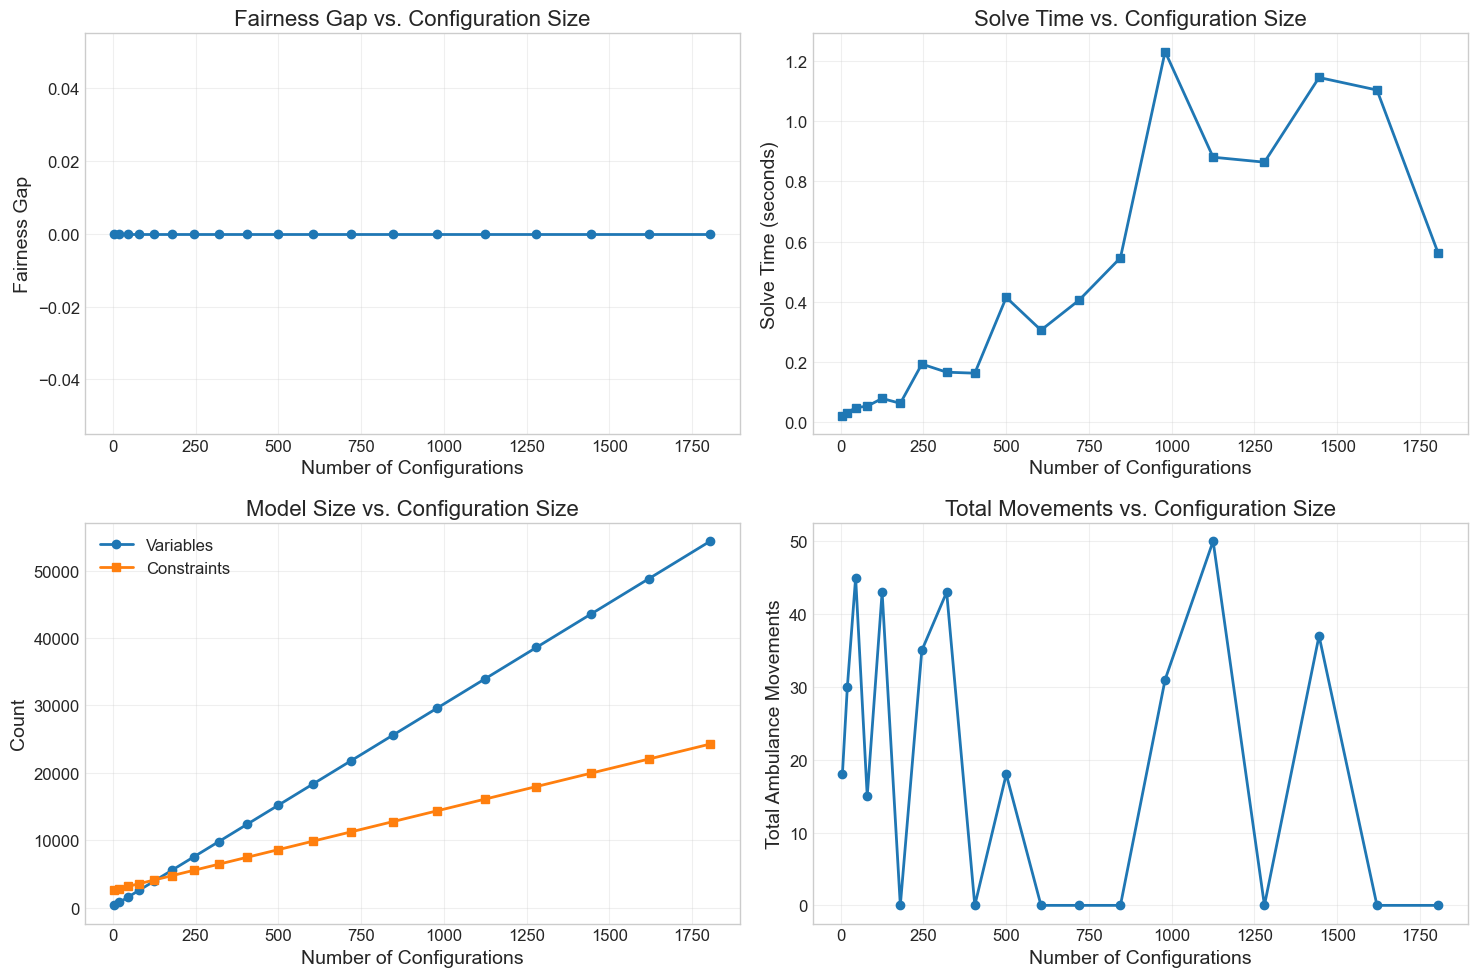

In [219]:
# --- SETTINGS ---
T = 6                       # Number of time periods
NUM_AMBULANCES = 35         # Total ambulances available
MAX_CONFIG_FREQUENCY = 3    # Maximum frequency for unary expansion
MAX_MOVEMENT = 10           # Maximum ambulance movement between consecutive time periods
DATA_DIR = "./data/50"      # Directory containing data files
FILENAME = "50-9085-6-7-35" # Base filename for data
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"  # Directory with configuration files
GRAPH_FILE = "50-9085-6-7-35.gpickle"  # Graph file with network structure
NUM_INTERVALS = 20           # Number of configuration size intervals to test

# Directory for saving results
results_dir = "results/Step4_Intervals"
os.makedirs(results_dir, exist_ok=True)

# Print all parameters for verification
print("\n=== MODEL PARAMETERS ===")
print(f"Time periods (T): {T}")
print(f"Total ambulances: {NUM_AMBULANCES}")
print(f"Max config frequency: {MAX_CONFIG_FREQUENCY}")
print(f"Max movement between periods: {MAX_MOVEMENT}")
print(f"Number of configuration size intervals: {NUM_INTERVALS}")
print(f"Data directory: {DATA_DIR}")
print(f"Configuration directory: {CONFIG_DIR}")
print(f"Graph file: {GRAPH_FILE}")
print(f"Results directory: {results_dir}")
print("========================\n")

# --- LOAD LICENSE PARAMETERS ---
license_path = "data/gurobi.lic"
params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)
            else:
                params[key] = value

print("License parameters loaded successfully")

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# --- LOAD CONFIGURATIONS ---
print(f"Loading configurations from {os.path.join(CONFIG_DIR, 'configurations.csv')}...")

# Try to load configurations from pickle for faster loading
pickle_file = os.path.join(CONFIG_DIR, "configurations.pkl")
if os.path.exists(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            configurations = pickle.load(f)
        print(f"Loaded {len(configurations)} configurations from pickle file")
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        configurations = None
else:
    configurations = None

# If pickle loading failed, load from CSV
if configurations is None:
    # Load the full CSV file
    df_all = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv"))
    print(f"Loaded configuration CSV with {len(df_all)} rows")
    
    # Extract configurations from dataframe
    configurations = []
    for _, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Processing configurations"):
        config = []
        for i in range(len(base_coords)):
            config.append(int(row[f"base{i}_ambulances"]))
        configurations.append(tuple(config))
    
    # Save to pickle for future runs
    with open(pickle_file, 'wb') as f:
        pickle.dump(configurations, f)
    print(f"Saved {len(configurations)} configurations to pickle file")

total_configs = len(configurations)
print(f"Total configurations available: {total_configs}")

# --- GENERATE CONFIGURATION SIZES FOR TESTING ---
# Use a smaller minimum and more focused distribution
MIN_CONFIG_SIZE = 5  # Start with 5 configurations
config_sizes = []

# Define the interval scaling - use exponential growth for better spread
# This focuses more samples on smaller sizes where changes are more significant
config_sizes = [
    min(int(MIN_CONFIG_SIZE * (i ** 2)), total_configs) 
    for i in range(NUM_INTERVALS)
]

# Remove duplicates and sort
config_sizes = sorted(list(set(config_sizes)))

print(f"\n=== CONFIGURATION SIZES FOR TESTING ===")
print(f"Testing with {len(config_sizes)} configuration sizes: {config_sizes}")
print("========================================")

# Function to run one optimization experiment
def run_experiment(config_size):
    experiment_start = time.time()
    
    print(f"\n{'='*80}")
    print(f"RUNNING EXPERIMENT WITH {config_size} CONFIGURATIONS")
    print(f"{'='*80}")
    
    exp_results_dir = os.path.join(results_dir, f"config_{config_size}")
    os.makedirs(exp_results_dir, exist_ok=True)
    
    # Select configurations for this experiment
    if config_size < total_configs:
        # Use uniform sampling for speed and reproducibility
        step = total_configs // config_size
        active_config_indices = list(range(0, total_configs, step))[:config_size]
        active_configs = [configurations[idx] for idx in active_config_indices]
    else:
        active_config_indices = list(range(total_configs))
        active_configs = configurations
    
    print(f"Selected {len(active_configs)} configurations for this experiment")
    
    # --- BUILD COVERAGE MATRIX b[i,t,c] ---
    print("Building coverage matrix...")
    coverage_start = time.time()
    
    b = {}  # coverage[zone, time_period, config_idx] = 1 if covered, 0 otherwise
    for c_idx, config in enumerate(tqdm(active_configs, desc="Building coverage matrix")):
        for base_idx, num_ambulances in enumerate(config):
            if num_ambulances > 0:
                base_zone = base_coords[base_idx]
                coverage = {base_zone} | adjacency.get(base_zone, set())
                for t in range(T):
                    for z in coverage:
                        b[(z, t, c_idx)] = 1
    
    coverage_time = time.time() - coverage_start
    print(f"Coverage matrix built in {coverage_time:.2f} seconds")
    
    # --- BUILD BASE-CONFIG-AMBULANCE MAPPING ---
    print("Building ambulance mapping...")
    mapping_start = time.time()
    
    # a[base_idx, config_idx] = number of ambulances at base_idx in config_idx
    a = {}
    for c_idx, config in enumerate(active_configs):
        for base_idx, num_ambulances in enumerate(config):
            a[(base_idx, c_idx)] = num_ambulances
    
    mapping_time = time.time() - mapping_start
    print(f"Ambulance mapping built in {mapping_time:.2f} seconds")
    
    # --- CREATE OPTIMIZATION MODEL ---
    print("Creating optimization model...")
    env = gp.Env(params=params)
    model = gp.Model("AmbulanceOptimization", env=env)
    
    # --- MODEL VARIABLES ---
    print("Creating model variables...")
    variable_start = time.time()
    
    # Z[c, t, k]: binary variable indicating if configuration c is used k times at time t
    Z = {}
    for c_idx in range(len(active_configs)):
        for t in range(T):
            for k in range(MAX_CONFIG_FREQUENCY + 1):
                Z[(c_idx, t, k)] = model.addVar(vtype=GRB.BINARY, name=f"Z_{c_idx}_{t}_{k}")
    
    # q[c, t]: integer variable representing how many times configuration c is used at time t
    q = {}
    for c_idx in range(len(active_configs)):
        for t in range(T):
            q[(c_idx, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, ub=MAX_CONFIG_FREQUENCY, name=f"q_{c_idx}_{t}")
    
    # n[i, t]: number of ambulances at base i at time t
    n = {}
    for i in range(len(base_coords)):
        for t in range(T):
            n[(i, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"n_{i}_{t}")
    
    # m[i, j, t]: ambulances moving from base i to base j between time t and t+1
    m = {}
    for i in range(len(base_coords)):
        for j in range(len(base_coords)):
            for t in range(T-1):
                m[(i, j, t)] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"m_{i}_{j}_{t}")
    
    # Coverage variables
    y = {}
    for i in zones:
        y[i] = model.addVar(vtype=GRB.INTEGER, name=f"y_{i}")
        
    z = model.addVar(vtype=GRB.INTEGER, name="z")
    
    variable_time = time.time() - variable_start
    print(f"Variable creation complete in {variable_time:.2f} seconds")
    print(f"Model has {model.numVars} variables")
    
    # --- CONSTRAINTS ---
    print("Adding model constraints...")
    constraint_start = time.time()
    
    # 1. One-hot encoding: Each configuration at each time must have exactly one frequency
    for c_idx in range(len(active_configs)):
        for t in range(T):
            model.addConstr(
                gp.quicksum(Z[(c_idx, t, k)] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
                f"one_hot_{c_idx}_{t}"
            )
    
    # 2. Link q to Z: q[c, t] = sum(k * Z[c, t, k])
    for c_idx in range(len(active_configs)):
        for t in range(T):
            model.addConstr(
                q[(c_idx, t)] == gp.quicksum(k * Z[(c_idx, t, k)] for k in range(MAX_CONFIG_FREQUENCY + 1)),
                f"link_q_{c_idx}_{t}"
            )
    
    # 3. Total ambulance count constraint for each time period
    for t in range(T):
        model.addConstr(
            gp.quicksum(q[(c_idx, t)] for c_idx in range(len(active_configs))) == 1,
            f"config_count_{t}"
        )
    
    # 4. Base ambulance count constraints - link n[i, t] to configurations
    for i in range(len(base_coords)):
        for t in range(T):
            model.addConstr(
                n[(i, t)] == gp.quicksum(a.get((i, c_idx), 0) * q[(c_idx, t)] for c_idx in range(len(active_configs))),
                f"base_ambulance_{i}_{t}"
            )
    
    # 5. Flow conservation constraints for movement
    for i in range(len(base_coords)):
        for t in range(T-1):
            model.addConstr(
                n[(i, t)] == gp.quicksum(m[(i, j, t)] for j in range(len(base_coords))) + n[(i, t+1)] - gp.quicksum(m[(j, i, t)] for j in range(len(base_coords))),
                f"flow_conservation_{i}_{t}"
            )
    
    # 6. Movement limit constraint - total movement between consecutive periods
    for t in range(T-1):
        model.addConstr(
            gp.quicksum(m[(i, j, t)] for i in range(len(base_coords)) for j in range(len(base_coords)) if i != j) <= MAX_MOVEMENT,
            f"movement_limit_{t}"
        )
    
    # 7. Coverage constraints
    for i in zones:
        model.addConstr(
            y[i] == gp.quicksum(b.get((i, t, c_idx), 0) * q[(c_idx, t)] for c_idx in range(len(active_configs)) for t in range(T)),
            f"coverage_{i}"
        )
    
    # 8. Fairness constraints
    for i in zones:
        for j in zones:
            model.addConstr(
                z >= y[i] - y[j], 
                f"fair_{i}_{j}"
            )
    
    constraint_time = time.time() - constraint_start
    print(f"Constraint creation complete in {constraint_time:.2f} seconds")
    print(f"Model has {model.numConstrs} constraints")
    
    # --- MODEL TUNING ---
    print("Tuning model parameters...")
    # Set parameters to help Gurobi handle the large model
    model.setParam('MIPGap', 0.05)      # 5% optimality gap for faster results
    model.setParam('TimeLimit', 600)    # 10-minute time limit per experiment
    model.setParam('Threads', 0)        # Use all available threads
    model.setParam('Method', 2)         # Use barrier method for LP relaxation
    model.setParam('PreCrush', 1)       # Presolve for cutting planes
    model.setParam('MIPFocus', 1)       # Focus on finding feasible solutions quickly
    model.setParam('Heuristics', 0.5)   # Moderate heuristics effort
    model.setParam('Cuts', 2)           # Aggressive cut generation
    model.setParam('Presolve', 2)       # Aggressive presolve
    
    # --- OBJECTIVE ---
    model.setObjective(z, GRB.MINIMIZE)  # Minimize the fairness gap
    
    # --- SOLVE MODEL ---
    print("Solving model...")
    print(f"Model has {model.numVars} variables and {model.numConstrs} constraints")
    start_time = time.time()
    model.optimize()
    solve_time = time.time() - start_time
    print(f"Model solved in {solve_time:.2f} seconds with status {model.status}")
    
    # --- COLLECT RESULTS ---
    results = {}
    
    if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.SOLUTION_LIMIT:
        results['objective'] = model.objVal
        results['solve_time'] = solve_time
        results['num_variables'] = model.numVars
        results['num_constraints'] = model.numConstrs
        results['model_status'] = model.status
        results['max_movement'] = MAX_MOVEMENT
        results['num_ambulances'] = NUM_AMBULANCES
        results['num_configs'] = len(active_configs)
        results['config_size'] = config_size
        results['max_config_frequency'] = MAX_CONFIG_FREQUENCY
        results['mip_gap'] = model.MIPGap
    
        # Extract configuration selections for each time period
        config_selections = {}
        for t in range(T):
            config_selections[t] = []
            for c_idx in range(len(active_configs)):
                if q[(c_idx, t)].X > 0.5:  # If configuration c is used at time t
                    config_selections[t].append((active_config_indices[c_idx], int(q[(c_idx, t)].X + 0.5)))
    
        # Extract base ambulance counts over time
        base_ambulances = {}
        for i in range(len(base_coords)):
            base_ambulances[i] = [int(n[(i, t)].X + 0.5) for t in range(T)]
        
        # Verify ambulance count consistency
        print("\n=== AMBULANCE COUNT VERIFICATION ===")
        for t in range(T):
            total_ambulances = sum(base_ambulances[i][t] for i in range(len(base_coords)))
            print(f"Time period {t}: {total_ambulances} ambulances")
            if total_ambulances != NUM_AMBULANCES:
                print(f"  WARNING: Expected {NUM_AMBULANCES} ambulances!")
        print("=====================================")
    
        # Extract movement data
        movements = {}
        total_movement = 0
        for t in range(T-1):
            movements[t] = []
            period_movement = 0
            for i in range(len(base_coords)):
                for j in range(len(base_coords)):
                    if i != j and m[(i, j, t)].X > 0.5:
                        move_count = int(m[(i, j, t)].X + 0.5)
                        movements[t].append((i, j, move_count))
                        period_movement += move_count
            movements[t].append(('total', period_movement))
            total_movement += period_movement
    
        # Extract coverage values
        coverage_values = [int(y[i].X + 0.5) for i in zones]
        fairness_gap = int(z.X + 0.5)
    
        # Store detailed results
        results['fairness_gap'] = fairness_gap
        results['min_coverage'] = min(coverage_values)
        results['max_coverage'] = max(coverage_values)
        results['avg_coverage'] = np.mean(coverage_values)
        results['total_movement'] = total_movement
        
        print(f"\n=== OPTIMIZATION RESULTS ===")
        print(f"Config Size: {config_size}")
        print(f"Fairness Gap: {fairness_gap}")
        print(f"Coverage Range: {min(coverage_values)} to {max(coverage_values)}")
        print(f"Average Coverage: {np.mean(coverage_values):.2f}")
        print(f"Total Ambulance Movements: {total_movement}")
        print(f"Solve Time: {solve_time:.2f} seconds")
        print(f"MIP Gap: {model.MIPGap:.4f}")
    else:
        results['solve_time'] = solve_time
        results['num_variables'] = model.numVars
        results['num_constraints'] = model.numConstrs
        results['model_status'] = model.status
        results['config_size'] = config_size
        print(f"Model did not reach optimal solution. Status: {model.status}")
    
    # Clean up
    model.dispose()
    env.dispose()
    
    # Return results for summarization
    total_time = time.time() - experiment_start
    results['total_time'] = total_time
    
    # Save this result to a CSV file for this specific size
    results_df = pd.DataFrame([results])
    results_df.to_csv(os.path.join(exp_results_dir, 'results.csv'), index=False)
    
    return results

# Store results for each configuration size
all_results = []

# Run experiments for each configuration size
for size in config_sizes:
    try:
        print(f"\nRunning experiment with {size} configurations...")
        results = run_experiment(size)
        all_results.append(results)
        
        # Save partial results after each experiment
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(os.path.join(results_dir, 'interval_results.csv'), index=False)
        print(f"Partial results saved to {os.path.join(results_dir, 'interval_results.csv')}")
    except Exception as e:
        print(f"Error in experiment with {size} configurations: {str(e)}")
        # Try to continue with next size
        continue

# Final results summary
if all_results:
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(os.path.join(results_dir, 'final_results.csv'), index=False)
    
    # Print summary table
    summary = results_df[['config_size', 'fairness_gap', 'solve_time', 'min_coverage', 'max_coverage', 'avg_coverage', 'total_movement']]
    print("\nResults Summary:")
    print(summary.to_string(index=False))
    
    print(f"\nFull results saved to {os.path.join(results_dir, 'final_results.csv')}")
else:
    print("No successful experiments to report.")

# Create a basic plot of the results
if all_results:
    try:
        plt.figure(figsize=(15, 10))
        
        # Configure the plot grid
        plt.subplot(2, 2, 1)
        plt.plot(results_df['config_size'], results_df['fairness_gap'], 'o-', linewidth=2)
        plt.title('Fairness Gap vs. Configuration Size')
        plt.xlabel('Number of Configurations')
        plt.ylabel('Fairness Gap')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 2)
        plt.plot(results_df['config_size'], results_df['solve_time'], 's-', linewidth=2)
        plt.title('Solve Time vs. Configuration Size')
        plt.xlabel('Number of Configurations')
        plt.ylabel('Solve Time (seconds)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 3)
        plt.plot(results_df['config_size'], results_df['num_variables'], 'o-', label='Variables', linewidth=2)
        plt.plot(results_df['config_size'], results_df['num_constraints'], 's-', label='Constraints', linewidth=2)
        plt.title('Model Size vs. Configuration Size')
        plt.xlabel('Number of Configurations')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        plt.plot(results_df['config_size'], results_df['total_movement'], 'o-', linewidth=2)
        plt.title('Total Movements vs. Configuration Size')
        plt.xlabel('Number of Configurations')
        plt.ylabel('Total Ambulance Movements')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, 'results_summary.png'), dpi=300)
        print(f"Basic results plot saved to {os.path.join(results_dir, 'results_summary.png')}")
    except Exception as e:
        print(f"Error creating summary plot: {str(e)}")

print("Scaling experiments complete!")